In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re


In [2]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 

In [4]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return k_best_bids_and_asks

In [5]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [6]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [7]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [8]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if record.shape!=(2,2,5):
        raise ValueError('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [9]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [10]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [11]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [12]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [13]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [14]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [15]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 5)
(99, 10)


# parameters calculation functions

In [16]:
## DONT USE VVV
def get_order_inbalance_interval_bad(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        for j in range(interval):
            #print(np.sum(record[i:i+interval,0,1]))
            result[i]+=math.log((1e-10+np.sum(record[i+j][0][1]))/(1e-10+np.sum(record[i+j][1][1]))) # ln(bid size/ask size)
    return result
###DONT USE AAAA

def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [17]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[1504.,  466., 2115., 8682.,  667.],
       [3396.,  701., 2615., 8682.,  501.],
       [3582.,  701., 2115., 8682., 1001.],
       [3323., 3262., 3146., 9713., 2032.]])

In [18]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [19]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [20]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter+1))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [21]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+book_counter*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [22]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [23]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [24]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [25]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [26]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [27]:
1e7

10000000.0

# HEATMAP

In [28]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


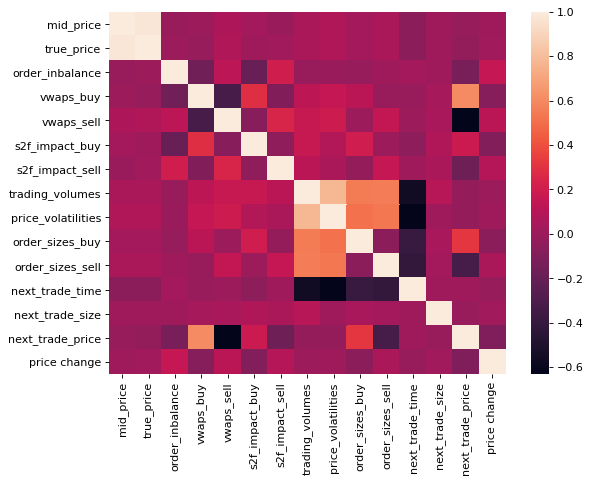

In [29]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

# models

In [30]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier



In [31]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [32]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [33]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [34]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [152]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = y[:,time_back:].flatten()
    return y

In [156]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [38]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [39]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [40]:
def logistic_regr(X, y, split_percent, epsilon=1e-6, comp_id=1, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [41]:
def decision_tree(X, y, split_percent, epsilon, comp_id,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [42]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [43]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.000001

In [158]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))
print("log reg")
print("score: ",logistic_regr(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))




851.5752484506002
decision_tree
Coefficient impact:
order_inbalance   0.1729641282653322
vwaps_buy   0.07423270192734696
vwaps_sell   0.04411683798625255
s2f_impact_buy   0.04322099905392724
s2f_impact_sell   0.03651418186285956
trading_volumes   0.060485265835895675
price_volatilities   0.011442418978486036
vwaps_order_sizes_buy   0.01698972686847152
vwaps_order_sizes_sell   0.04996554305577129
s2f_order_sizes_buy   0.04325991495089717
s2f_order_sizes_sell   0.026243022646108626
next_trade_time   0.10579014450870157
next_trade_size   0.13701036906368141
next_trade_price   0.17776474499626815
score:  0.531578947368421
log reg
Coefficient impact:
order_inbalance   -0.7062669469923076
vwaps_buy   -1.0035278915239507
vwaps_sell   1.3474720034957914
s2f_impact_buy   -0.061930117548838676
s2f_impact_sell   0.23461187211707532
trading_volumes   0.205907501947982
price_volatilities   -0.3065772153293015
vwaps_order_sizes_buy   0.025394912633929304
vwaps_order_sizes_sell   0.6518797542003257
s

# find best epsilon

In [195]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.concatenate((np.array([0]),np.logspace(-8, -3, num=6)))
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [197]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=logistic_regr(X, np.copy(y),split_percent, epsilons[eps], comp_id, True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
1
2
3
4
5
6
7
8
calculations took: 9.70666241645813 seconds


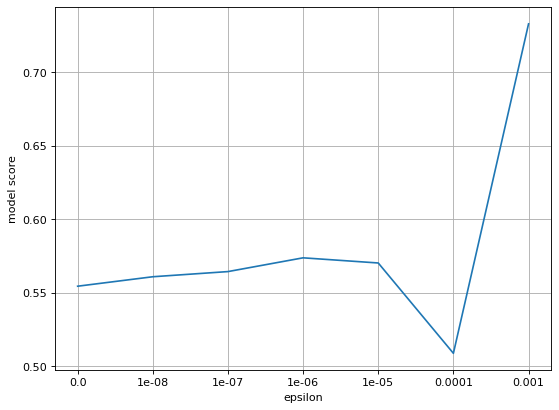

In [204]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.xticks(np.arange(len(epsilons)), epsilons, rotation='0')

plt.grid()

plt.plot(np.sum(comp_eps, axis=0)/9)

## take a look around 1e-6

In [218]:
epsilons=np.arange(start=2e-6,stop=4e-6, step=1e-7)
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [219]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=logistic_regr(X, np.copy(y),split_percent, epsilons[eps], comp_id, True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
calculations took: 184.55247974395752 seconds


best epsilon:  2.699999999999999e-06


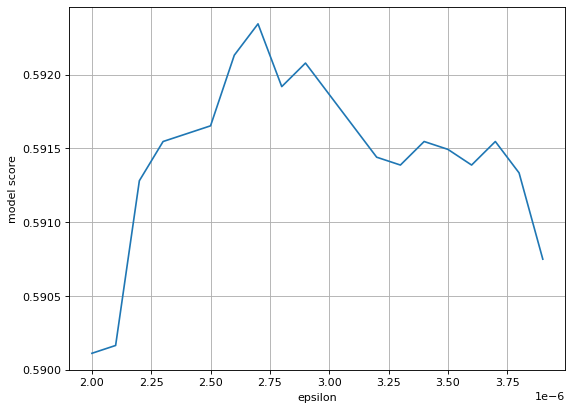

In [223]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
#plt.xticks(np.arange(len(epsilons)), epsilons, rotation='90')

plt.grid()
print("best epsilon: ", epsilons[np.argmax(np.sum(comp_eps, axis=0))])
plt.plot(epsilons, np.sum(comp_eps, axis=0)/99)


In [225]:
2.7e-6

2.7e-06

# try with different features

In [241]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=2.7e-6
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

In [242]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='change')
    scores[c,0]=logistic_regr(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=logistic_regr(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


Coefficient impact:
order_inbalance   -0.3303121695358861
vwaps_buy   -0.7304213167343723
vwaps_sell   0.8199257266756945
s2f_impact_buy   0.13359961692184305
s2f_impact_sell   0.41969969926659256
trading_volumes   0.19534699049331722
price_volatilities   0.12953633538539153
vwaps_order_sizes_buy   0.4968648266590866
vwaps_order_sizes_sell   -0.44127635076672256
s2f_order_sizes_buy   0.0012799084014456527
s2f_order_sizes_sell   -0.23248959529164245
next_trade_time   -0.6016278532181222
next_trade_size   0.1694912200376477
next_trade_price   1.2417835925529768
Coefficient impact:
order_inbalance   -0.003260354000470427
vwaps_buy   -1.5576516055344676
vwaps_sell   1.8764083795141848
s2f_impact_buy   -0.1515134453286144
s2f_impact_sell   -0.08124371225730298
trading_volumes   0.3333625360654169
price_volatilities   -0.34462195197610485
vwaps_order_sizes_buy   -0.6028322340067714
vwaps_order_sizes_sell   0.5378100102073079
s2f_order_sizes_buy   0.479731333338749
s2f_order_sizes_sell   -0.1

Coefficient impact:
order_inbalance   -0.2887914715160913
vwaps_buy   -1.309029413772066
vwaps_sell   1.2787806072826748
s2f_impact_buy   0.1525797492761111
s2f_impact_sell   0.7441111531786515
trading_volumes   -0.2706078182806346
price_volatilities   0.004997997716120745
vwaps_order_sizes_buy   0.19559884768784813
vwaps_order_sizes_sell   -0.19138225896260624
s2f_order_sizes_buy   -0.2418714972520497
s2f_order_sizes_sell   0.11181862489620532
next_trade_time   -0.25675817942765117
next_trade_size   -0.16891070781150058
next_trade_price   1.4684672512559167
Coefficient impact:
order_inbalance   -0.5164287694841659
vwaps_buy   -2.0928250497254197
vwaps_sell   1.5926418308237658
s2f_impact_buy   -0.10827154465030614
s2f_impact_sell   0.17363979965155546
trading_volumes   0.047304116699188374
price_volatilities   0.07589489911082409
vwaps_order_sizes_buy   -0.427568213151626
vwaps_order_sizes_sell   0.29993268694985903
s2f_order_sizes_buy   0.0791961197224468
s2f_order_sizes_sell   0.088

Coefficient impact:
order_inbalance   -0.13391440807046193
vwaps_buy   -0.7747436726031753
vwaps_sell   0.7100477824487063
s2f_impact_buy   -0.008513949212076608
s2f_impact_sell   -0.040307530518167996
trading_volumes   0.12612538114855745
price_volatilities   0.1934041675736206
vwaps_order_sizes_buy   0.2490967269345918
vwaps_order_sizes_sell   -0.09201401740258672
s2f_order_sizes_buy   0.2043033969822708
s2f_order_sizes_sell   0.9128670812437638
next_trade_time   0.37911266903701163
next_trade_size   -0.42555526834181356
next_trade_price   0.9376145604117779
Coefficient impact:
order_inbalance   -0.00043199190161752755
vwaps_buy   -1.4675271755693469
vwaps_sell   2.0679442469420253
s2f_impact_buy   -0.2826896034584
s2f_impact_sell   0.3213855914303151
trading_volumes   -0.06263290442651186
price_volatilities   -0.16442681942371395
vwaps_order_sizes_buy   -0.11876491120453342
vwaps_order_sizes_sell   0.8899660981364244
s2f_order_sizes_buy   0.154814027863527
s2f_order_sizes_sell   0.0

Coefficient impact:
order_inbalance   -0.024381894686747497
vwaps_buy   -1.1666622310760035
vwaps_sell   1.4798598217080146
s2f_impact_buy   -0.09686972824323405
s2f_impact_sell   0.29467078219240667
trading_volumes   -0.0060703211204782125
price_volatilities   0.9872735162343745
vwaps_order_sizes_buy   0.050684085908891244
vwaps_order_sizes_sell   0.6534402819912746
s2f_order_sizes_buy   0.6281342142806846
s2f_order_sizes_sell   0.2586576801634705
next_trade_time   0.7225594252882529
next_trade_size   0.2844523605042019
next_trade_price   1.7358803890058543
Coefficient impact:
order_inbalance   0.1105467988956827
vwaps_buy   2.5362682601230255
vwaps_sell   -2.8086527600654327
s2f_impact_buy   0.37276020799642196
s2f_impact_sell   -0.2727461897292757
trading_volumes   -0.8117332190479404
price_volatilities   -0.2978427353428267
vwaps_order_sizes_buy   0.9626796185625256
vwaps_order_sizes_sell   -1.6064279927050074
s2f_order_sizes_buy   -0.04684351272038789
s2f_order_sizes_sell   0.6474

Coefficient impact:
order_inbalance   0.20242836977576179
vwaps_buy   -2.8914093707262682
vwaps_sell   1.1142553105856594
s2f_impact_buy   0.35389149112525325
s2f_impact_sell   0.0075542224484921325
trading_volumes   -0.5017693771186454
price_volatilities   0.18073955547215848
vwaps_order_sizes_buy   -0.6247203302864196
vwaps_order_sizes_sell   0.06895423815027064
s2f_order_sizes_buy   -0.14750925300849785
s2f_order_sizes_sell   0.15747461847274988
next_trade_time   -0.31494243270115474
next_trade_size   0.2865928703672898
next_trade_price   2.65398433381324
Coefficient impact:
order_inbalance   -0.07871350178787627
vwaps_buy   -1.7935295789833037
vwaps_sell   2.588782634981557
s2f_impact_buy   -0.31414632672556353
s2f_impact_sell   0.00441179655697064
trading_volumes   0.03981517910030562
price_volatilities   0.177287498089414
vwaps_order_sizes_buy   -0.32492586524438977
vwaps_order_sizes_sell   0.6067105743490087
s2f_order_sizes_buy   -0.10498119618050358
s2f_order_sizes_sell   0.132

Coefficient impact:
order_inbalance   -0.05773121098502208
vwaps_buy   -1.7405931980391776
vwaps_sell   1.736339116251898
s2f_impact_buy   0.14947815496351374
s2f_impact_sell   0.15807716382873233
trading_volumes   -0.07227468631703936
price_volatilities   0.6718664901979587
vwaps_order_sizes_buy   -0.48849586883632
vwaps_order_sizes_sell   -0.2504316162554503
s2f_order_sizes_buy   -0.0020687531723990933
s2f_order_sizes_sell   -0.19448483061049823
next_trade_time   0.08271581472437461
next_trade_size   0.3026474149929187
next_trade_price   1.8604572692279069
Coefficient impact:
order_inbalance   -0.7772570155687267
vwaps_buy   -0.2916327554854652
vwaps_sell   0.31303953575973265
s2f_impact_buy   -0.013472981053678432
s2f_impact_sell   0.2276067124564535
trading_volumes   -0.3541987977410186
price_volatilities   0.10220020471956111
vwaps_order_sizes_buy   -0.44757073724309016
vwaps_order_sizes_sell   0.3637005339432711
s2f_order_sizes_buy   0.13544171896199977
s2f_order_sizes_sell   0.1

Coefficient impact:
order_inbalance   -0.4896015728107995
vwaps_buy   -1.2343199409974521
vwaps_sell   1.7588950868645783
s2f_impact_buy   -0.4985569519547172
s2f_impact_sell   0.2881351744108305
trading_volumes   -0.08294179991072988
price_volatilities   -0.587261186918332
vwaps_order_sizes_buy   -0.05421434865202371
vwaps_order_sizes_sell   -0.24353073966841898
s2f_order_sizes_buy   1.371706302416199
s2f_order_sizes_sell   -0.07863718744086486
next_trade_time   0.08865182010240867
next_trade_size   0.5145361877440812
next_trade_price   1.7794321883376285
Coefficient impact:
order_inbalance   0.2049194673575679
vwaps_buy   -2.0491456172796707
vwaps_sell   1.1960987435029513
s2f_impact_buy   -0.13656572989861776
s2f_impact_sell   0.6242212194961663
trading_volumes   0.13348016429938586
price_volatilities   -0.0647630300036092
vwaps_order_sizes_buy   0.07476336477261944
vwaps_order_sizes_sell   0.07586885634135687
s2f_order_sizes_buy   0.2062466173698401
s2f_order_sizes_sell   -0.500025

Coefficient impact:
s2f_order_sizes_buy   -0.32916552474872124
s2f_order_sizes_sell   -0.7333611253159001
next_trade_time   0.8117559892312206
next_trade_size   0.13329202833703724
next_trade_price   0.423956331460698
order_inbalance   0.05347775462049928
vwaps_buy   0.1311554960387398
vwaps_sell   0.561710055470142
s2f_impact_buy   0.019019423287546213
s2f_impact_sell   -0.2933817692027717
trading_volumes   -0.5929698113166124
price_volatilities   0.12850943227268674
vwaps_order_sizes_buy   1.2515363731841878
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.33089055136433987
next_trade_time   -0.7307223504696191
next_trade_size   0.8192992302842081
next_trade_price   0.1136928104887126
order_inbalance   0.4171566857754877
vwaps_buy   0.16878393252882262
vwaps_sell   0.13581791279807082
s2f_impact_buy   0.46880282205911816
s2f_impact_sell   -0.433903320661081
trading_volumes   -0.2324230499603806
price_volatilities   -0.5979475446297983
vwaps_order_sizes_

vwaps_buy   -0.13647477942325628
vwaps_sell   0.3263437842918323
s2f_impact_buy   -0.3401184947108188
s2f_impact_sell   -0.6010798670506577
trading_volumes   0.5309210586075186
price_volatilities   0.4792538082456294
vwaps_order_sizes_buy   0.3643939652419453
vwaps_order_sizes_sell   0.08665610881291323
s2f_order_sizes_buy   1.8115832221531563
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.000710424423089325
next_trade_price   -1.5648698830140455
order_inbalance   1.855136768373784
vwaps_buy   -0.12336890957277591
vwaps_sell   -0.07045631130019031
s2f_impact_buy   0.29811275357347866
s2f_impact_sell   -0.5164383434737122
trading_volumes   -0.6175371845822417
price_volatilities   0.5205017254161266
vwaps_order_sizes_buy   0.44121850625349684
vwaps_order_sizes_sell   -0.14488356641219394
s2f_order_sizes_buy   0.09065791736357667
s2f_order_sizes_sell   1.79772407953782
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.002236418360948943
order_i

Coefficient impact:
order_inbalance   -0.3968525648706986
vwaps_buy   -0.2820513714226223
vwaps_sell   0.25533320930152253
s2f_impact_buy   -0.07313635826312967
s2f_impact_sell   0.37754927610934175
trading_volumes   -0.5017518536899448
price_volatilities   0.017767955873002964
vwaps_order_sizes_buy   0.4426759427077889
vwaps_order_sizes_sell   0.27620261462321277
s2f_order_sizes_buy   0.5391750792168873
s2f_order_sizes_sell   0.5906185982067507
next_trade_time   -0.08047772026001808
next_trade_size   -0.07381104662985692
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -1.094207872376559
vwaps_sell   1.5655307565841885
s2f_impact_buy   0.027649123253246626
s2f_impact_sell   0.23758625237396996
trading_volumes   0.20948119196319623
price_volatilities   -0.3342610890736132
vwaps_order_sizes_buy   0.03910277505200063
vwaps_order_sizes_sell   0.6524109884139707
s2f_order_sizes_buy   0.23923434902003374
s2f_order_sizes_sell   -0.13176297441184093
next_trade_time   -0.29573858769

Coefficient impact:
vwaps_sell   0.5010311861871917
s2f_impact_buy   0.2683981456414456
s2f_impact_sell   -0.34913955834394594
trading_volumes   0.27092612384994236
price_volatilities   0.2990046568777339
vwaps_order_sizes_buy   -0.6111948840586361
vwaps_order_sizes_sell   -0.0809095043524031
s2f_order_sizes_buy   0.07558276852572533
s2f_order_sizes_sell   0.0139702287688701
next_trade_time   0.3390171893255928
next_trade_size   -0.4133828249686331
next_trade_price   0.013524041759289934
order_inbalance   0.534370367094528
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.537387638736288
s2f_impact_sell   -0.4299750770312025
trading_volumes   -0.3967980255078926
price_volatilities   0.213416159976214
vwaps_order_sizes_buy   0.3749170730737902
vwaps_order_sizes_sell   -0.4858264283891396
s2f_order_sizes_buy   0.0028463923716548745
s2f_order_sizes_sell   -0.01977208710667497
next_trade_time   0.09504039166361382
next_trade_size   0.36225939073695096
next_trade_price   -0.449415

Coefficient impact:
s2f_impact_buy   -0.5401025517924868
s2f_impact_sell   -1.0493397413573262
trading_volumes   0.09959300681789325
price_volatilities   0.09952168662458845
vwaps_order_sizes_buy   -0.06590337803053188
vwaps_order_sizes_sell   0.2304726655585849
s2f_order_sizes_buy   -0.936360277445755
s2f_order_sizes_sell   0.7367860722670919
next_trade_time   -0.2321103407265073
next_trade_size   -0.021541741197456714
next_trade_price   -0.3403853587844038
order_inbalance   -0.3244282199408386
vwaps_buy   1.2679878597382637
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.5496068266227797
trading_volumes   -1.3410927850357999
price_volatilities   0.9380336935608387
vwaps_order_sizes_buy   0.10262176296899084
vwaps_order_sizes_sell   -0.14808693276798818
s2f_order_sizes_buy   0.2056684891887498
s2f_order_sizes_sell   -0.9096224671071413
next_trade_time   0.6301997310459407
next_trade_size   -0.1567531868468097
next_trade_price   -0.03674510579138396
order_inbalance   -0.

vwaps_order_sizes_buy   -0.6360108848247116
vwaps_order_sizes_sell   1.202883056221758
s2f_order_sizes_buy   0.29362122646552796
s2f_order_sizes_sell   0.4862764079221893
next_trade_time   -0.17863630921666712
next_trade_size   0.27358315392248683
next_trade_price   0.05021761969706893
order_inbalance   0.09373170299510146
vwaps_buy   0.05813818044857625
vwaps_sell   -0.6662582326950074
s2f_impact_buy   -0.4308567420600161
s2f_impact_sell   1.2170280842583736
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.4033922759227328
vwaps_order_sizes_sell   -0.6828830802735257
s2f_order_sizes_buy   1.1424464114335462
s2f_order_sizes_sell   0.21432506809226454
next_trade_time   0.38666717903668985
next_trade_size   0.1269532731999254
next_trade_price   0.20560387451194662
order_inbalance   0.00842164454037115
vwaps_buy   0.16543629073660465
vwaps_sell   0.10458188324239051
s2f_impact_buy   -0.27175346358941366
s2f_impact_sell   -0.4469670127821265
trading_volumes   1.2125

Coefficient impact:
s2f_order_sizes_buy   0.7394062554646005
s2f_order_sizes_sell   1.590411072528879
next_trade_time   -1.795723978657691
next_trade_size   -0.049424085851902076
next_trade_price   -0.5075328611757128
order_inbalance   -0.7078067761761715
vwaps_buy   0.1425540053678724
vwaps_sell   0.09561762805359278
s2f_impact_buy   0.27325849346102826
s2f_impact_sell   -0.3527239050418152
trading_volumes   -0.04427214811098597
price_volatilities   0.004070226423401443
vwaps_order_sizes_buy   -2.5816954794265867
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.7352508395348897
next_trade_time   1.5772310664804536
next_trade_size   -1.7763285534729838
next_trade_price   0.04260826966772323
order_inbalance   -0.526442175932089
vwaps_buy   -0.5768349621933518
vwaps_sell   0.14068634358233392
s2f_impact_buy   0.07917708735976668
s2f_impact_sell   -0.4750877087173835
trading_volumes   -0.33817707127241103
price_volatilities   -0.06739871872259554
vwaps_order_

skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.2180418355929239
order_inbalance   -2.106651250207536
vwaps_buy   2.1530229650837787
vwaps_sell   -0.07394924755501833
s2f_impact_buy   -0.06684473602552922
s2f_impact_sell   0.09337458717829526
trading_volumes   0.1363649355014677
price_volatilities   -0.6910858741785805
vwaps_order_sizes_buy   0.14530010902438303
vwaps_order_sizes_sell   0.23405240164484875
s2f_order_sizes_buy   0.5213294727805933
s2f_order_sizes_sell   -0.6270031571722199
next_trade_time   1.813615233390597
skipped  next_trade_size 

Coefficient impact:
order_inbalance   -0.22748166591918267
vwaps_buy   -0.23296360513764572
vwaps_sell   0.28400882633223085
s2f_impact_buy   -0.0778859028733658
s2f_impact_sell   -0.0911605250592652
trading_volumes   0.0031309500408302233
price_volatilities   -0.2126880007783956
vwaps_order_sizes_buy   -0.8304207594552742
vwaps_order_sizes_sell   0.10173015363747355
s2f_order_sizes_buy   0.24649540820976226
s2f_order_

s2f_order_sizes_sell   0.21070908111467704
next_trade_time   -0.1725110254490106
next_trade_size   0.3484832208773672
next_trade_price   0.2760313951511282
order_inbalance   1.5109816598365828
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.7762520721375358
s2f_impact_sell   -0.18989748719315108
trading_volumes   -0.015065010850406641
price_volatilities   0.44405566545495695
vwaps_order_sizes_buy   -0.25082415430253857
vwaps_order_sizes_sell   -0.026771845188888598
s2f_order_sizes_buy   -0.5286269040763256
s2f_order_sizes_sell   0.5881336168718895
next_trade_time   0.1924035929211338
next_trade_size   -0.04772621510382434
next_trade_price   0.3615370241806903
order_inbalance   0.28740879469120917
vwaps_buy   0.5953763718247747
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.7503568032147757
trading_volumes   -0.6409220782426999
price_volatilities   1.824615178228241
vwaps_order_sizes_buy   0.4407227194930818
vwaps_order_sizes_sell   -0.20262213839129423
s2f_

vwaps_order_sizes_sell   0.2839485255505044
s2f_order_sizes_buy   0.06298057222065723
s2f_order_sizes_sell   0.551325149841625
next_trade_time   -0.18092129408882468
next_trade_size   -0.160507513080661
next_trade_price   -0.32799413163416874
order_inbalance   -0.28060466878751816
vwaps_buy   0.8516036485388858
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.5870994358000777
trading_volumes   -1.8783716816271934
price_volatilities   1.8471457634287505
vwaps_order_sizes_buy   0.3998353541374976
vwaps_order_sizes_sell   0.2868377863198674
s2f_order_sizes_buy   0.46930683664742817
s2f_order_sizes_sell   0.12142422128717871
next_trade_time   0.35786687470870804
next_trade_size   -0.05440955416864303
next_trade_price   -0.16900376814348092
order_inbalance   -0.3249261908526161
vwaps_buy   -0.28593218238003165
vwaps_sell   2.1452537264319633
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.5696372654319353
price_volatilities   -1.917969822287921
vwaps_order_s

Coefficient impact:
s2f_order_sizes_buy   0.16735087637522317
s2f_order_sizes_sell   -1.788277239248698
next_trade_time   0.7379069521797529
next_trade_size   -0.1727923305101766
next_trade_price   0.12405222027734067
order_inbalance   0.587889018038118
vwaps_buy   0.2841945930518956
vwaps_sell   0.31386856758738957
s2f_impact_buy   -0.009011412715113538
s2f_impact_sell   0.06628762801347494
trading_volumes   0.0831244091186145
price_volatilities   -0.42928006913320094
vwaps_order_sizes_buy   1.6428665317409883
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.16865728165263325
next_trade_time   -1.7837386126132593
next_trade_size   0.729600770128769
next_trade_price   -0.18263644430115009
order_inbalance   0.128199822641291
vwaps_buy   0.5097351214268224
vwaps_sell   0.2856891834279423
s2f_impact_buy   0.3295005735342787
s2f_impact_sell   0.2539771370770515
trading_volumes   0.058372827717417385
price_volatilities   0.09077369943655167
vwaps_order_sizes_bu

Coefficient impact:
next_trade_time   -0.17894447131839938
next_trade_size   -0.9774399888226512
next_trade_price   1.427423388214743
order_inbalance   -0.3106159875546144
vwaps_buy   0.01743973100068688
vwaps_sell   -0.2577237730465807
s2f_impact_buy   0.3775135661242401
s2f_impact_sell   -0.4469264100187153
trading_volumes   0.36205032123627273
price_volatilities   -0.1309633974104762
vwaps_order_sizes_buy   0.45881017617488346
vwaps_order_sizes_sell   -0.19415769360020216
s2f_order_sizes_buy   1.5299103393921996
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.18029576534425978
next_trade_price   -0.9722996491782561
order_inbalance   1.4213837600514936
vwaps_buy   -0.3299884476571267
vwaps_sell   -0.008490092832879216
s2f_impact_buy   -0.2840409156220659
s2f_impact_sell   0.18851322771077436
trading_volumes   -0.47038024126680694
price_volatilities   0.3470288737031461
vwaps_order_sizes_buy   -0.17396109955301617
vwaps_order_sizes_sell   -0.024331586844342237

Coefficient impact:
next_trade_size   -0.1646002883400275
next_trade_price   -0.8529109305495894
order_inbalance   0.9954058188105838
vwaps_buy   -0.029660831004477792
vwaps_sell   0.15819955432356433
s2f_impact_buy   0.35939911036539596
s2f_impact_sell   0.11628452766857976
trading_volumes   -0.23774961523631727
price_volatilities   0.8057739151249432
vwaps_order_sizes_buy   -0.3660106987311293
vwaps_order_sizes_sell   -0.1335963034985319
s2f_order_sizes_buy   0.3045938472719839
s2f_order_sizes_sell   1.615703615587075
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.15413187144902019
order_inbalance   -0.8550955672461248
vwaps_buy   1.00270989645291
vwaps_sell   -0.03472151302416043
s2f_impact_buy   0.1553226025919212
s2f_impact_sell   0.37476954246195643
trading_volumes   0.20079297420016495
price_volatilities   -0.22321552543557788
vwaps_order_sizes_buy   0.8258177047668843
vwaps_order_sizes_sell   -0.3453754910974259
s2f_order_sizes_buy   -0.11522869125363852
s

trading_volumes   0.005029388397358554
price_volatilities   0.19965840143159014
vwaps_order_sizes_buy   -0.20838634089863117
vwaps_order_sizes_sell   -0.2401680287565734
s2f_order_sizes_buy   0.1176438879523968
s2f_order_sizes_sell   -0.25653050790385057
next_trade_time   1.468819527548569
skipped  next_trade_size 

Coefficient impact:
order_inbalance   -0.32589235678479245
vwaps_buy   0.07235585097723717
vwaps_sell   -0.0425556763855463
s2f_impact_buy   0.2098570119420839
s2f_impact_sell   0.683055086698564
trading_volumes   -0.2606888659290601
price_volatilities   0.038115329562772825
vwaps_order_sizes_buy   0.1866704541774524
vwaps_order_sizes_sell   -0.17660511647887567
s2f_order_sizes_buy   -0.2726679471090805
s2f_order_sizes_sell   0.15253873711467697
next_trade_time   -0.3283008152232481
next_trade_size   -0.17918542400024967
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -2.012783667670739
vwaps_sell   1.692489425939206
s2f_impact_buy   -0.10099949286028102
s2f_imp

Coefficient impact:
vwaps_order_sizes_buy   -0.2529014252645364
vwaps_order_sizes_sell   -2.13592934221544
s2f_order_sizes_buy   1.9011432985981214
s2f_order_sizes_sell   0.38460542011107823
next_trade_time   0.28680216563773714
next_trade_size   0.12441679777352191
next_trade_price   -0.12681795491142073
order_inbalance   0.4381659170204568
vwaps_buy   -0.1898474411238859
vwaps_sell   -0.15581092627389798
s2f_impact_buy   0.37920172369934274
s2f_impact_sell   0.33308274040854186
trading_volumes   2.801794931599365
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.25148969306832514
s2f_order_sizes_buy   -2.139352862721759
s2f_order_sizes_sell   1.8991479990940765
next_trade_time   0.38415788193853306
next_trade_size   0.2789323621611037
next_trade_price   0.04924052250315995
order_inbalance   0.2171252704299578
vwaps_buy   0.4579321644996106
vwaps_sell   -0.19198463218283054
s2f_impact_buy   -0.14725436017009833
s2f_impact_sell   0.42794406224069276
trading_

Coefficient impact:
vwaps_order_sizes_sell   -0.38290608815311145
s2f_order_sizes_buy   -1.0265399851961423
s2f_order_sizes_sell   1.8335150402048974
next_trade_time   -0.28218408301933895
next_trade_size   0.20014980848234165
next_trade_price   0.4802788590001851
order_inbalance   0.16699337621811197
vwaps_buy   0.5968048540961861
vwaps_sell   0.14588378390946893
s2f_impact_buy   0.6328533728462628
s2f_impact_sell   0.6761239788553234
trading_volumes   0.23538603551027598
price_volatilities   1.581865474478014
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.38104638046141737
s2f_order_sizes_sell   -1.03593745391234
next_trade_time   1.8416393618042868
next_trade_size   -0.29586977086012567
next_trade_price   0.1892065796023811
order_inbalance   0.6521609718981984
vwaps_buy   0.16890301725783124
vwaps_sell   0.0042213093406036255
s2f_impact_buy   0.13756559047208566
s2f_impact_sell   0.6888749122747498
trading_volumes   0.6689970663544571
price_volatilitie

Coefficient impact:
s2f_order_sizes_buy   0.25183668663489456
s2f_order_sizes_sell   -0.5661623791021442
next_trade_time   1.5586884982282088
next_trade_size   -0.2075701186682078
next_trade_price   0.2697022488180111
order_inbalance   0.3152413316900381
vwaps_buy   0.005501621550278987
vwaps_sell   -0.36897716576892514
s2f_impact_buy   0.029103803833438812
s2f_impact_sell   0.4795761262977842
trading_volumes   -0.22523956424030353
price_volatilities   0.15517564060075636
vwaps_order_sizes_buy   1.6155193812447939
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.250752309583988
next_trade_time   -0.5452584306870079
next_trade_size   1.5448170411171236
next_trade_price   -0.21023608217500112
order_inbalance   0.28455544518166603
vwaps_buy   0.1320322329247989
vwaps_sell   0.005479667436257036
s2f_impact_buy   -0.2551414903321529
s2f_impact_sell   0.3816707246587703
trading_volumes   0.4624278701617492
price_volatilities   -0.21229741833396915
vwaps_order_si

next_trade_size   1.0277763115730372
next_trade_price   0.26769267468126573
order_inbalance   0.552726314188931
vwaps_buy   0.2676529722613906
vwaps_sell   0.18928691219140967
s2f_impact_buy   0.10077422385539733
s2f_impact_sell   0.14649570966892494
trading_volumes   0.31711493792304046
price_volatilities   -0.20118378613393575
vwaps_order_sizes_buy   -0.10547114964684533
vwaps_order_sizes_sell   1.5953711179107442
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.136286938830804
next_trade_size   -0.9289323453711353
next_trade_price   1.0274853368395132
order_inbalance   0.18852205337771105
vwaps_buy   0.6905923041449477
vwaps_sell   0.28367280575104
s2f_impact_buy   0.18397740401886714
s2f_impact_sell   0.02884494536746438
trading_volumes   0.3214227320656641
price_volatilities   0.20244416561232342
vwaps_order_sizes_buy   -0.20342220908223213
vwaps_order_sizes_sell   -0.11176942582821696
s2f_order_sizes_buy   1.6114386564802952
skipped  s2f_order_sizes_sell 

C

s2f_impact_sell   -0.2931798951152096
trading_volumes   -0.7464456989625319
price_volatilities   0.8679753396638757
vwaps_order_sizes_buy   -0.41963000352049373
vwaps_order_sizes_sell   -0.18400031132928363
s2f_order_sizes_buy   0.489423939740577
s2f_order_sizes_sell   2.067113925198422
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.536651302220191
order_inbalance   -1.5838835347130635
vwaps_buy   0.9966876485084201
vwaps_sell   -0.08437587493053227
s2f_impact_buy   0.20971531148804462
s2f_impact_sell   -0.16810066983538338
trading_volumes   -0.048067062537312515
price_volatilities   -0.7026737033717527
vwaps_order_sizes_buy   0.9702149266558154
vwaps_order_sizes_sell   -0.4055650221949962
s2f_order_sizes_buy   -0.15278321306328246
s2f_order_sizes_sell   0.4276884249748721
next_trade_time   2.0782254468987413
skipped  next_trade_size 

Coefficient impact:
order_inbalance   -0.5749888578680855
vwaps_buy   0.025861958054687363
vwaps_sell   -0.3252545438776989
s2f_im

Coefficient impact:
order_inbalance   -1.0199716313972687
vwaps_buy   0.17922853644987088
vwaps_sell   0.1690497453150729
s2f_impact_buy   -0.0449285510091807
s2f_impact_sell   0.07640249208035438
trading_volumes   -0.19535363371175335
price_volatilities   -0.6068129319813101
vwaps_order_sizes_buy   0.18423893247223574
vwaps_order_sizes_sell   0.1595212987450065
s2f_order_sizes_buy   -0.19330734388769022
s2f_order_sizes_sell   0.24430955573862073
next_trade_time   0.10527873529576931
next_trade_size   -0.34012184568194004
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -1.4013035863103167
vwaps_sell   0.9556970788991733
s2f_impact_buy   -0.22635229817272273
s2f_impact_sell   0.40226381592689614
trading_volumes   -0.18393666518411145
price_volatilities   -0.08706416344000605
vwaps_order_sizes_buy   -0.45458168582440717
vwaps_order_sizes_sell   0.1255149376644911
s2f_order_sizes_buy   0.1286616913464751
s2f_order_sizes_sell   -0.32073606029428575
next_trade_time   0.078895593

s2f_order_sizes_sell   -0.12465795662872503
next_trade_time   0.05941687142433882
next_trade_size   -0.4229975512037987
next_trade_price   0.30345813984194475
order_inbalance   0.28938609101060997
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.1933019052548563
s2f_impact_sell   -1.2618621629077889
trading_volumes   -0.3621547392222017
price_volatilities   0.18853822734946496
vwaps_order_sizes_buy   0.04065925657382218
vwaps_order_sizes_sell   -0.18075805058247255
s2f_order_sizes_buy   0.27783753020880886
s2f_order_sizes_sell   -0.4460542364173801
next_trade_time   0.08647502919902295
next_trade_size   0.2440361145086264
next_trade_price   -0.5774715974858136
order_inbalance   0.27181037107260647
vwaps_buy   0.7654211486876143
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.11584120702680717
trading_volumes   -2.0576915156678433
price_volatilities   1.738948907799039
vwaps_order_sizes_buy   0.13186657888519154
vwaps_order_sizes_sell   0.03052084663318359
s2f

Coefficient impact:
vwaps_order_sizes_buy   0.5278018344598794
vwaps_order_sizes_sell   1.385497692980701
s2f_order_sizes_buy   -1.3026441461114122
s2f_order_sizes_sell   0.1652734760272819
next_trade_time   1.0226862405188308
next_trade_size   0.133810125200575
next_trade_price   0.6397496268676427
order_inbalance   -0.8066268760740943
vwaps_buy   0.20366154266103628
vwaps_sell   -0.5345920482986454
s2f_impact_buy   0.3584584872840042
s2f_impact_sell   -0.116969712611918
trading_volumes   -1.702440849388726
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.5272615993247018
s2f_order_sizes_buy   1.4313756675011706
s2f_order_sizes_sell   -1.3375382354167058
next_trade_time   0.14496952615469688
next_trade_size   1.0308223410017854
next_trade_price   0.33727003469437733
order_inbalance   -0.7010768046723591
vwaps_buy   -0.8963589542687649
vwaps_sell   0.19755863358304782
s2f_impact_buy   -0.5412365050583677
s2f_impact_sell   0.2552980211170688
trading_volumes  

next_trade_price   0.20771250652129672
order_inbalance   0.007995353731963337
vwaps_buy   0.16458118222160695
vwaps_sell   0.365199981679924
s2f_impact_buy   0.014579897873278522
s2f_impact_sell   0.34222258087373914
trading_volumes   0.13066637434250664
price_volatilities   -0.10091705648718181
vwaps_order_sizes_buy   0.08458558835984366
vwaps_order_sizes_sell   -0.4445210527945831
s2f_order_sizes_buy   0.7572583678891923
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.3565526489978472
next_trade_price   -0.6144093231687213
order_inbalance   0.21740154768445513
vwaps_buy   0.0035030623301901915
vwaps_sell   0.13066564721049892
s2f_impact_buy   0.34012554322889127
s2f_impact_sell   0.00389437944590406
trading_volumes   0.3410360304403934
price_volatilities   0.11447221181545718
vwaps_order_sizes_buy   -0.10570287685945262
vwaps_order_sizes_sell   -0.05647502403021315
s2f_order_sizes_buy   -0.43781895985962227
s2f_order_sizes_sell   0.7525569828854908
skipped  ne

vwaps_buy   0.08353259823104449
vwaps_sell   -0.05533077462074604
s2f_impact_buy   -0.1602614352014766
s2f_impact_sell   0.24181692372200833
trading_volumes   0.004127596282873245
price_volatilities   -0.2127161092531345
vwaps_order_sizes_buy   -0.5424838588429867
vwaps_order_sizes_sell   0.5488100283488871
s2f_order_sizes_buy   -0.19142689398025806
s2f_order_sizes_sell   0.19788730939551816
next_trade_time   -0.03924782267381443
next_trade_size   0.38261911547501254
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -1.6926103197821505
vwaps_sell   1.0116532795626847
s2f_impact_buy   -0.09871218138048381
s2f_impact_sell   -0.28692113517721557
trading_volumes   0.15218222925637692
price_volatilities   -0.4867271231998706
vwaps_order_sizes_buy   0.1841159717476129
vwaps_order_sizes_sell   -0.12944512634888697
s2f_order_sizes_buy   -0.2501713634798158
s2f_order_sizes_sell   0.2878152538031191
next_trade_time   0.14633908114431732
next_trade_size   0.3498953351529435
next_trade_p

s2f_impact_sell   -0.15373918618581056
trading_volumes   0.6133587142585348
price_volatilities   -0.06623017997345997
vwaps_order_sizes_buy   -0.21344765592641618
vwaps_order_sizes_sell   -0.5025530756256545
s2f_order_sizes_buy   0.8507177377538938
s2f_order_sizes_sell   0.3835429298634597
next_trade_time   -0.21529120073567698
next_trade_size   0.28447020194127215
next_trade_price   0.6072470355516231
order_inbalance   0.2098063131498552
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.27025560513339997
s2f_impact_sell   -1.2024254293117493
trading_volumes   -0.354538936589185
price_volatilities   0.5214931150698449
vwaps_order_sizes_buy   -0.04954204202059233
vwaps_order_sizes_sell   -0.10507474498690475
s2f_order_sizes_buy   -0.40451699278116804
s2f_order_sizes_sell   0.8459718878774302
next_trade_time   0.47037511697984097
next_trade_size   -0.10861677021838287
next_trade_price   0.23733755531000691
order_inbalance   0.5403771779152449
vwaps_buy   0.8855042079487331
ski

skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.1313249291812321
price_volatilities   -0.7804437131970693
vwaps_order_sizes_buy   0.720126927647294
vwaps_order_sizes_sell   -0.009618181074183699
s2f_order_sizes_buy   0.11603114508905346
s2f_order_sizes_sell   0.20918482666053168
next_trade_time   0.23504763651984725
next_trade_size   -0.10265008996999345
next_trade_price   0.21601416389270867
order_inbalance   1.0053084458810315
vwaps_buy   0.38031794964661436
vwaps_sell   -0.4340003153656713
s2f_impact_buy   0.9361334945657587
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.13340020126924254
vwaps_order_sizes_buy   -0.7762154341512368
vwaps_order_sizes_sell   0.7144931276465611
s2f_order_sizes_buy   -0.011821135751477748
s2f_order_sizes_sell   -0.04395206769923427
next_trade_time   0.19282447343008344
next_trade_size   0.2940069163589889
next_trade_price   -0.016513879905361125
order_inbalance   0.2093496459972089
vwaps_buy   0.932908376402960

Coefficient impact:
price_volatilities   0.00024601441073570995
vwaps_order_sizes_buy   -1.4692358146763818
vwaps_order_sizes_sell   2.0687359115833472
s2f_order_sizes_buy   -0.27729733215515745
s2f_order_sizes_sell   0.3248589487291842
next_trade_time   -0.16450611593856676
next_trade_size   -0.1527802703231791
next_trade_price   0.8644411649000913
order_inbalance   0.15124945331822862
vwaps_buy   0.07956853906875422
vwaps_sell   0.16227019082244792
s2f_impact_buy   -0.23823913658796053
s2f_impact_sell   2.1924844898108025
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.00015049150466533653
vwaps_order_sizes_sell   -1.468976557585009
s2f_order_sizes_buy   2.066060069641009
s2f_order_sizes_sell   -0.2842465269312502
next_trade_time   0.31982420217671476
next_trade_size   -0.06273785867453818
next_trade_price   -0.11944864480847146
order_inbalance   0.8896937035706766
vwaps_buy   0.1558779009917703
vwaps_sell   0.08287778569549127
s2f_impact_buy   0.176568185094

Coefficient impact:
vwaps_order_sizes_sell   0.5824721821938503
s2f_order_sizes_buy   -0.9316780239981147
s2f_order_sizes_sell   0.7323305656322644
next_trade_time   0.396127483877887
next_trade_size   0.11979418857588682
next_trade_price   0.17491450041530712
order_inbalance   0.29701523000026386
vwaps_buy   0.09618479917920816
vwaps_sell   -0.39073146772102463
s2f_impact_buy   -0.1449004759168142
s2f_impact_sell   -0.13131795414523315
trading_volumes   -0.03004036773233395
price_volatilities   0.9035737298240325
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.5822391570830645
s2f_order_sizes_sell   -0.9356370307630648
next_trade_time   0.7321196746290579
next_trade_size   0.38314119437865113
next_trade_price   0.11212419548183586
order_inbalance   0.2332046979450253
vwaps_buy   0.29781887683190694
vwaps_sell   0.17184019070925205
s2f_impact_buy   -0.4496378858529716
s2f_impact_sell   -0.0945496844943314
trading_volumes   -0.13225597466121083
price_volatil

Coefficient impact:
next_trade_time   -0.4219903715871398
next_trade_size   -1.622187832054258
next_trade_price   1.7145180135123963
order_inbalance   -0.35674201132984573
vwaps_buy   0.02788950511161243
vwaps_sell   -0.025908413228716655
s2f_impact_buy   0.49104860010574364
s2f_impact_sell   -0.09274549999872436
trading_volumes   0.7569978116931425
price_volatilities   -0.45152193667575735
vwaps_order_sizes_buy   0.08585517571084507
vwaps_order_sizes_sell   0.15916293821276065
s2f_order_sizes_buy   2.7758816250913574
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.419927665955515
next_trade_price   -1.5978930535442029
order_inbalance   1.7233564309068123
vwaps_buy   -0.35580428381179136
vwaps_sell   0.08598479162132507
s2f_impact_buy   -0.025212711413555768
s2f_impact_sell   0.5012829447459491
trading_volumes   -0.09690210708083473
price_volatilities   0.8052801721938609
vwaps_order_sizes_buy   -0.45475438085082154
vwaps_order_sizes_sell   -0.04696300188448835

Coefficient impact:
next_trade_size   0.3038071003038057
next_trade_price   -0.3421350525474465
order_inbalance   0.6405153666183632
vwaps_buy   0.2461268335884872
vwaps_sell   -0.0981872093015191
s2f_impact_buy   0.46086182272085063
s2f_impact_sell   0.4350461310186761
trading_volumes   0.05773472810422033
price_volatilities   -0.11023509612265052
vwaps_order_sizes_buy   -0.23663662182193576
vwaps_order_sizes_sell   0.7979205285225552
s2f_order_sizes_buy   -0.3708397480089555
s2f_order_sizes_sell   0.7254938900968283
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.29955473387829934
order_inbalance   -0.34544223914615674
vwaps_buy   0.6368627723076318
vwaps_sell   0.23980540171389142
s2f_impact_buy   -0.10700893188922887
s2f_impact_sell   0.43679737327801954
trading_volumes   0.3527740113664273
price_volatilities   0.022701948517006142
vwaps_order_sizes_buy   -0.12259210744715378
vwaps_order_sizes_sell   -0.2484556009590894
s2f_order_sizes_buy   0.7753367012213047
s

Coefficient impact:
trading_volumes   -0.2814235772224104
price_volatilities   -0.9548910496984288
vwaps_order_sizes_buy   1.0670190780347661
vwaps_order_sizes_sell   -0.06353369145763645
s2f_order_sizes_buy   -0.07956453143359324
s2f_order_sizes_sell   -0.1560540556458755
next_trade_time   -0.08524591213468237
next_trade_size   0.19083050871068852
next_trade_price   -0.225233973210577
order_inbalance   1.1115944907399615
vwaps_buy   -0.025570559465822006
vwaps_sell   0.2877260551512428
s2f_impact_buy   0.8977920883788304
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.2736405918191642
vwaps_order_sizes_buy   -0.9443770100010516
vwaps_order_sizes_sell   1.04752180274647
s2f_order_sizes_buy   -0.0383433500486537
s2f_order_sizes_sell   0.19399669454692853
next_trade_time   -0.17279275203164676
next_trade_size   -0.09743236437576244
next_trade_price   0.13533474235622614
order_inbalance   -0.2293960499312692
vwaps_buy   1.0635033681315162
vwaps_sell   -0.01816125496

Coefficient impact:
vwaps_order_sizes_buy   -0.01203508253135305
vwaps_order_sizes_sell   0.09109099441921041
s2f_order_sizes_buy   0.21492800231037718
s2f_order_sizes_sell   -0.054996794359232465
next_trade_time   0.08226408928819082
next_trade_size   -0.3936089125068618
next_trade_price   -0.22693424897499667
order_inbalance   -0.3197118038454834
vwaps_buy   7.612086346580637e-05
vwaps_sell   -0.04048622226359778
s2f_impact_buy   -0.09411817676648068
s2f_impact_sell   -0.2273799743054318
trading_volumes   0.4947501006330904
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.01878730879711565
s2f_order_sizes_buy   0.15196633389478553
s2f_order_sizes_sell   0.27782452547517045
next_trade_time   0.03574350936522674
next_trade_size   0.1749016735182399
next_trade_price   -0.4496896644854448
order_inbalance   -0.48869768499124333
vwaps_buy   -0.2738822752289467
vwaps_sell   -0.05904952828477992
s2f_impact_buy   -0.08987410682121086
s2f_impact_sell   -0.4722300882

Coefficient impact:
vwaps_order_sizes_sell   -0.8041222051026731
s2f_order_sizes_buy   -1.6561883319290898
s2f_order_sizes_sell   2.147257450348705
next_trade_time   0.382161878767163
next_trade_size   0.19873264503490842
next_trade_price   -0.20211097412743192
order_inbalance   0.5950981350179203
vwaps_buy   0.20588899305067537
vwaps_sell   -0.19654910421794766
s2f_impact_buy   -0.20763934789881777
s2f_impact_sell   -0.5693688569944833
trading_volumes   -0.28363563881610065
price_volatilities   2.036180286699971
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.8064171886211362
s2f_order_sizes_sell   -1.6685836226518842
next_trade_time   2.160234468349121
next_trade_size   0.3810184939811282
next_trade_price   0.17994434561423672
order_inbalance   -0.16368954460464877
vwaps_buy   0.5955837379848031
vwaps_sell   0.02201369686762452
s2f_impact_buy   -0.20248967292400016
s2f_impact_sell   -0.18896515357974575
trading_volumes   -0.5800639077684662
price_volatil

Coefficient impact:
next_trade_time   0.5959950793612273
next_trade_size   -0.8102917469911957
next_trade_price   0.30082506457619745
order_inbalance   -0.2722312204652967
vwaps_buy   0.30764689564736836
vwaps_sell   0.4377442367997481
s2f_impact_buy   0.016900365504756144
s2f_impact_sell   0.18709899218077036
trading_volumes   0.0622424647203462
price_volatilities   -0.7759937772377352
vwaps_order_sizes_buy   -0.05783053110660506
vwaps_order_sizes_sell   -0.02820779963841773
s2f_order_sizes_buy   0.6223224952792823
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.5932804130303054
next_trade_price   -0.7852860042638311
order_inbalance   0.3177133967292406
vwaps_buy   -0.24660028480816604
vwaps_sell   0.4824194306659777
s2f_impact_buy   0.5648500897902633
s2f_impact_sell   0.020364466547223733
trading_volumes   0.13084500840843297
price_volatilities   0.27030053174864477
vwaps_order_sizes_buy   -0.8073292346209704
vwaps_order_sizes_sell   -0.4477809377649967
s2f_o

Coefficient impact:
next_trade_price   0.32321660050937884
order_inbalance   -1.4599861663500118
vwaps_buy   1.68492156023916
vwaps_sell   0.022235168026563043
s2f_impact_buy   0.8495009537160649
s2f_impact_sell   0.0032943405971246524
trading_volumes   -0.019383022339209015
price_volatilities   -1.0145960747651968
vwaps_order_sizes_buy   0.14611938257040594
vwaps_order_sizes_sell   -0.10954663476638835
s2f_order_sizes_buy   -0.4073460615931659
s2f_order_sizes_sell   -0.07558086671913171
next_trade_time   1.594886581485714
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.30277977605509826
vwaps_buy   -0.13531433764196096
vwaps_sell   0.09848880903898141
s2f_impact_buy   0.07316919730336433
s2f_impact_sell   0.8240075615257229
trading_volumes   0.0028557613714893606
price_volatilities   -0.11752354363679975
vwaps_order_sizes_buy   -0.8619947418615498
vwaps_order_sizes_sell   0.038940352304737635
s2f_order_sizes_buy   -0.14573429588797235
s2f_order_sizes_sell   -0.42380

Coefficient impact:
vwaps_sell   -0.35227396799038874
s2f_impact_buy   1.8175692779200574
s2f_impact_sell   0.0927107042489468
trading_volumes   0.24175608303615104
price_volatilities   0.30981383358530984
vwaps_order_sizes_buy   0.09907995666810368
vwaps_order_sizes_sell   -0.1662732147287972
s2f_order_sizes_buy   0.3721326690193596
s2f_order_sizes_sell   0.05174815825040031
next_trade_time   0.30103627125678456
next_trade_size   0.34657258433074944
next_trade_price   -0.44923262406513453
order_inbalance   1.5665070762912767
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.3495692502150007
s2f_impact_sell   -0.29958110763063517
trading_volumes   -0.09322235177251198
price_volatilities   0.009991971616314438
vwaps_order_sizes_buy   0.33577730408863177
vwaps_order_sizes_sell   0.006821944878793161
s2f_order_sizes_buy   0.01459509928992553
s2f_order_sizes_sell   0.24347354303187604
next_trade_time   0.2792672971005962
next_trade_size   0.3210039306022948
next_trade_price   0.

Coefficient impact:
s2f_impact_buy   -0.3003464322369684
s2f_impact_sell   -0.10500488976719824
trading_volumes   -0.08963297932063105
price_volatilities   0.3316131676823989
vwaps_order_sizes_buy   -0.22048097963228558
vwaps_order_sizes_sell   -0.4657885636269785
s2f_order_sizes_buy   -0.3633751653217767
s2f_order_sizes_sell   0.5346247092642676
next_trade_time   0.4086936595450668
next_trade_size   0.2994408428789759
next_trade_price   0.15826153682293345
order_inbalance   -0.11180609287522458
vwaps_buy   0.1743246537094218
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.30187849823653135
trading_volumes   -0.05941033606969801
price_volatilities   -0.45290009514785123
vwaps_order_sizes_buy   0.3483711926566404
vwaps_order_sizes_sell   -0.20080409780409708
s2f_order_sizes_buy   -0.4344913498930735
s2f_order_sizes_sell   -0.3672936055739992
next_trade_time   0.6142690785020969
next_trade_size   0.27953240172901006
next_trade_price   0.34285263668059474
order_inbalance   

Coefficient impact:
s2f_impact_sell   -0.010003773840136714
trading_volumes   -1.1726810717175202
price_volatilities   1.4960740181609165
vwaps_order_sizes_buy   0.3268601430631662
vwaps_order_sizes_sell   0.032412286717287346
s2f_order_sizes_buy   0.960570983228451
s2f_order_sizes_sell   0.11223943166728413
next_trade_time   0.652088237819539
next_trade_size   0.34376157332305357
next_trade_price   0.24615736742869662
order_inbalance   0.7354351695955251
vwaps_buy   0.29862975742095266
vwaps_sell   1.7319748751071846
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.0236356840071458
price_volatilities   -1.2366102616083228
vwaps_order_sizes_buy   1.5022777674518153
vwaps_order_sizes_sell   -0.15100720786146068
s2f_order_sizes_buy   -0.0530189554004284
s2f_order_sizes_sell   1.0261757965223401
next_trade_time   0.03452436963327634
next_trade_size   0.6015581781224618
next_trade_price   0.6424150511942673
order_inbalance   0.5126105242446699
vwaps_buy   0.69290828582801

skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.09856384495569608
s2f_order_sizes_sell   2.570040691722758
next_trade_time   -2.8518418818780105
next_trade_size   0.37545546449510653
next_trade_price   -0.1951757992978256
order_inbalance   -1.4057492522981585
vwaps_buy   -0.30282165802623084
vwaps_sell   1.2271815622329854
s2f_impact_buy   -0.03350444852087614
s2f_impact_sell   0.5996628931255472
trading_volumes   0.856027927867382
price_volatilities   0.36902247919971387
vwaps_order_sizes_buy   -3.3293665901426266
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.11006647714187232
next_trade_time   2.5315180262735875
next_trade_size   -2.810238231771308
next_trade_price   0.33986653033862074
order_inbalance   -0.2724032820711028
vwaps_buy   -0.8119478692612392
vwaps_sell   -0.29691298771825975
s2f_impact_buy   0.9600049846608805
s2f_impact_sell   -1.6053867551341339
trading_volumes   0.6464229896067893
price_volatilities   0.81

Coefficient impact:
next_trade_size   -0.7075736769178977
next_trade_price   -1.4812965229284927
order_inbalance   1.7389287810418685
vwaps_buy   0.16606300432412496
vwaps_sell   -0.10126713128560011
s2f_impact_buy   0.21793715108937384
s2f_impact_sell   -0.4656797862909913
trading_volumes   0.2824515624415566
price_volatilities   -0.02327325919111647
vwaps_order_sizes_buy   0.12066254820630383
vwaps_order_sizes_sell   0.06067526807829171
s2f_order_sizes_buy   -0.1305401904194678
s2f_order_sizes_sell   1.6090558979281246
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.7052986792824903
order_inbalance   -1.4805330047181908
vwaps_buy   1.744633617286479
vwaps_sell   0.16785231107835824
s2f_impact_buy   -0.08975331104827682
s2f_impact_sell   0.21849934781237332
trading_volumes   -0.4197420604174618
price_volatilities   0.2885794936097715
vwaps_order_sizes_buy   -0.028150888806093607
vwaps_order_sizes_sell   0.12605099180804902
s2f_order_sizes_buy   0.06945120406123878

price_volatilities   -0.1305674677523944
vwaps_order_sizes_buy   -0.04023591872813273
vwaps_order_sizes_sell   -0.22322131034387446
s2f_order_sizes_buy   -0.17778796256210894
s2f_order_sizes_sell   -0.24199059946457083
next_trade_time   1.8631771771313081
skipped  next_trade_size 

Coefficient impact:
order_inbalance   -0.30392492031534407
vwaps_buy   -0.19734273897932061
vwaps_sell   -0.06633624208079247
s2f_impact_buy   -0.1703768985894724
s2f_impact_sell   0.0484601969290988
trading_volumes   0.06903822452825162
price_volatilities   -0.04867334759009857
vwaps_order_sizes_buy   -0.016640287959391136
vwaps_order_sizes_sell   0.0898124732086442
s2f_order_sizes_buy   -0.24075398614735158
s2f_order_sizes_sell   -0.1429509513692087
next_trade_time   -0.18517648190234953
next_trade_size   -0.3459922757146144
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -1.2330115695114958
vwaps_sell   1.2805624710946992
s2f_impact_buy   -0.43189470514943923
s2f_impact_sell   0.22116443465662

Coefficient impact:
vwaps_sell   -0.5005234156724483
s2f_impact_buy   0.7573662715770811
s2f_impact_sell   -0.048603829414927927
trading_volumes   -0.16795168346726536
price_volatilities   -0.058357885989910305
vwaps_order_sizes_buy   -0.13747639665752048
vwaps_order_sizes_sell   -0.4444508254404003
s2f_order_sizes_buy   0.6281383153949996
s2f_order_sizes_sell   -0.2219585159442516
next_trade_time   0.21324366004221568
next_trade_size   0.0006599302625126686
next_trade_price   -0.5416856023136262
order_inbalance   0.5403857586621506
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.42029652689660035
s2f_impact_sell   -0.29355959760699857
trading_volumes   -0.005947768568862176
price_volatilities   -0.2744786647851803
vwaps_order_sizes_buy   0.10729477808342881
vwaps_order_sizes_sell   -0.0846401523373362
s2f_order_sizes_buy   -0.4052254086292511
s2f_order_sizes_sell   0.662906165776539
next_trade_time   -0.1625321035207352
next_trade_size   0.2493920513980158
next_trade_pric

Coefficient impact:
s2f_impact_sell   0.17960663665398596
trading_volumes   -1.8792071417859224
price_volatilities   0.7685556682446115
vwaps_order_sizes_buy   0.2196734518608224
vwaps_order_sizes_sell   -0.4438338695979187
s2f_order_sizes_buy   0.6210291461581986
s2f_order_sizes_sell   -0.6177630400191726
next_trade_time   0.04869569881946844
next_trade_size   0.021506472733334656
next_trade_price   0.3378053868304955
order_inbalance   0.3987987432378443
vwaps_buy   -0.08848179888919769
vwaps_sell   1.677042858370217
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.191933174357153
price_volatilities   -1.9052572238414687
vwaps_order_sizes_buy   0.7971794135150073
vwaps_order_sizes_sell   -0.04624554518655365
s2f_order_sizes_buy   -0.4659215126836061
s2f_order_sizes_sell   0.6471687208874135
next_trade_time   -0.6185998484963708
next_trade_size   0.02667153207484417
next_trade_price   -0.00017712793264936313
order_inbalance   0.4795674683570793
vwaps_buy   0.3932443161

next_trade_price   0.1414700316191417
order_inbalance   -0.07047870434406511
vwaps_buy   -0.03322660349620675
vwaps_sell   -0.21569224179103863
s2f_impact_buy   0.8762872056265091
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.15557913698814174
vwaps_order_sizes_buy   -1.3326301703363543
vwaps_order_sizes_sell   1.1076373169065685
s2f_order_sizes_buy   0.08957655314115638
s2f_order_sizes_sell   0.17522898120970257
next_trade_time   0.2866015609773152
next_trade_size   -0.28814458229239104
next_trade_price   -0.09261070561296586
order_inbalance   0.12705927187450583
vwaps_buy   -0.18567181446820186
vwaps_sell   -0.012772376244031164
s2f_impact_buy   -0.3269621130061376
s2f_impact_sell   0.8900555247691937
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.145256827848898
vwaps_order_sizes_sell   -1.223627357416573
s2f_order_sizes_buy   1.0865472819772504
s2f_order_sizes_sell   0.12289984727851816
next_trade_time   0.18907308320204919
next_tra

skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.3324820662344691
vwaps_order_sizes_sell   -2.208075227419509
s2f_order_sizes_buy   1.9489197369360551
s2f_order_sizes_sell   -0.2744115498349231
next_trade_time   -0.23160672007661548
next_trade_size   0.11662781809381975
next_trade_price   -0.33399571694538294
order_inbalance   0.1406090472617979
vwaps_buy   -0.4673553945910199
vwaps_sell   0.41191884326570716
s2f_impact_buy   0.4117283894333653
s2f_impact_sell   0.09745607109300716
trading_volumes   1.7370813558803777
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.33490658300194415
s2f_order_sizes_buy   -2.214585668961568
s2f_order_sizes_sell   1.9596567692139195
next_trade_time   -0.24084716877437762
next_trade_size   -0.22019853814116785
next_trade_price   -0.03722111563685376
order_inbalance   -0.029335728378685668
vwaps_buy   0.15396657872301237
vwaps_sell   -0.47262492697413516
s2f_impact_buy   0.41489510808973323
s2f_impact_

vwaps_sell   -0.013460279593968935
s2f_impact_buy   0.0029143730556112435
s2f_impact_sell   -0.05146693845610017
trading_volumes   -0.47014990954987956
price_volatilities   2.547717439610532
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.29670907363819593
s2f_order_sizes_sell   -2.376803697504883
next_trade_time   2.312981880863281
next_trade_size   0.1610511407918244
next_trade_price   0.08589775680828364
order_inbalance   -0.3072873263788565
vwaps_buy   0.2959422782611998
vwaps_sell   -0.45039492399796704
s2f_impact_buy   -0.04136937041367463
s2f_impact_sell   0.014212287632684272
trading_volumes   -0.08683120714804028
price_volatilities   -0.41646575344633024
vwaps_order_sizes_buy   2.5276898071416984
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.2874816848736279
next_trade_time   -2.29040615724962
next_trade_size   2.2694561851676758
next_trade_price   0.09908756321926294
order_inbalance   0.15510591008790006
vwaps_buy 

Coefficient impact:
next_trade_time   0.06353192016259113
next_trade_size   -2.3461882235053975
next_trade_price   2.3008050099138546
order_inbalance   0.22729759076494263
vwaps_buy   -0.11542600774443056
vwaps_sell   0.09996539716524748
s2f_impact_buy   -0.13677729958070756
s2f_impact_sell   -0.20441892627561872
trading_volumes   0.275031115279271
price_volatilities   -0.5362821626652152
vwaps_order_sizes_buy   -0.7046592519616055
vwaps_order_sizes_sell   0.3596467659244985
s2f_order_sizes_buy   2.551620190990216
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.055726672810989496
next_trade_price   -2.3455694290628553
order_inbalance   2.29079991056979
vwaps_buy   0.20191729380634935
vwaps_sell   -0.32137335678263895
s2f_impact_buy   0.13173209458509227
s2f_impact_sell   -0.11052192947784031
trading_volumes   -0.16537038803666992
price_volatilities   0.3121949462867084
vwaps_order_sizes_buy   -0.5421031598533684
vwaps_order_sizes_sell   0.34940665786076347
s2f_o

next_trade_size   0.17953018830570316
next_trade_price   2.5027399947195974
order_inbalance   -1.5990698450793905
vwaps_buy   -0.043690693032031026
vwaps_sell   0.007914798053895103
s2f_impact_buy   0.13023063183073513
s2f_impact_sell   -0.8060367809380108
trading_volumes   -0.049319976486294444
price_volatilities   -0.4611474721076593
vwaps_order_sizes_buy   0.26906700589652616
vwaps_order_sizes_sell   0.02711748696648666
s2f_order_sizes_buy   -0.7498588331032228
s2f_order_sizes_sell   -1.7156146000912351
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.18578682169832383
order_inbalance   2.5037843189720395
vwaps_buy   -1.6180517621357515
vwaps_sell   -0.04468741007066494
s2f_impact_buy   0.036194300902471256
s2f_impact_sell   0.1079751664052485
trading_volumes   -0.8248860818975029
price_volatilities   -0.051164440344434445
vwaps_order_sizes_buy   -0.5028759695383074
vwaps_order_sizes_sell   0.28827755872140887
s2f_order_sizes_buy   0.041862245479969286
s2f_order_s

vwaps_order_sizes_sell   0.030486396830398006
s2f_order_sizes_buy   0.12756664528230682
s2f_order_sizes_sell   0.3377413694840442
next_trade_time   -0.21741143893975076
next_trade_size   -0.16793727804085268
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -2.5856438690757995
vwaps_sell   2.078897595496924
s2f_impact_buy   0.2547699568418268
s2f_impact_sell   0.6642315253789647
trading_volumes   0.23553012130234022
price_volatilities   0.4817575307459506
vwaps_order_sizes_buy   -0.2110751373605898
vwaps_order_sizes_sell   0.29489372482696546
s2f_order_sizes_buy   0.16138065025554843
s2f_order_sizes_sell   -0.35768100009445253
next_trade_time   0.3120694646807518
next_trade_size   0.39465665811329437
next_trade_price   2.4530497736782206
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.3645269631728967
s2f_impact_buy   0.6087141052327792
s2f_impact_sell   0.30980543153583917
trading_volumes   0.8226988091787365
price_volatilities   0.1671448680144747
vwaps_order

Coefficient impact:
vwaps_sell   -0.20856094652531673
s2f_impact_buy   0.6665194769740855
s2f_impact_sell   0.2944271718232137
trading_volumes   0.25495434399117745
price_volatilities   0.010771139722931332
vwaps_order_sizes_buy   -0.23411043139143223
vwaps_order_sizes_sell   -0.0663239308876948
s2f_order_sizes_buy   0.43070247569604997
s2f_order_sizes_sell   -0.3538170731479868
next_trade_time   0.2657164245284869
next_trade_size   0.07860884797448732
next_trade_price   0.35885552136088306
order_inbalance   1.0517404186728525
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.2735825509771511
s2f_impact_sell   -1.3529469450347678
trading_volumes   -0.0002600392067050456
price_volatilities   0.06203559414284248
vwaps_order_sizes_buy   0.03454323424844043
vwaps_order_sizes_sell   0.08953612675208741
s2f_order_sizes_buy   -0.06982373754080821
s2f_order_sizes_sell   0.38582908878563743
next_trade_time   -0.2492353947408255
next_trade_size   0.34743307872750534
next_trade_price  

price_volatilities   1.085888473032138
vwaps_order_sizes_buy   0.006783078643495935
vwaps_order_sizes_sell   -0.5185546501494717
s2f_order_sizes_buy   0.18976837185729745
s2f_order_sizes_sell   -0.6381058954250842
next_trade_time   0.09574487314115336
next_trade_size   0.08108110097725545
next_trade_price   0.16408724100184857
order_inbalance   -0.2936608617808262
vwaps_buy   0.28288540048141253
vwaps_sell   2.64967299393009
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.201944187434971
price_volatilities   -2.889213732455852
vwaps_order_sizes_buy   1.1133671712086999
vwaps_order_sizes_sell   0.35421558338557807
s2f_order_sizes_buy   -0.49954217892247893
s2f_order_sizes_sell   0.1783360990201283
next_trade_time   -0.6250517875971513
next_trade_size   0.07896903013425705
next_trade_price   -0.14799267235203786
order_inbalance   0.11301888727253392
vwaps_buy   -0.3184452325547755
vwaps_sell   0.28612730426863314
s2f_impact_buy   2.658622855738528
skipped  s2f_impact_se

Coefficient impact:
price_volatilities   -0.07855166309741159
vwaps_order_sizes_buy   -1.7930778785621242
vwaps_order_sizes_sell   2.5884269704865144
s2f_order_sizes_buy   -0.3152035899002835
s2f_order_sizes_sell   0.0038669353196477863
next_trade_time   0.17791541950922193
next_trade_size   -0.3153110071927375
next_trade_price   0.6151271158697507
order_inbalance   -0.10296122636158637
vwaps_buy   0.13357638014372164
vwaps_sell   0.04242141569880958
s2f_impact_buy   0.3436493760482776
s2f_impact_sell   2.6969784526117717
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.07907851726388158
vwaps_order_sizes_sell   -1.7959545699645099
s2f_order_sizes_buy   2.5937501423362046
s2f_order_sizes_sell   -0.3136807046151939
next_trade_time   0.006186663891831937
next_trade_size   0.03956605492633436
next_trade_price   -0.3253179006595173
order_inbalance   0.6074281033369988
vwaps_buy   -0.10587066216474872
vwaps_sell   0.13038297075860722
s2f_impact_buy   0.0252041678846

Coefficient impact:
vwaps_order_sizes_buy   -0.3480047574934895
vwaps_order_sizes_sell   -0.06183239245682272
s2f_order_sizes_buy   1.628260204830292
s2f_order_sizes_sell   0.27524946514211096
next_trade_time   0.0070589403397636205
next_trade_size   -0.2067214900686059
next_trade_price   -0.03781900072230024
order_inbalance   0.458087624536527
vwaps_buy   0.08273596648408707
vwaps_sell   -0.006853185890780013
s2f_impact_buy   0.7116240560876109
s2f_impact_sell   0.2116917399745768
trading_volumes   1.1612063638757637
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.34825321683954114
s2f_order_sizes_buy   -0.06982343745704474
s2f_order_sizes_sell   1.6185614306605374
next_trade_time   0.2737249606350832
next_trade_size   0.007959818029138343
next_trade_price   -0.2626681357485923
order_inbalance   0.14907050702926883
vwaps_buy   0.47470952507500436
vwaps_sell   0.08460428900357193
s2f_impact_buy   -0.00866319593765505
s2f_impact_sell   0.7136345937540488
tr

vwaps_order_sizes_sell   -0.057140289566464726
s2f_order_sizes_buy   -2.33313500160578
s2f_order_sizes_sell   1.478900363115203
next_trade_time   0.4508457410174928
next_trade_size   -0.36863085653593114
next_trade_price   -0.7172928354962251
order_inbalance   0.37785082191699454
vwaps_buy   0.1659950677450248
vwaps_sell   -0.29332620733402204
s2f_impact_buy   0.6754831852406816
s2f_impact_sell   0.17471260793149598
trading_volumes   0.27302928849705177
price_volatilities   2.3976190452752997
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.0604530004544633
s2f_order_sizes_sell   -2.3698359830821736
next_trade_time   1.5018104473470482
next_trade_size   0.4397852427966965
next_trade_price   -0.3783186693385238
order_inbalance   -0.41581771761645614
vwaps_buy   0.3777235392485491
vwaps_sell   -0.6308880289702883
s2f_impact_buy   -0.29509063084544
s2f_impact_sell   0.6774409240783652
trading_volumes   0.16435761481603633
price_volatilities   0.284446174534134

skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.05228406698492505
next_trade_size   -1.3933604951842806
next_trade_price   1.9723274839670533
order_inbalance   0.3947361077372142
vwaps_buy   -0.3976554099665308
vwaps_sell   0.33930362334306075
s2f_impact_buy   0.01890977095930068
s2f_impact_sell   0.13753078254791729
trading_volumes   0.10388610767791988
price_volatilities   -0.4155947654156413
vwaps_order_sizes_buy   0.4686400486798837
vwaps_order_sizes_sell   0.30811628640195066
s2f_order_sizes_buy   2.0365763294615973
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.0717674635333814
next_trade_price   -1.4113211740228901
order_inbalance   1.9707446523260608
vwaps_buy   0.40750423205967956
vwaps_sell   -0.2718210654346864
s2f_impact_buy   0.3376100735372788
s2f_impact_sell   -0.03966345599232599
trading_volumes   0.12367145217607364
price_volatilities   0.07872183932361418
vwaps_order_sizes_buy   -0.4260380940635826
vwaps_order_sizes_sell

vwaps_order_sizes_buy   0.8433879999210099
vwaps_order_sizes_sell   -0.7239907230734469
s2f_order_sizes_buy   0.6434853141742435
s2f_order_sizes_sell   -0.19675395466221762
next_trade_time   2.720270017007662
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.021231676258768185
vwaps_buy   0.3268882720108071
vwaps_sell   -0.10113337429860193
s2f_impact_buy   -0.03185805718622101
s2f_impact_sell   -0.13852065386018522
trading_volumes   0.010812926748616872
price_volatilities   -0.08910002298021422
vwaps_order_sizes_buy   -0.7291051925211764
vwaps_order_sizes_sell   0.7140929768324248
s2f_order_sizes_buy   -0.7101727386943496
s2f_order_sizes_sell   0.6146040686804024
next_trade_time   -0.20427287121738924
next_trade_size   -0.18319821638254533
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -0.32392907727379694
vwaps_sell   0.502725861175079
s2f_impact_buy   -0.26277666929203647
s2f_impact_sell   -0.022112444839027218
trading_volumes   -0.37951819382165036
pri

Coefficient impact:
vwaps_sell   0.08209181257593909
s2f_impact_buy   1.053244905745694
s2f_impact_sell   0.19389998361959832
trading_volumes   0.27879159528705677
price_volatilities   -0.48821210513601593
vwaps_order_sizes_buy   -0.17372666306278586
vwaps_order_sizes_sell   -0.5577360499092702
s2f_order_sizes_buy   -0.34152039734162587
s2f_order_sizes_sell   0.00829967816757529
next_trade_time   -0.2975086700134475
next_trade_size   0.2232374403437675
next_trade_price   -0.22880040110399677
order_inbalance   0.782812359890328
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.009588107947909432
s2f_impact_sell   -1.0198330034284957
trading_volumes   0.01422409276999801
price_volatilities   -0.04989583723959554
vwaps_order_sizes_buy   -0.4196635272759006
vwaps_order_sizes_sell   -0.11277895642100827
s2f_order_sizes_buy   -0.42963456310563114
s2f_order_sizes_sell   -0.3074083548403086
next_trade_time   0.20786683935600692
next_trade_size   -0.08809144069884374
next_trade_price 

vwaps_order_sizes_buy   -0.1488365838770816
vwaps_order_sizes_sell   0.6016486895623896
s2f_order_sizes_buy   -1.005563331341079
s2f_order_sizes_sell   0.6046336154274523
next_trade_time   1.089474395671282
next_trade_size   -0.05434846426601293
next_trade_price   0.33579820301039953
order_inbalance   -0.1926701734453611
vwaps_buy   0.14503893724619676
vwaps_sell   2.479626336124468
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.14448576992542822
price_volatilities   -2.1121718808383823
vwaps_order_sizes_buy   2.1481676092221536
vwaps_order_sizes_sell   -0.2098498069437649
s2f_order_sizes_buy   0.600007819424892
s2f_order_sizes_sell   -1.0081647666793567
next_trade_time   0.5644807793957477
next_trade_size   1.1154905088852511
next_trade_price   0.14532797268823963
order_inbalance   0.20833112321477387
vwaps_buy   -0.1909309144944176
vwaps_sell   0.14679486882221526
s2f_impact_buy   2.500042680075665
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities 

skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.6602386067812117
vwaps_order_sizes_sell   -1.219685592749007
s2f_order_sizes_buy   1.678772895241067
s2f_order_sizes_sell   0.3803182232229028
next_trade_time   0.2828655858366335
next_trade_size   -0.6887934366301802
next_trade_price   -1.4691436984458521
order_inbalance   0.8793768302778572
vwaps_buy   0.17465985884294197
vwaps_sell   0.2910001165808452
s2f_impact_buy   0.5602715161819904
s2f_impact_sell   0.22143519982204837
trading_volumes   1.2943626514680011
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.6822596488238706
s2f_order_sizes_buy   -1.300762453556518
s2f_order_sizes_sell   1.721331641951286
next_trade_time   0.4798257809273625
next_trade_size   0.3442209220274982
next_trade_price   -0.9138342535758515
order_inbalance   -0.5584167234858549
vwaps_buy   0.9432341701021857
vwaps_sell   0.050184832006013015
s2f_impact_buy   0.2644942083925933
s2f_impact_sell   0.4588029565

price_volatilities   -0.28031777458686286
vwaps_order_sizes_buy   -0.1241506955990716
vwaps_order_sizes_sell   2.666328134958083
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.006792043374104689
next_trade_size   -1.500606698301357
next_trade_price   2.0553952517018814
order_inbalance   0.0730805786814748
vwaps_buy   -0.08301662940211038
vwaps_sell   -0.44296988536820014
s2f_impact_buy   -0.05420189779226822
s2f_impact_sell   -0.36211454939715115
trading_volumes   0.22146184808068337
price_volatilities   -0.5228235288853238
vwaps_order_sizes_buy   -0.32784309673191486
vwaps_order_sizes_sell   -0.11370357428143461
s2f_order_sizes_buy   2.665549657289343
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.008391933184088582
next_trade_price   -1.4923427713710815
order_inbalance   2.0579495373991965
vwaps_buy   0.06313883936576349
vwaps_sell   -0.09898981403702997
s2f_impact_buy   -0.4293310660226832
s2f_impact_sell   0.01989661927069566
trading

Coefficient impact:
next_trade_price   -0.15118213131301675
order_inbalance   1.5922267132005794
vwaps_buy   -0.6674096885839402
vwaps_sell   -0.11102000955360138
s2f_impact_buy   -0.4589948384172389
s2f_impact_sell   -0.031884408739745296
trading_volumes   -0.23955354294160666
price_volatilities   -0.05894128414050624
vwaps_order_sizes_buy   -0.03387992386319881
vwaps_order_sizes_sell   -0.04285607764449634
s2f_order_sizes_buy   -0.37699963624207916
s2f_order_sizes_sell   0.07584546266601028
next_trade_time   -1.6736797766220963
skipped  next_trade_size 

Coefficient impact:
order_inbalance   -0.10011667796998505
vwaps_buy   0.055450881954569584
vwaps_sell   0.1596950571888838
s2f_impact_buy   -0.16462833149613668
s2f_impact_sell   -0.3493822593373665
trading_volumes   -0.06646543513101597
price_volatilities   -0.14833100173013794
vwaps_order_sizes_buy   -0.11285402197384725
vwaps_order_sizes_sell   0.048272908901198466
s2f_order_sizes_buy   -0.10919421770521552
s2f_order_sizes_sell  

s2f_impact_sell   0.02821330411398269
trading_volumes   -0.1638052193798948
price_volatilities   -0.4450454302224292
vwaps_order_sizes_buy   0.4398805396518139
vwaps_order_sizes_sell   -0.9351180376333174
s2f_order_sizes_buy   0.24036691519468947
s2f_order_sizes_sell   -0.022201812020789358
next_trade_time   -0.05201054076035474
next_trade_size   -0.25844515702912085
next_trade_price   -0.27819241570748937
order_inbalance   0.6136054564369664
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -0.18557131915233946
s2f_impact_sell   -0.8322297885881002
trading_volumes   -0.11620227305424577
price_volatilities   -0.16429243599061466
vwaps_order_sizes_buy   -0.29202218354060633
vwaps_order_sizes_sell   0.5126857882774344
s2f_order_sizes_buy   -1.039590572556952
s2f_order_sizes_sell   0.37759368337807825
next_trade_time   0.002129229744339124
next_trade_size   -0.14068208011420272
next_trade_price   -0.32651923185708165
order_inbalance   -0.16475335999984334
vwaps_buy   1.00843406376

Coefficient impact:
trading_volumes   -0.17380747779174857
price_volatilities   -1.2750962929163856
vwaps_order_sizes_buy   0.7166281477850347
vwaps_order_sizes_sell   -0.49509952796530526
s2f_order_sizes_buy   0.02211030775125902
s2f_order_sizes_sell   0.19860816355566377
next_trade_time   0.21851493208867118
next_trade_size   0.30596512122697844
next_trade_price   -0.15567734878379186
order_inbalance   0.583371238398962
vwaps_buy   -0.5709800523463849
vwaps_sell   0.1755114005708849
s2f_impact_buy   1.0319349246619347
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.17043170502193505
vwaps_order_sizes_buy   -1.2216644914612091
vwaps_order_sizes_sell   0.6769548063329975
s2f_order_sizes_buy   -0.42042997391860265
s2f_order_sizes_sell   0.4801704256469893
next_trade_time   0.15569613871733146
next_trade_size   0.23856131856236285
next_trade_price   0.29721302062800414
order_inbalance   -0.15846534486123087
vwaps_buy   0.39778491131467514
vwaps_sell   -0.5546305415

s2f_order_sizes_buy   -1.749643543057082
s2f_order_sizes_sell   1.7387750042469305
next_trade_time   0.16545104923638698
next_trade_size   0.1650549442134555
next_trade_price   -0.32979068606273765
order_inbalance   0.6630092890421952
vwaps_buy   -0.16151931436824957
vwaps_sell   0.007443732084775832
s2f_impact_buy   -0.1946494358896689
s2f_impact_sell   0.09616384068321568
trading_volumes   0.31553997013194574
price_volatilities   1.8326512892456523
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.054301952551589316
s2f_order_sizes_sell   -1.7377318595365314
next_trade_time   1.7283273444064462
next_trade_size   0.14853294334065015
next_trade_price   0.1680597671472916
order_inbalance   -0.1565886630847573
vwaps_buy   0.6623032258105634
vwaps_sell   -0.44467650071832326
s2f_impact_buy   0.0018941369554178469
s2f_impact_sell   -0.1950266620122216
trading_volumes   0.08967724511244407
price_volatilities   0.26562172377496834
vwaps_order_sizes_buy   1.8754777

Coefficient impact:
next_trade_time   -0.7742715410090977
next_trade_size   -0.29280469290058875
next_trade_price   0.29505878435630944
order_inbalance   -0.012616080312333175
vwaps_buy   0.32419386308935033
vwaps_sell   -0.3318625594272132
s2f_impact_buy   0.09359999966233476
s2f_impact_sell   -0.45889206534698734
trading_volumes   0.4298748104403452
price_volatilities   0.13060980407286543
vwaps_order_sizes_buy   0.16089588549267614
vwaps_order_sizes_sell   0.7290141989073762
s2f_order_sizes_buy   0.4837078251102158
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.7794073753770591
next_trade_price   -0.3048695182498006
order_inbalance   0.3079330278075132
vwaps_buy   -0.01198578278947013
vwaps_sell   0.22174491608343325
s2f_impact_buy   -0.3800595693690211
s2f_impact_sell   0.021533145781118302
trading_volumes   -0.47073499932384133
price_volatilities   0.34284099829896897
vwaps_order_sizes_buy   0.11488513161827325
vwaps_order_sizes_sell   0.16773026533268803

Coefficient impact:
next_trade_price   0.046159430228278536
order_inbalance   -1.467640627347544
vwaps_buy   1.795207423838439
vwaps_sell   0.06270768421202211
s2f_impact_buy   -0.03504661475616545
s2f_impact_sell   0.288474282914845
trading_volumes   -0.3717515819751424
price_volatilities   -0.2249037011762301
vwaps_order_sizes_buy   0.4935956902471979
vwaps_order_sizes_sell   -0.6077087054740337
s2f_order_sizes_buy   0.045796818947386714
s2f_order_sizes_sell   -0.06780082844260765
next_trade_time   2.128556513910934
skipped  next_trade_size 

Coefficient impact:
order_inbalance   -0.0483836345817292
vwaps_buy   -0.6144176822121359
vwaps_sell   -0.00014459453173745667
s2f_impact_buy   0.18788668792787372
s2f_impact_sell   -0.1145272483609497
trading_volumes   0.21444142830204838
price_volatilities   -0.14945937755437266
vwaps_order_sizes_buy   -0.27535212109105617
vwaps_order_sizes_sell   0.4550707351791617
s2f_order_sizes_buy   -0.6177367362764439
s2f_order_sizes_sell   0.05799113942

Coefficient impact:
vwaps_buy   -1.0945760915437135
vwaps_sell   0.9876293971691958
s2f_impact_buy   -0.4102034586379866
s2f_impact_sell   0.08580160745726763
trading_volumes   0.38544445495130947
price_volatilities   0.15556268938362516
vwaps_order_sizes_buy   0.4309175046806994
vwaps_order_sizes_sell   0.519224750132184
s2f_order_sizes_buy   -0.3449831568663423
s2f_order_sizes_sell   0.06641941565537222
next_trade_time   0.11327387995361823
next_trade_size   -0.39110904598762586
next_trade_price   1.2106949249475074
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.022505975004890197
s2f_impact_buy   0.14032860709788716
s2f_impact_sell   -0.39447880458205614
trading_volumes   0.19115401564493575
price_volatilities   0.35838539716891066
vwaps_order_sizes_buy   0.1419345437115301
vwaps_order_sizes_sell   0.36078598736006673
s2f_order_sizes_buy   0.6062745306480847
s2f_order_sizes_sell   -0.3881238325845886
next_trade_time   0.00813574380010194
next_trade_size   0.0881549637

Coefficient impact:
s2f_impact_sell   0.07478707947046295
trading_volumes   -1.3600230081229332
price_volatilities   1.2326071036930164
vwaps_order_sizes_buy   0.6519508026306029
vwaps_order_sizes_sell   0.09702849054191108
s2f_order_sizes_buy   0.5045889801689185
s2f_order_sizes_sell   0.0763991890146547
next_trade_time   0.0662648630135235
next_trade_size   -0.29543024483160263
next_trade_price   -0.3197533405635661
order_inbalance   -0.0429690863326418
vwaps_buy   -0.15619686387447218
vwaps_sell   1.944913522305748
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.04963908504567378
price_volatilities   -1.4276059822094933
vwaps_order_sizes_buy   1.2542983360239273
vwaps_order_sizes_sell   -0.1190139848290186
s2f_order_sizes_buy   0.014296264056782443
s2f_order_sizes_sell   0.6005534679454304
next_trade_time   0.022077864891599363
next_trade_size   0.0030901974926786516
next_trade_price   -0.16259821766252341
order_inbalance   0.11288812330352178
vwaps_buy   -0.046522

vwaps_order_sizes_sell   -0.22578804049222617
s2f_order_sizes_buy   0.27675023477563165
s2f_order_sizes_sell   -0.14800355399277673
next_trade_time   0.06557197085760182
next_trade_size   0.390349409912681
next_trade_price   -0.550559666832557
order_inbalance   -0.03878226403083501
vwaps_buy   0.7632960530143953
vwaps_sell   -0.29148001449686983
s2f_impact_buy   1.9716758634742373
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.06650348799102267
vwaps_order_sizes_buy   -1.5939539056310947
vwaps_order_sizes_sell   2.0236151382556478
s2f_order_sizes_buy   -0.23040936668554643
s2f_order_sizes_sell   0.2121489219599868
next_trade_time   -0.1504344167109587
next_trade_size   0.17132842727225156
next_trade_price   0.4744207931355119
order_inbalance   -0.5430660590079119
vwaps_buy   -0.09537136572302417
vwaps_sell   0.7536384420954259
s2f_impact_buy   -0.27984787851022613
s2f_impact_sell   1.987805047001694
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes

order_inbalance   0.3647224483133057
vwaps_buy   -0.014631446654374974
vwaps_sell   -0.03288255446295103
s2f_impact_buy   -0.11232541377104922
s2f_impact_sell   0.3589295184793714
trading_volumes   0.3268793706047298
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.7933885946395954
s2f_order_sizes_buy   -0.007134109378716707
s2f_order_sizes_sell   -0.07804758536285226
next_trade_time   -0.1422384251548055
next_trade_size   0.19394973960839332
next_trade_price   0.13434178665746552
order_inbalance   -0.18502470268299898
vwaps_buy   0.5086704527998547
vwaps_sell   -0.15418049313146684
s2f_impact_buy   -0.011251770734309654
s2f_impact_sell   -0.18717532958147007
trading_volumes   0.3481376922832837
price_volatilities   0.3230540409646585
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.7935864817865759
s2f_order_sizes_sell   0.008694212011927332
next_trade_time   -0.0833420441116877
next_trade_size   -0.15890115197793192
next_trade

next_trade_price   0.29758507729168304
order_inbalance   0.01490269475110321
vwaps_buy   0.09006374380323717
vwaps_sell   -0.3038955041935694
s2f_impact_buy   -0.07958676768968839
s2f_impact_sell   0.24807453819007735
trading_volumes   0.13582436915108528
price_volatilities   0.24552004213154682
vwaps_order_sizes_buy   1.9811285673815837
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.2517233011241797
next_trade_time   -1.9850408639685444
next_trade_size   1.2047055506220703
next_trade_price   -0.17237607931947815
order_inbalance   0.31875676162318456
vwaps_buy   -0.19174678679865662
vwaps_sell   0.08705776515824845
s2f_impact_buy   -0.2341001608597227
s2f_impact_sell   0.44678924536351294
trading_volumes   0.2150503202850096
price_volatilities   0.1427617501801248
vwaps_order_sizes_buy   0.23527784573803384
vwaps_order_sizes_sell   1.9795035818850428
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   -0.24799380779298283
next_trade_siz

Coefficient impact:
next_trade_time   0.19481564214139485
next_trade_size   -1.4470293799203644
next_trade_price   1.8250468541993627
order_inbalance   0.18060909899335864
vwaps_buy   -0.01345008998793826
vwaps_sell   -0.8030434924160784
s2f_impact_buy   0.4037736776426893
s2f_impact_sell   -0.8929091363189527
trading_volumes   0.13033821095464226
price_volatilities   -0.01241891158726618
vwaps_order_sizes_buy   0.4913445444241774
vwaps_order_sizes_sell   0.6700801305577618
s2f_order_sizes_buy   1.8505420360103233
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.2059240829739595
next_trade_price   -1.476425252138855
order_inbalance   1.7956618782285139
vwaps_buy   0.19742161164984398
vwaps_sell   -0.030553091000711095
s2f_impact_buy   -0.857432688271316
s2f_impact_sell   0.2665131967985631
trading_volumes   -0.9074466802457737
price_volatilities   0.10086099187493544
vwaps_order_sizes_buy   -0.022903974678834406
vwaps_order_sizes_sell   -0.0912298880400604
s2f_or

Coefficient impact:
next_trade_size   0.4030346120454041
next_trade_price   -1.3258715416099456
order_inbalance   1.4189831233774477
vwaps_buy   -0.2075989346211569
vwaps_sell   0.18243028349698692
s2f_impact_buy   -0.3089137648046697
s2f_impact_sell   0.28621372784837673
trading_volumes   0.12566601892821475
price_volatilities   -0.32133574486533323
vwaps_order_sizes_buy   -0.1252086406315999
vwaps_order_sizes_sell   -0.360838242871123
s2f_order_sizes_buy   0.07256835878653947
s2f_order_sizes_sell   1.2806752229065803
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.40230803751951866
order_inbalance   -1.328142459890692
vwaps_buy   1.417721042610474
vwaps_sell   -0.21296927146576006
s2f_impact_buy   0.17956944567249686
s2f_impact_sell   -0.2842348612475745
trading_volumes   0.36718218164142763
price_volatilities   0.1528440667107073
vwaps_order_sizes_buy   -0.3158706055531209
vwaps_order_sizes_sell   -0.09944445778698825
s2f_order_sizes_buy   -0.3466859482255794
s2f

Coefficient impact:
order_inbalance   1.609657719503022
vwaps_buy   -0.13229380022202458
vwaps_sell   0.24312745785403397
s2f_impact_buy   -0.5698477709198323
s2f_impact_sell   -1.2171504308614984
trading_volumes   0.1546987658942196
price_volatilities   0.3148986215829011
vwaps_order_sizes_buy   0.2970303680363307
vwaps_order_sizes_sell   0.021308534592271125
s2f_order_sizes_buy   0.6259169343473641
s2f_order_sizes_sell   0.20067460300668333
next_trade_time   -0.08623678997406163
next_trade_size   0.6635907669282778
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -3.097458272970411
vwaps_sell   2.8219493877991346
s2f_impact_buy   -0.1416811022329196
s2f_impact_sell   -0.039102108178860596
trading_volumes   -0.26284116378457234
price_volatilities   -0.46736496990216225
vwaps_order_sizes_buy   -0.15399046238437533
vwaps_order_sizes_sell   -0.08004807943992692
s2f_order_sizes_buy   0.1005683469772013
s2f_order_sizes_sell   0.21504226125177112
next_trade_time   0.4337027983907

Coefficient impact:
vwaps_buy   -0.935156903638718
vwaps_sell   0.0356965377888355
s2f_impact_buy   0.14329533562775304
s2f_impact_sell   0.11565094547824362
trading_volumes   0.021056616123164798
price_volatilities   0.15285281107051393
vwaps_order_sizes_buy   0.09591470494601119
vwaps_order_sizes_sell   -0.09255743388255133
s2f_order_sizes_buy   0.6224869606259904
s2f_order_sizes_sell   0.3620609563743959
next_trade_time   -0.2822572815171653
next_trade_size   0.2359916879479347
next_trade_price   0.34306452228618717
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.3315804426643459
s2f_impact_buy   -0.31057257234222524
s2f_impact_sell   0.08950150982015158
trading_volumes   0.2817369650244036
price_volatilities   0.022365569851549805
vwaps_order_sizes_buy   0.06651028742805086
vwaps_order_sizes_sell   0.09766498107428555
s2f_order_sizes_buy   -0.10197362259878005
s2f_order_sizes_sell   0.5344764361874412
next_trade_time   0.2863282136279586
next_trade_size   -0.19615867

Coefficient impact:
s2f_impact_sell   -0.5373437451089573
trading_volumes   -1.472038686082605
price_volatilities   1.459350333632024
vwaps_order_sizes_buy   -0.005231492947727656
vwaps_order_sizes_sell   0.4306520289322006
s2f_order_sizes_buy   0.27263237692031034
s2f_order_sizes_sell   0.02741125730234305
next_trade_time   0.3531807645352275
next_trade_size   0.05280387095810574
next_trade_price   0.5358992491435793
order_inbalance   0.47993342523128596
vwaps_buy   -0.04329742837018018
vwaps_sell   1.4272021071365304
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.5309959740150969
price_volatilities   -1.4460322099061735
vwaps_order_sizes_buy   1.4749040551733006
vwaps_order_sizes_sell   0.02994135516770468
s2f_order_sizes_buy   0.46085044540355796
s2f_order_sizes_sell   0.23418749270116107
next_trade_time   0.035240545670463815
next_trade_size   0.3986321340375789
next_trade_price   0.06497403420941894
order_inbalance   0.3348372051163936
vwaps_buy   0.47432203092

s2f_order_sizes_buy   1.6444837467978646
s2f_order_sizes_sell   -0.5803936954833917
next_trade_time   0.188548733296545
next_trade_size   -0.09600436881387697
next_trade_price   -0.06807042492421163
order_inbalance   -0.2551870964422671
vwaps_buy   1.4442811776891782
vwaps_sell   -0.016801446895961865
s2f_impact_buy   0.40740040316773934
s2f_impact_sell   0.513810231445742
trading_volumes   1.6881525942201876
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -0.49011991054487586
s2f_order_sizes_buy   -1.2373104007140632
s2f_order_sizes_sell   1.7616817639498112
next_trade_time   -0.4931514228832677
next_trade_size   0.2913403583063647
next_trade_price   -0.13896744261322624
order_inbalance   -0.5883581496127216
vwaps_buy   -0.2159973202428554
vwaps_sell   1.3557559885201664
s2f_impact_buy   -0.0796209315884288
s2f_impact_sell   0.09227103319592549
trading_volumes   0.49862614447141573
price_volatilities   1.77991376016639
skipped  vwaps_order_sizes_buy 

Coeffi

Coefficient impact:
next_trade_time   0.21070916646121268
next_trade_size   -2.0558936710768663
next_trade_price   1.1727708824214624
order_inbalance   -0.1473850632422584
vwaps_buy   0.4279419142472538
vwaps_sell   0.13324806134559908
s2f_impact_buy   -0.05244279522691858
s2f_impact_sell   0.08423066379902591
trading_volumes   0.061094135741477804
price_volatilities   0.21847415788985244
vwaps_order_sizes_buy   0.06394269117097015
vwaps_order_sizes_sell   -0.5681262084090243
s2f_order_sizes_buy   2.064118973404832
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.2047082272164692
next_trade_price   -2.049684793374643
order_inbalance   1.1965816160222653
vwaps_buy   -0.13819600632202256
vwaps_sell   0.623197030419071
s2f_impact_buy   0.13468980803123515
s2f_impact_sell   -0.058681865176313276
trading_volumes   0.07519515256993348
price_volatilities   0.07694461773577063
vwaps_order_sizes_buy   0.20742218076857585
vwaps_order_sizes_sell   -0.49863358148067227
s2f_o

Coefficient impact:
order_inbalance   -0.4587477298430846
vwaps_buy   0.13986615615628786
vwaps_sell   0.15040319667083313
s2f_impact_buy   0.324118574614261
s2f_impact_sell   -0.22430233832792065
trading_volumes   0.1756385243100669
price_volatilities   0.333436004712745
vwaps_order_sizes_buy   -0.3863178482935974
vwaps_order_sizes_sell   0.45140805111874277
s2f_order_sizes_buy   -0.2974460911678698
s2f_order_sizes_sell   0.33582765272709125
next_trade_time   -0.823334154040695
next_trade_size   -0.6601040094198969
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -1.6823308736009306
vwaps_sell   1.279789053439055
s2f_impact_buy   -0.49163362667659505
s2f_impact_sell   -0.14849728893698036
trading_volumes   -0.02606322981722261
price_volatilities   -0.21463498341596096
vwaps_order_sizes_buy   -0.31947287843956146
vwaps_order_sizes_sell   -0.05634696239545149
s2f_order_sizes_buy   0.1505653048776951
s2f_order_sizes_sell   -0.2277089644102332
next_trade_time   0.20705055935577

Coefficient impact:
vwaps_buy   -0.9393674332356181
vwaps_sell   0.9972843484576333
s2f_impact_buy   0.0305883858463086
s2f_impact_sell   0.055908531070595735
trading_volumes   0.5393335825681681
price_volatilities   -0.41625765913008694
vwaps_order_sizes_buy   0.30432474842660867
vwaps_order_sizes_sell   0.3960481618780767
s2f_order_sizes_buy   0.43458592014587566
s2f_order_sizes_sell   0.18753273837198473
next_trade_time   -0.46965082943838
next_trade_size   0.4946990629451375
next_trade_price   0.8197623614116397
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.24533061810249426
s2f_impact_buy   0.6369141179886121
s2f_impact_sell   0.09937600196977849
trading_volumes   0.13130480024752958
price_volatilities   0.5542257182384513
vwaps_order_sizes_buy   -0.4343346192167542
vwaps_order_sizes_sell   0.30045472672439494
s2f_order_sizes_buy   0.44801291994781794
s2f_order_sizes_sell   0.3253945156601296
next_trade_time   0.2140259259797667
next_trade_size   -0.37457296517785

Coefficient impact:
s2f_impact_buy   0.09018692812267314
s2f_impact_sell   -0.6134018826544961
trading_volumes   -0.06948220213309621
price_volatilities   0.058179047334675604
vwaps_order_sizes_buy   -0.4235556956283709
vwaps_order_sizes_sell   0.06021006691887535
s2f_order_sizes_buy   -0.9083333244547092
s2f_order_sizes_sell   0.8187699802069558
next_trade_time   0.07372916104246277
next_trade_size   -0.005379966293192138
next_trade_price   -0.28151261757779705
order_inbalance   0.12587687291626792
vwaps_buy   0.5304539822413629
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.08240955639879441
trading_volumes   -1.8708983517138975
price_volatilities   1.2137739202858528
vwaps_order_sizes_buy   0.02832836958218327
vwaps_order_sizes_sell   -0.4599806241821958
s2f_order_sizes_buy   0.18728956795602192
s2f_order_sizes_sell   -0.8951078056690367
next_trade_time   0.713597936544522
next_trade_size   0.02624313141837384
next_trade_price   -0.09080118758066533
order_inbalance   

Coefficient impact:
s2f_impact_sell   -0.26137945057585205
trading_volumes   -2.1064694870540532
price_volatilities   2.105212107006956
vwaps_order_sizes_buy   0.07532712206710548
vwaps_order_sizes_sell   0.4171354859277746
s2f_order_sizes_buy   0.6104249801587905
s2f_order_sizes_sell   -0.6626380035523273
next_trade_time   0.407972606547393
next_trade_size   -0.38806253972352667
next_trade_price   0.07942528569681091
order_inbalance   0.062132565014545595
vwaps_buy   -0.23730161356703716
vwaps_sell   2.3215276018110975
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.25893863009782586
price_volatilities   -2.1022621832412747
vwaps_order_sizes_buy   2.1125458485430904
vwaps_order_sizes_sell   -0.032280644959768796
s2f_order_sizes_buy   0.43248963032762305
s2f_order_sizes_sell   0.6043099377015527
next_trade_time   -0.6478790481326774
next_trade_size   0.41076075861790956
next_trade_price   -0.4821810127677254
order_inbalance   0.06911199848008007
vwaps_buy   0.0555589

vwaps_order_sizes_sell   0.9477817449116404
s2f_order_sizes_buy   -0.06372664674830451
s2f_order_sizes_sell   -0.20719817746381794
next_trade_time   0.32478240787814633
next_trade_size   0.36095144438561183
next_trade_price   0.5751848550940939
order_inbalance   0.27337081168370597
vwaps_buy   0.2527555544078548
vwaps_sell   0.3335707784702266
s2f_impact_buy   -0.3366105241121927
s2f_impact_sell   1.7417927190121307
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.06168368522190237
vwaps_order_sizes_sell   -0.9961539637324662
s2f_order_sizes_buy   1.008497708600272
s2f_order_sizes_sell   0.017069856158217427
next_trade_time   -0.12869779593452252
next_trade_size   0.460025755225632
next_trade_price   0.1582390191262132
order_inbalance   0.42300422520984765
vwaps_buy   0.23854682071986508
vwaps_sell   0.21080790108717815
s2f_impact_buy   0.10147500468110411
s2f_impact_sell   -0.3721034681688147
trading_volumes   1.759421679699863
skipped  price_volatilities 

Coe

Coefficient impact:
vwaps_order_sizes_sell   -0.08666574422464556
s2f_order_sizes_buy   -1.463862595542732
s2f_order_sizes_sell   1.935454197007955
next_trade_time   -0.005118214594949154
next_trade_size   0.2929427474633319
next_trade_price   -0.2481521754844509
order_inbalance   0.38049960829782076
vwaps_buy   0.6798306416891007
vwaps_sell   -0.07275934408399969
s2f_impact_buy   0.044111576713701646
s2f_impact_sell   -0.10422728416861518
trading_volumes   -0.32292775819285413
price_volatilities   1.854522420335812
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.10699925544115188
s2f_order_sizes_sell   -1.4830305040310814
next_trade_time   1.968181822048108
next_trade_size   -0.03724890926921755
next_trade_price   0.24076597438807898
order_inbalance   0.0525511785529963
vwaps_buy   0.3862066760688079
vwaps_sell   -0.41856850667946927
s2f_impact_buy   -0.05996781571301178
s2f_impact_sell   0.2213778880596472
trading_volumes   -0.147580431574839
price_volat

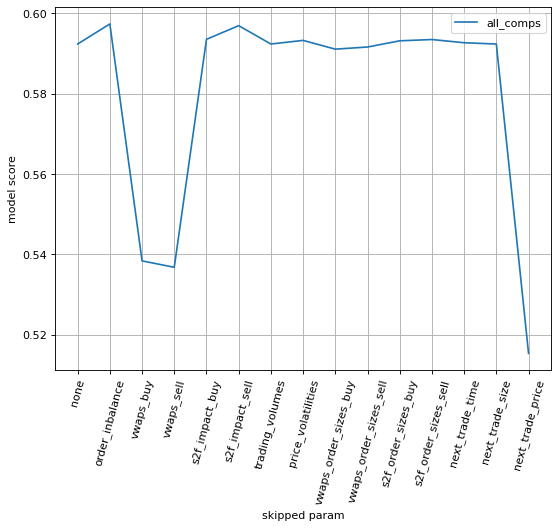

In [248]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
 ### LOG REg

In [249]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='change')
    scores[c,0]=decision_tree(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=decision_tree(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


Coefficient impact:
order_inbalance   0.14195302860699172
vwaps_buy   0.09600264223879337
vwaps_sell   0.0215880597351987
s2f_impact_buy   0.0557036304312448
s2f_impact_sell   0.07241594641587645
trading_volumes   0.06229189727526454
price_volatilities   0.009236353056021124
vwaps_order_sizes_buy   0.03662219655281618
vwaps_order_sizes_sell   0.017265981112897157
s2f_order_sizes_buy   0.02196015206914389
s2f_order_sizes_sell   0.01989595187446386
next_trade_time   0.14470872751935568
next_trade_size   0.13958207609034085
next_trade_price   0.1607733570215918
Coefficient impact:
order_inbalance   0.11499390369075985
vwaps_buy   0.0823066167548692
vwaps_sell   0.06345153622808179
s2f_impact_buy   0.057380496234832434
s2f_impact_sell   0.032637223974468006
trading_volumes   0.052324931207347464
price_volatilities   0.016127661970250066
vwaps_order_sizes_buy   0.059965032085029714
vwaps_order_sizes_sell   0.0356862837534734
s2f_order_sizes_buy   0.017019117916896333
s2f_order_sizes_sell   

Coefficient impact:
order_inbalance   0.18574918000252674
vwaps_buy   0.0719217335750039
vwaps_sell   0.06964217746040315
s2f_impact_buy   0.06147234488796084
s2f_impact_sell   0.08899780021337651
trading_volumes   0.06587549455265036
price_volatilities   0.013867368171439317
vwaps_order_sizes_buy   0.017926869890830414
vwaps_order_sizes_sell   0.021862084781415287
s2f_order_sizes_buy   0.023705169521849836
s2f_order_sizes_sell   0.03386842640914719
next_trade_time   0.09966519329627449
next_trade_size   0.1417227695368944
next_trade_price   0.10372338770022753
Coefficient impact:
order_inbalance   0.11667997781119575
vwaps_buy   0.06396406786746738
vwaps_sell   0.1388291361243043
s2f_impact_buy   0.06457471635582555
s2f_impact_sell   0.02944554677957654
trading_volumes   0.08955941257396963
price_volatilities   0.0
vwaps_order_sizes_buy   0.02683002918097128
vwaps_order_sizes_sell   0.058275880899498325
s2f_order_sizes_buy   0.038782736345351614
s2f_order_sizes_sell   0.02808449703193

Coefficient impact:
order_inbalance   0.12206137937478943
vwaps_buy   0.08062287888505122
vwaps_sell   0.05144600066411517
s2f_impact_buy   0.08593568448537683
s2f_impact_sell   0.08769260902001079
trading_volumes   0.06457247738550184
price_volatilities   0.004286859167200141
vwaps_order_sizes_buy   0.03754798409699063
vwaps_order_sizes_sell   0.0485001930099878
s2f_order_sizes_buy   0.03389104731932307
s2f_order_sizes_sell   0.030571653121857213
next_trade_time   0.1160623701577382
next_trade_size   0.10161612519994911
next_trade_price   0.13519273811210852
Coefficient impact:
order_inbalance   0.05327431340623715
vwaps_buy   0.0630098276218511
vwaps_sell   0.08575825558721302
s2f_impact_buy   0.08069244482499066
s2f_impact_sell   0.09260237850960822
trading_volumes   0.09716812025020242
price_volatilities   0.0
vwaps_order_sizes_buy   0.05245700722002763
vwaps_order_sizes_sell   0.019459960479023843
s2f_order_sizes_buy   0.04162260962843491
s2f_order_sizes_sell   0.02753015412248008

Coefficient impact:
order_inbalance   0.1347401587229805
vwaps_buy   0.06508096282002176
vwaps_sell   0.07525503836910323
s2f_impact_buy   0.02118389552833042
s2f_impact_sell   0.056625743734395634
trading_volumes   0.05084640093377618
price_volatilities   0.0034466416785144975
vwaps_order_sizes_buy   0.051362846520551474
vwaps_order_sizes_sell   0.07432504853481123
s2f_order_sizes_buy   0.03209685063116626
s2f_order_sizes_sell   0.03604771176333342
next_trade_time   0.1080218319395106
next_trade_size   0.12122472144799057
next_trade_price   0.16974214737551419
Coefficient impact:
order_inbalance   0.08971274125494187
vwaps_buy   0.09755670579468369
vwaps_sell   0.12094848395813351
s2f_impact_buy   0.023678624319198895
s2f_impact_sell   0.01922623961584993
trading_volumes   0.05384915673224104
price_volatilities   0.024798049292195146
vwaps_order_sizes_buy   0.028602138894276416
vwaps_order_sizes_sell   0.059443258886661174
s2f_order_sizes_buy   0.012698412698412702
s2f_order_sizes_sel

Coefficient impact:
order_inbalance   0.05722709707445483
vwaps_buy   0.22612094712475753
vwaps_sell   0.1396943347766812
s2f_impact_buy   0.0
s2f_impact_sell   0.008390083693844743
trading_volumes   0.05405505134800005
price_volatilities   0.07019659656993216
vwaps_order_sizes_buy   0.030199233757794902
vwaps_order_sizes_sell   0.01083277101332228
s2f_order_sizes_buy   0.018395530904069333
s2f_order_sizes_sell   0.004287162698290604
next_trade_time   0.02689431077254092
next_trade_size   0.08194856862722548
next_trade_price   0.27175831163908587
Coefficient impact:
order_inbalance   0.07812571536640014
vwaps_buy   0.08631184374707064
vwaps_sell   0.13796987580835784
s2f_impact_buy   0.05776677202129585
s2f_impact_sell   0.03389351870947763
trading_volumes   0.04073535479073508
price_volatilities   0.014765043299712692
vwaps_order_sizes_buy   0.027964875855113123
vwaps_order_sizes_sell   0.0339888327342208
s2f_order_sizes_buy   0.019263880338909717
s2f_order_sizes_sell   0.055598352976

Coefficient impact:
order_inbalance   0.12899289570123088
vwaps_buy   0.08332960738598268
vwaps_sell   0.06362791781016994
s2f_impact_buy   0.014541423455537179
s2f_impact_sell   0.03178147684639733
trading_volumes   0.08448955982327998
price_volatilities   0.09334447078804062
vwaps_order_sizes_buy   0.050222916644673134
vwaps_order_sizes_sell   0.046783047364697204
s2f_order_sizes_buy   0.00459320757844715
s2f_order_sizes_sell   0.0058508362117554655
next_trade_time   0.13568866689052828
next_trade_size   0.1130662568380003
next_trade_price   0.14368771666125985
Coefficient impact:
order_inbalance   0.17348253680021167
vwaps_buy   0.05392337398333857
vwaps_sell   0.0533140078794177
s2f_impact_buy   0.07224251763369374
s2f_impact_sell   0.028585368653203946
trading_volumes   0.08774773218775098
price_volatilities   0.020826428783472465
vwaps_order_sizes_buy   0.02989108373721622
vwaps_order_sizes_sell   0.07084221857858716
s2f_order_sizes_buy   0.04000781765485808
s2f_order_sizes_sell 

Coefficient impact:
order_inbalance   0.14094413208307469
vwaps_buy   0.06834463990563293
vwaps_sell   0.027478593349251092
s2f_impact_buy   0.026866402449538154
s2f_impact_sell   0.07820086017339224
trading_volumes   0.12337989840828388
price_volatilities   0.007107169881722198
vwaps_order_sizes_buy   0.042720767895866076
vwaps_order_sizes_sell   0.022508885034606775
s2f_order_sizes_buy   0.037354871936435274
s2f_order_sizes_sell   0.030550528218463546
next_trade_time   0.07381706323954973
next_trade_size   0.17780971921516717
next_trade_price   0.14291646820901618
Coefficient impact:
order_inbalance   0.14415612853188242
vwaps_buy   0.1057420484264402
vwaps_sell   0.05256076685553246
s2f_impact_buy   0.03900964207250144
s2f_impact_sell   0.012889401038854146
trading_volumes   0.09110613874562036
price_volatilities   0.0
vwaps_order_sizes_buy   0.06023760392059392
vwaps_order_sizes_sell   0.03668042295705633
s2f_order_sizes_buy   0.022902334255501047
s2f_order_sizes_sell   0.027208770

vwaps_order_sizes_sell   0.01759840959447136
s2f_order_sizes_buy   0.06459114004162908
s2f_order_sizes_sell   0.031194192907464627
next_trade_time   0.16370734810168844
next_trade_size   0.1793162620574197
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.09098046851802054
vwaps_sell   0.06164497983190637
s2f_impact_buy   0.06713664309146511
s2f_impact_sell   0.05188415674735321
trading_volumes   0.07672304819331656
price_volatilities   0.020954492672815874
vwaps_order_sizes_buy   0.05345755610107985
vwaps_order_sizes_sell   0.04663375195263181
s2f_order_sizes_buy   0.052543723436388044
s2f_order_sizes_sell   0.029388813389430914
next_trade_time   0.11147870774828739
next_trade_size   0.1569495288651106
next_trade_price   0.18022412945219368
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.15108406450736425
s2f_impact_buy   0.049987962150196054
s2f_impact_sell   0.04545416457508136
trading_volumes   0.05333551694589033
price_volatilities   0.11773517055136186
v

Coefficient impact:
s2f_order_sizes_sell   0.13464009895096946
next_trade_time   0.04327887277257941
next_trade_size   0.05023438569822048
next_trade_price   0.07254369042816822
order_inbalance   0.07224761518459642
vwaps_buy   0.12043786140324358
vwaps_sell   0.0035903002841336826
s2f_impact_buy   0.03844013885951374
s2f_impact_sell   0.014054499309946846
trading_volumes   0.04135684964999334
price_volatilities   0.16120068278692246
vwaps_order_sizes_buy   0.10831161230068499
vwaps_order_sizes_sell   0.13966339237102737
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.16211016228127237
next_trade_size   0.03081447750176609
next_trade_price   0.07166933328364701
order_inbalance   0.09940144647193204
vwaps_buy   0.06213720670261319
vwaps_sell   0.14518069428649955
s2f_impact_buy   0.00537010726259312
s2f_impact_sell   0.02319876683378898
trading_volumes   0.032179478387960446
price_volatilities   0.010484555422098238
vwaps_order_sizes_buy   0.1608370275636879
vwaps

Coefficient impact:
vwaps_order_sizes_buy   0.13118458025650984
vwaps_order_sizes_sell   0.04962715112777504
s2f_order_sizes_buy   0.04446877758369695
s2f_order_sizes_sell   0.0502316881194017
next_trade_time   0.08131695961601601
next_trade_size   0.04974070469821467
next_trade_price   0.051749648806278636
order_inbalance   0.02168742810001915
vwaps_buy   0.021354580625757198
vwaps_sell   0.08768485558358649
s2f_impact_buy   0.17004449974066185
s2f_impact_sell   0.1280079824333281
trading_volumes   0.11290114330875438
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.12791842527664518
s2f_order_sizes_buy   0.04133040391973749
s2f_order_sizes_sell   0.04707535226688453
next_trade_time   0.06070803428123172
next_trade_size   0.08934060826466465
next_trade_price   0.043666776697145394
order_inbalance   0.015009046574066731
vwaps_buy   0.035712357897941416
vwaps_sell   0.04930464847693483
s2f_impact_buy   0.08235496875490073
s2f_impact_sell   0.15972765318389587

Coefficient impact:
next_trade_time   0.15069600064039498
next_trade_size   0.061922466571867334
next_trade_price   0.11545431024183296
order_inbalance   0.011109783365726772
vwaps_buy   0.035884788505909405
vwaps_sell   0.06081218729780719
s2f_impact_buy   0.004187752869502845
s2f_impact_sell   0.06662649437273446
trading_volumes   0.04278928238667362
price_volatilities   0.030527181261884067
vwaps_order_sizes_buy   0.13422111638672535
vwaps_order_sizes_sell   0.09423772566339114
s2f_order_sizes_buy   0.19153091043554976
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.2223402251458215
next_trade_price   0.0822915668535194
order_inbalance   0.10613305185725197
vwaps_buy   0.03413130834525374
vwaps_sell   0.03869853635718642
s2f_impact_buy   0.05555205740740724
s2f_impact_sell   0.0
trading_volumes   0.04576796664986457
price_volatilities   0.048928101383433
vwaps_order_sizes_buy   0.03316498433550415
vwaps_order_sizes_sell   0.036946049591685605
s2f_order_sizes_

Coefficient impact:
s2f_impact_sell   0.13423698240987972
trading_volumes   0.08800073085013561
price_volatilities   0.08874272691002145
vwaps_order_sizes_buy   0.04956188062248514
vwaps_order_sizes_sell   0.10375102025932759
s2f_order_sizes_buy   0.005090574814588975
s2f_order_sizes_sell   0.03991820317303438
next_trade_time   0.03162640232516112
next_trade_size   0.018369047256236972
next_trade_price   0.02484994304735202
order_inbalance   0.12241668549294753
vwaps_buy   0.12090025328605766
vwaps_sell   0.1725355495527719
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.11166900000312889
price_volatilities   0.0816158082448956
vwaps_order_sizes_buy   0.08976349977559532
vwaps_order_sizes_sell   0.05863359120051649
s2f_order_sizes_buy   0.09883204692450698
s2f_order_sizes_sell   0.005090574814588975
next_trade_time   0.02733406517173115
next_trade_size   0.06910152180849312
next_trade_price   0.023878697445568472
order_inbalance   0.011436665570909853
vwaps_buy   0.10

vwaps_sell   0.07760993311871892
s2f_impact_buy   0.03747964912915781
s2f_impact_sell   0.06618242819967778
trading_volumes   0.08431188874032909
price_volatilities   0.007866240045466107
vwaps_order_sizes_buy   0.04436370429103027
vwaps_order_sizes_sell   0.05950925751195325
s2f_order_sizes_buy   0.035716065896929564
s2f_order_sizes_sell   0.04157599307720093
next_trade_time   0.13075784458854914
next_trade_size   0.13971189498077444
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.10748186650924578
vwaps_sell   0.07277995660085519
s2f_impact_buy   0.08361910685306678
s2f_impact_sell   0.030615342074714398
trading_volumes   0.06641170622109561
price_volatilities   0.0
vwaps_order_sizes_buy   0.09931444143283957
vwaps_order_sizes_sell   0.06141876237649546
s2f_order_sizes_buy   0.04516597392245061
s2f_order_sizes_sell   0.02805237454914455
next_trade_time   0.10825159360373027
next_trade_size   0.1260746163404165
next_trade_price   0.1708142595159453
skipped  order_inbalan

skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.14248831116929928
next_trade_size   0.044063707990370515
next_trade_price   0.09776791200129374
order_inbalance   0.023160956989391288
vwaps_buy   0.09901365127696526
vwaps_sell   0.08619680962107829
s2f_impact_buy   0.00442805854359506
s2f_impact_sell   0.02665969452073526
trading_volumes   0.06378309519488334
price_volatilities   0.012127981466643583
vwaps_order_sizes_buy   0.15258495875272562
vwaps_order_sizes_sell   0.14189632777095312
s2f_order_sizes_buy   0.10582853470206562
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.1730654250171382
next_trade_price   0.04473659840807808
order_inbalance   0.11290606985261449
vwaps_buy   0.0710493493442625
vwaps_sell   0.10700223506816942
s2f_impact_buy   0.0826906557949928
s2f_impact_sell   0.005600191687487871
trading_volumes   0.031932422895681586
price_volatilities   0.05750827773728653
vwaps_order_sizes_buy   0.008218379984305647
vwaps_order_s

next_trade_size   0.0741084397996356
next_trade_price   0.04074812879281285
order_inbalance   0.044011423395634346
vwaps_buy   0.015589882817649022
vwaps_sell   0.1151992220272581
s2f_impact_buy   0.13316992290218582
s2f_impact_sell   0.18698822506827836
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.1456874513046199
vwaps_order_sizes_sell   0.15470215388590408
s2f_order_sizes_buy   0.03576593444461522
s2f_order_sizes_sell   0.04089747821859413
next_trade_time   0.0515501825078007
next_trade_size   0.0864354174096384
next_trade_price   0.02296607959998205
order_inbalance   0.03052353811608256
vwaps_buy   0.0444313414142891
vwaps_sell   0.02479754226107993
s2f_impact_buy   0.09194176891466538
s2f_impact_sell   0.09049729264553366
trading_volumes   0.1798038192771948
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.154317891088824
s2f_order_sizes_buy   0.15447064701989785
s2f_order_sizes_sell   0.03361799640974428
next_trade_time   0.

vwaps_buy   0.09200667475637526
vwaps_sell   0.07018476819386163
s2f_impact_buy   0.08331176828324595
s2f_impact_sell   0.10060855122201048
trading_volumes   0.08543413360958037
price_volatilities   0.0
vwaps_order_sizes_buy   0.03149861592221755
vwaps_order_sizes_sell   0.041651415386621767
s2f_order_sizes_buy   0.03883228658875372
s2f_order_sizes_sell   0.04229496943248986
next_trade_time   0.13818894184593303
next_trade_size   0.11572448980109022
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.026377831775987834
vwaps_sell   0.11199314201137611
s2f_impact_buy   0.022514607429359814
s2f_impact_sell   0.06227943625975547
trading_volumes   0.12052165412457444
price_volatilities   0.028597482229607125
vwaps_order_sizes_buy   0.027943587697260883
vwaps_order_sizes_sell   0.056005415539010985
s2f_order_sizes_buy   0.009836345945396261
s2f_order_sizes_sell   0.04591706559368024
next_trade_time   0.15110860296504103
next_trade_size   0.15926404553940837
next_trade_price   0.17

skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.1785755109468203
s2f_impact_sell   0.07441401747667414
trading_volumes   0.056328645002177845
price_volatilities   0.10226318617845975
vwaps_order_sizes_buy   0.07644578421008885
vwaps_order_sizes_sell   0.011103917608620338
s2f_order_sizes_buy   0.0145422622011285
s2f_order_sizes_sell   0.031605399707325135
next_trade_time   0.023921151752196022
next_trade_size   0.02858402191358124
next_trade_price   0.10702517832782815
order_inbalance   0.172471310178261
vwaps_buy   0.12271961449683876
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.1678250657641511
trading_volumes   0.07713411228018908
price_volatilities   0.06084052375042312
vwaps_order_sizes_buy   0.06648211830953807
vwaps_order_sizes_sell   0.09092673574547538
s2f_order_sizes_buy   0.019836705623483414
s2f_order_sizes_sell   0.018604247581787702
next_trade_time   0.026897556208914923
next_trade_size   0.026328889722658646
next_trade_price   0.0381513734062

Coefficient impact:
vwaps_order_sizes_buy   0.13034143073273174
vwaps_order_sizes_sell   0.07205719757167098
s2f_order_sizes_buy   0.11894429655623656
s2f_order_sizes_sell   0.056262853416373236
next_trade_time   0.052164638814079595
next_trade_size   0.05840947904826814
next_trade_price   0.022354415878730854
order_inbalance   0.053793778256827095
vwaps_buy   0.03465261811456785
vwaps_sell   0.04492531153529937
s2f_impact_buy   0.09604207737353489
s2f_impact_sell   0.07671752109629307
trading_volumes   0.18333438160538665
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.1339774842949003
s2f_order_sizes_buy   0.07481607702717206
s2f_order_sizes_sell   0.12891019938890325
next_trade_time   0.06240394523400696
next_trade_size   0.024604251172737648
next_trade_price   0.10425814321282162
order_inbalance   0.0065619970574623725
vwaps_buy   0.05158998308887992
vwaps_sell   0.04847657892483547
s2f_impact_buy   0.03352158030812042
s2f_impact_sell   0.08091823653633

vwaps_sell   0.1062601217215794
s2f_impact_buy   0.04352726661713986
s2f_impact_sell   0.06787319776068165
trading_volumes   0.11334958615165755
price_volatilities   0.009972319397188125
vwaps_order_sizes_buy   0.016518270814428974
vwaps_order_sizes_sell   0.053995750936355606
s2f_order_sizes_buy   0.025933495715515537
s2f_order_sizes_sell   0.05887721246690516
next_trade_time   0.1263153976575996
next_trade_size   0.11993606561411971
next_trade_price   0.18810176925080996
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.14793679285157119
s2f_impact_buy   0.06489708276174415
s2f_impact_sell   0.049905540240731835
trading_volumes   0.037322325187624926
price_volatilities   0.09087156294829499
vwaps_order_sizes_buy   0.011285127043901892
vwaps_order_sizes_sell   0.03859996024857452
s2f_order_sizes_buy   0.049516477051196536
s2f_order_sizes_sell   0.05565896971778689
next_trade_time   0.011979831425216862
next_trade_size   0.14715953086386635
next_trade_price   0.137100439793

Coefficient impact:
s2f_impact_sell   0.17614551724204244
trading_volumes   0.062202790682016514
price_volatilities   0.06719004132547626
vwaps_order_sizes_buy   0.047689712765507986
vwaps_order_sizes_sell   0.08481551854168091
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.04775975259407835
next_trade_time   0.02982272634480759
next_trade_size   0.027080605444495396
next_trade_price   0.04274443619126611
order_inbalance   0.1327965998805725
vwaps_buy   0.12900421949501834
vwaps_sell   0.15274807949303754
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.14502809824228136
price_volatilities   0.0618510988978227
vwaps_order_sizes_buy   0.06909587483543174
vwaps_order_sizes_sell   0.03154858489283956
s2f_order_sizes_buy   0.06545081099522411
s2f_order_sizes_sell   0.007183239711411238
next_trade_time   0.03888264832328237
next_trade_size   0.054109782202595505
next_trade_price   0.029399998916248154
order_inbalance   0.06037927715432247
vwaps_buy   0.11862322134779996

vwaps_order_sizes_buy   0.07148788539553588
vwaps_order_sizes_sell   0.04021300759145926
s2f_order_sizes_buy   0.01876751612119256
s2f_order_sizes_sell   0.03851842953407868
next_trade_time   0.1700433294140479
next_trade_size   0.13713469099106673
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.08203304121385263
vwaps_sell   0.12849606623324827
s2f_impact_buy   0.03927790251068559
s2f_impact_sell   0.03381969980211314
trading_volumes   0.06361177288583882
price_volatilities   0.014418911907031389
vwaps_order_sizes_buy   0.053990638696178886
vwaps_order_sizes_sell   0.02983880599821385
s2f_order_sizes_buy   0.009502809724990803
s2f_order_sizes_sell   0.01692299175580618
next_trade_time   0.1234010094418213
next_trade_size   0.16923818798705229
next_trade_price   0.23544816184316697
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.16935782778419015
s2f_impact_buy   0.07562866567624897
s2f_impact_sell   0.031018732294424145
trading_volumes   0.0461132117433726


Coefficient impact:
s2f_order_sizes_sell   0.22717576725696967
next_trade_time   0.10740629568507949
next_trade_size   0.08776980456431
next_trade_price   0.0347916206962514
order_inbalance   0.01998900631052397
vwaps_buy   0.117211550086936
vwaps_sell   0.007583869978835182
s2f_impact_buy   0.05869315073393798
s2f_impact_sell   0.02084735405930622
trading_volumes   0.0347749978358003
price_volatilities   0.07366341338619865
vwaps_order_sizes_buy   0.10691212131584361
vwaps_order_sizes_sell   0.10318104809000765
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.23077435540716723
next_trade_size   0.05931112362711778
next_trade_price   0.0507752644022621
order_inbalance   0.05927501697779599
vwaps_buy   0.03703241444988278
vwaps_sell   0.17133389263154267
s2f_impact_buy   0.0023621890098011232
s2f_impact_sell   0.05952213145818824
trading_volumes   0.017453952127974955
price_volatilities   0.019069819572264928
vwaps_order_sizes_buy   0.09087738632728894
vwaps_order_

next_trade_size   0.03790569823846405
next_trade_price   0.03416796449019677
order_inbalance   0.12240041189247278
vwaps_buy   0.10427699150837036
vwaps_sell   0.14029519331332566
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.1251067190235308
price_volatilities   0.08163987581116915
vwaps_order_sizes_buy   0.03951561555349676
vwaps_order_sizes_sell   0.07506944799148169
s2f_order_sizes_buy   0.1272442234873825
s2f_order_sizes_sell   0.04935258261377046
next_trade_time   0.04098482554317424
next_trade_size   0.03387985513290231
next_trade_price   0.043061776723221486
order_inbalance   0.030895265097903662
vwaps_buy   0.09953210396002592
vwaps_sell   0.09684038045463707
s2f_impact_buy   0.1568773286073038
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.13678627857597733
vwaps_order_sizes_buy   0.09854851799224858
vwaps_order_sizes_sell   0.059659513319411626
s2f_order_sizes_buy   0.06346196293427106
s2f_order_sizes_sell   0.01915798778971795
next

Coefficient impact:
next_trade_price   0.10992040803173328
order_inbalance   0.19010766989943026
vwaps_buy   0.08372729204663237
vwaps_sell   0.03553209979506376
s2f_impact_buy   0.015938331486762908
s2f_impact_sell   0.07938060445116868
trading_volumes   0.007830825297972601
price_volatilities   0.06482932976832174
vwaps_order_sizes_buy   0.03497171159407231
vwaps_order_sizes_sell   0.027732535058586354
s2f_order_sizes_buy   0.009762766856855488
s2f_order_sizes_sell   0.12314925456640768
next_trade_time   0.2171171711469926
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.20149621451540817
vwaps_buy   0.11901707594509438
vwaps_sell   0.032081805457883625
s2f_impact_buy   0.09515683699847112
s2f_impact_sell   0.021143375971764675
trading_volumes   0.06511314496294965
price_volatilities   0.006761170031149429
vwaps_order_sizes_buy   0.07947601455201732
vwaps_order_sizes_sell   0.05856850086600944
s2f_order_sizes_buy   0.03382666856275624
s2f_order_sizes_sell   0.0
next

Coefficient impact:
vwaps_order_sizes_sell   0.09146877264718944
s2f_order_sizes_buy   0.08806077972183604
s2f_order_sizes_sell   0.08331163019806431
next_trade_time   0.05935529235937645
next_trade_size   0.02710584316882228
next_trade_price   0.05202618236958353
order_inbalance   0.07489125766968864
vwaps_buy   0.018963408759757897
vwaps_sell   0.04054279744123507
s2f_impact_buy   0.006512174245711444
s2f_impact_sell   0.11670340760706739
trading_volumes   0.13605409884763933
price_volatilities   0.20500435496402836
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.14097234218218888
s2f_order_sizes_sell   0.08981619051644767
next_trade_time   0.05444483442619428
next_trade_size   0.08279075171766445
next_trade_price   0.0034896561540775023
order_inbalance   0.0625683225366932
vwaps_buy   0.05687507433483425
vwaps_sell   0.03888257658308889
s2f_impact_buy   0.03619271954086096
s2f_impact_sell   0.012139910342700982
trading_volumes   0.08896417647547292
price

Coefficient impact:
trading_volumes   0.11838865362098715
price_volatilities   0.12428887755051571
vwaps_order_sizes_buy   0.07929061443631769
vwaps_order_sizes_sell   0.03259275696640504
s2f_order_sizes_buy   0.06885059965548888
s2f_order_sizes_sell   0.0
next_trade_time   0.031854345977620734
next_trade_size   0.05256564036528858
next_trade_price   0.03208808315408091
order_inbalance   0.02022926400452861
vwaps_buy   0.09183267840890118
vwaps_sell   0.1091317924435853
s2f_impact_buy   0.2388866934162802
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.10381637883617195
vwaps_order_sizes_buy   0.09006941749743556
vwaps_order_sizes_sell   0.06086417204308806
s2f_order_sizes_buy   0.02670624828390115
s2f_order_sizes_sell   0.051864201956130916
next_trade_time   0.0
next_trade_size   0.03195493466825134
next_trade_price   0.0854006908112282
order_inbalance   0.052425972444903345
vwaps_buy   0.029236555012585888
vwaps_sell   0.12357907625278844
s2f_impact_buy   0.1658

skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.11959973154308619
vwaps_buy   0.0815588914994488
vwaps_sell   0.11474055402319008
s2f_impact_buy   0.06408772181036299
s2f_impact_sell   0.06970212296508607
trading_volumes   0.09676770445800235
price_volatilities   0.0035405373998056724
vwaps_order_sizes_buy   0.03293680748521746
vwaps_order_sizes_sell   0.03352402216805704
s2f_order_sizes_buy   0.04578415913327042
s2f_order_sizes_sell   0.0508194767035715
next_trade_time   0.1459891402218451
next_trade_size   0.1409491305890563
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.07814182348948524
vwaps_sell   0.10361391470460835
s2f_impact_buy   0.05587048056088251
s2f_impact_sell   0.0833526458759289
trading_volumes   0.09695186996877256
price_volatilities   0.0
vwaps_order_sizes_buy   0.05855094680789922
vwaps_order_sizes_sell   0.030755365596022627
s2f_order_sizes_buy   0.03256682980253582
s2f_order_sizes_sell   0.01722384873171371
next_trade_time   0.105

vwaps_sell   0.0338959381624943
s2f_impact_buy   0.04450039673131762
s2f_impact_sell   0.16275888153181578
trading_volumes   0.12160367124314643
price_volatilities   0.20566348247846575
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.13259320741999933
s2f_order_sizes_sell   0.03337660810151501
next_trade_time   0.10156858348833833
next_trade_size   0.01973793696531648
next_trade_price   0.07338040672971897
order_inbalance   0.0640538173853665
vwaps_buy   0.019679617046022134
vwaps_sell   0.012492814367010873
s2f_impact_buy   0.02944995224376608
s2f_impact_sell   0.0492487419061399
trading_volumes   0.15198872248811485
price_volatilities   0.11385011320347194
vwaps_order_sizes_buy   0.19857947865521958
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.12327522159263685
next_trade_time   0.020089613708617334
next_trade_size   0.08152394019365321
next_trade_price   0.010138870937630145
order_inbalance   0.0794571334873866
vwaps_buy

next_trade_time   0.038329621393104876
next_trade_size   0.016131208263632117
next_trade_price   0.13890556774804794
order_inbalance   0.17023739738407592
vwaps_buy   0.1472045742925039
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.20629648562834607
trading_volumes   0.08101465478686101
price_volatilities   0.016895628198048115
vwaps_order_sizes_buy   0.06581944679456225
vwaps_order_sizes_sell   0.06360173223899102
s2f_order_sizes_buy   0.02229644046710891
s2f_order_sizes_sell   0.005209082995771047
next_trade_time   0.037994109043923675
next_trade_size   0.04052558509194234
next_trade_price   0.022701907679956723
order_inbalance   0.16395304555012982
vwaps_buy   0.14586939363097584
vwaps_sell   0.12782248789338313
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.17985731110008257
price_volatilities   0.04130560963462209
vwaps_order_sizes_buy   0.04624535341935262
vwaps_order_sizes_sell   0.09266107069916282
s2f_order_sizes_buy   0.0297464596269391
s2f_

trading_volumes   0.05875944319071129
price_volatilities   0.024221713083891816
vwaps_order_sizes_buy   0.10660202598231194
vwaps_order_sizes_sell   0.10341758090069134
s2f_order_sizes_buy   0.11017934834371464
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.1459691221117807
next_trade_price   0.05075026286360669
order_inbalance   0.10544347270208862
vwaps_buy   0.036911551855732444
vwaps_sell   0.08509587279213904
s2f_impact_buy   0.10777517985332521
s2f_impact_sell   0.030981186165745522
trading_volumes   0.06760642775851125
price_volatilities   0.045066012817892034
vwaps_order_sizes_buy   0.005874391090163316
vwaps_order_sizes_sell   0.035835462760894284
s2f_order_sizes_buy   0.14925640246839955
s2f_order_sizes_sell   0.1334346547597213
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.13140702351811032
order_inbalance   0.05466038098022955
vwaps_buy   0.10721530059971796
vwaps_sell   0.07278366997666814
s2f_impact_buy   0.08012009881820228


Coefficient impact:
vwaps_order_sizes_sell   0.13248348689918793
s2f_order_sizes_buy   0.05686341826279697
s2f_order_sizes_sell   0.08539095426450202
next_trade_time   0.03759816073030521
next_trade_size   0.05979171484424508
next_trade_price   0.049893052688663266
order_inbalance   0.0
vwaps_buy   0.059356243904018176
vwaps_sell   0.0500069715055787
s2f_impact_buy   0.0537063300299347
s2f_impact_sell   0.09295260728266738
trading_volumes   0.13046286168061633
price_volatilities   0.19149419790748437
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.12611571896003732
s2f_order_sizes_sell   0.03893827576563382
next_trade_time   0.050827584631291244
next_trade_size   0.05380647420573676
next_trade_price   0.09595974410974235
order_inbalance   0.09044822783055424
vwaps_buy   0.016810424355380223
vwaps_sell   0.015850247439791004
s2f_impact_buy   0.029604478320434884
s2f_impact_sell   0.09730544227985474
trading_volumes   0.1360486786031362
price_volatilities   0

Coefficient impact:
vwaps_buy   0.08092041196925001
vwaps_sell   0.10220424063718278
s2f_impact_buy   0.06092604185812562
s2f_impact_sell   0.07709336971732926
trading_volumes   0.046728352622966846
price_volatilities   0.039422426105932856
vwaps_order_sizes_buy   0.02323495790489074
vwaps_order_sizes_sell   0.046255460075319985
s2f_order_sizes_buy   0.03947845559979122
s2f_order_sizes_sell   0.031045027694724333
next_trade_time   0.11628263986058966
next_trade_size   0.11855084129224672
next_trade_price   0.2178577746616499
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.12273580303508018
s2f_impact_buy   0.08257849980429444
s2f_impact_sell   0.05601583914255912
trading_volumes   0.0661196638864835
price_volatilities   0.05628264386266034
vwaps_order_sizes_buy   0.03064329712323459
vwaps_order_sizes_sell   0.054651560037130856
s2f_order_sizes_buy   0.021015667229510426
s2f_order_sizes_sell   0.028907711646883397
next_trade_time   0.04907873431665471
next_trade_size   0.1

skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.19131147295860146
next_trade_time   0.08318337658606996
next_trade_size   0.049040160037068625
next_trade_price   0.05640488830802844
order_inbalance   0.03622936576896287
vwaps_buy   0.0902529041991159
vwaps_sell   0.0060938033350973276
s2f_impact_buy   0.06142996029621309
s2f_impact_sell   0.021326375755446964
trading_volumes   0.014520486013190231
price_volatilities   0.13277868292820239
vwaps_order_sizes_buy   0.12389328548596207
vwaps_order_sizes_sell   0.13353523832804068
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.21271559020785133
next_trade_size   0.0697852799209307
next_trade_price   0.023928665943127828
order_inbalance   0.041988760731506966
vwaps_buy   0.039702375489266466
vwaps_sell   0.08698185784961396
s2f_impact_buy   0.008125071113463103
s2f_impact_sell   0.02602732927567198
trading_volumes   0.02616572646056574
price_volatilities   0.02931008564722491
vwaps_order_

Coefficient impact:
price_volatilities   0.12343226704223256
vwaps_order_sizes_buy   0.10827247494282721
vwaps_order_sizes_sell   0.041408918153679426
s2f_order_sizes_buy   0.0751722848236309
s2f_order_sizes_sell   0.025358307789989983
next_trade_time   0.02124911561307701
next_trade_size   0.02708849755094076
next_trade_price   0.011568223276322717
order_inbalance   0.03225260476248984
vwaps_buy   0.0648664681278844
vwaps_sell   0.13211636448600844
s2f_impact_buy   0.18615536483232462
s2f_impact_sell   0.15105910859859223
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.13407359435487606
vwaps_order_sizes_sell   0.09538076300369416
s2f_order_sizes_buy   0.02772758266753377
s2f_order_sizes_sell   0.08055166476349446
next_trade_time   0.028490101019727692
next_trade_size   0.07239972472631626
next_trade_price   0.016072739586951462
order_inbalance   0.01560079317254461
vwaps_buy   0.03423889651087728
vwaps_sell   0.03612122256934853
s2f_impact_buy   0.12523397991

Coefficient impact:
s2f_impact_buy   0.1792307544106748
s2f_impact_sell   0.0348474048053725
trading_volumes   0.0271246177721849
price_volatilities   0.032066937201069005
vwaps_order_sizes_buy   0.07449302151872379
vwaps_order_sizes_sell   0.014289974805088335
s2f_order_sizes_buy   0.019313463461454697
s2f_order_sizes_sell   0.048903306492541466
next_trade_time   0.0430148630907358
next_trade_size   0.02622494416370824
next_trade_price   0.19371623554671788
order_inbalance   0.1601495718051926
vwaps_buy   0.146624904926536
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.18977360896773846
trading_volumes   0.050830761735175416
price_volatilities   0.06316158505677477
vwaps_order_sizes_buy   0.04521501326218883
vwaps_order_sizes_sell   0.05816048463479935
s2f_order_sizes_buy   0.006261767193851845
s2f_order_sizes_sell   0.022236509060477385
next_trade_time   0.08990017588860773
next_trade_size   0.04537758121582012
next_trade_price   0.011734269384885124
order_inbalance   

Coefficient impact:
vwaps_buy   0.10422067392906469
vwaps_sell   0.14396481605816275
s2f_impact_buy   0.037459268343574416
s2f_impact_sell   0.02900245533480967
trading_volumes   0.0852369443097645
price_volatilities   0.005271371597017512
vwaps_order_sizes_buy   0.033611670099442624
vwaps_order_sizes_sell   0.06806270757296423
s2f_order_sizes_buy   0.0213129848165169
s2f_order_sizes_sell   0.021477460173489303
next_trade_time   0.09930360573086337
next_trade_size   0.061832425936098945
next_trade_price   0.289243616098231
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.1341526644541227
s2f_impact_buy   0.10743673961817964
s2f_impact_sell   0.03253988021111308
trading_volumes   0.044614648861191486
price_volatilities   0.07594153797832943
vwaps_order_sizes_buy   0.0077473188622833155
vwaps_order_sizes_sell   0.017501871401198493
s2f_order_sizes_buy   0.08116281427844887
s2f_order_sizes_sell   0.05594055026186509
next_trade_time   0.03068729355533586
next_trade_size   0.11

Coefficient impact:
s2f_order_sizes_sell   0.20201273768866673
next_trade_time   0.05668785499496941
next_trade_size   0.09949766852119317
next_trade_price   0.04307917673526885
order_inbalance   0.06655270587272294
vwaps_buy   0.05280088249587247
vwaps_sell   0.009944014547903252
s2f_impact_buy   0.03980497722049752
s2f_impact_sell   0.07084601787751402
trading_volumes   0.03039368977272984
price_volatilities   0.07645717351619857
vwaps_order_sizes_buy   0.15970446674659658
vwaps_order_sizes_sell   0.09221863400986675
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.21076605501994922
next_trade_size   0.054544435405919335
next_trade_price   0.09133810625269553
order_inbalance   0.045093991148975894
vwaps_buy   0.06316090675332311
vwaps_sell   0.058541164290547475
s2f_impact_buy   0.01508822156162339
s2f_impact_sell   0.025107104076528622
trading_volumes   0.09178348002548929
price_volatilities   0.029962082645989676
vwaps_order_sizes_buy   0.07752092956935693
vwa

s2f_order_sizes_buy   0.0625539687003905
s2f_order_sizes_sell   0.00797828018197827
next_trade_time   0.053471088611798355
next_trade_size   0.022907349294133166
next_trade_price   0.06249180081661889
order_inbalance   0.02591209941922277
vwaps_buy   0.10159214969828675
vwaps_sell   0.1605867765212733
s2f_impact_buy   0.16173464656867934
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.12785386606964425
vwaps_order_sizes_buy   0.04555384155187447
vwaps_order_sizes_sell   0.05754213914188813
s2f_order_sizes_buy   0.06060737949551639
s2f_order_sizes_sell   0.08048161916705092
next_trade_time   0.0039664745222903345
next_trade_size   0.057981908746359376
next_trade_price   0.030765432239425385
order_inbalance   0.06949973020997989
vwaps_buy   0.04562411741095844
vwaps_sell   0.1026306476644665
s2f_impact_buy   0.1776707653191493
s2f_impact_sell   0.13982207846139658
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.15406814715358058
vwaps_order_

price_volatilities   0.028788102631102427
vwaps_order_sizes_buy   0.044580467887459896
vwaps_order_sizes_sell   0.033140373937559475
s2f_order_sizes_buy   0.06791192846983361
s2f_order_sizes_sell   0.16992344193029704
next_trade_time   0.13574888746376873
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.196780134665331
vwaps_buy   0.05222519284797822
vwaps_sell   0.04119247919863945
s2f_impact_buy   0.036491601031868375
s2f_impact_sell   0.03504110022162643
trading_volumes   0.09350436365100068
price_volatilities   0.07509589012893121
vwaps_order_sizes_buy   0.014123185562965868
vwaps_order_sizes_sell   0.058715523613349876
s2f_order_sizes_buy   0.044896210330508474
s2f_order_sizes_sell   0.04247787456366493
next_trade_time   0.16301394369391806
next_trade_size   0.1464425004902174
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.09458917618110951
vwaps_sell   0.07685459235496445
s2f_impact_buy   0.05924183034175145
s2f_impact_sell   0.0637654371997902
tr

vwaps_sell   0.06464726933020158
s2f_impact_buy   0.010307477288609363
s2f_impact_sell   0.13612206786718595
trading_volumes   0.11906305433298658
price_volatilities   0.16314061811219463
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.11122236745827757
s2f_order_sizes_sell   0.08433658203485112
next_trade_time   0.10418541450741349
next_trade_size   0.07901495266087652
next_trade_price   0.03231508511241557
order_inbalance   0.07760766360668475
vwaps_buy   0.011829640516918326
vwaps_sell   0.03390899609272482
s2f_impact_buy   0.042562578329970166
s2f_impact_sell   0.018916214133719324
trading_volumes   0.14596982707337916
price_volatilities   0.07213712337398476
vwaps_order_sizes_buy   0.18599355509878446
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.08507079331504716
next_trade_time   0.1144721151967913
next_trade_size   0.11481867593951849
next_trade_price   0.06006095644802231
order_inbalance   0.02771450299197247
vwaps_

Coefficient impact:
trading_volumes   0.09610996271550926
price_volatilities   0.06378175020626915
vwaps_order_sizes_buy   0.21213420268154087
vwaps_order_sizes_sell   0.0
s2f_order_sizes_buy   0.03974171433686093
s2f_order_sizes_sell   0.10051800924162099
next_trade_time   0.034251849318667246
next_trade_size   0.07339111649046534
next_trade_price   0.0026130667088424793
order_inbalance   0.024719780092571936
vwaps_buy   0.04775571015365093
vwaps_sell   0.10217128701905318
s2f_impact_buy   0.20281155103494755
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.07820118580278913
vwaps_order_sizes_buy   0.08091027021127095
vwaps_order_sizes_sell   0.23930366032860406
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.00501708808097756
next_trade_time   0.09654997581960481
next_trade_size   0.04818878397928387
next_trade_price   0.06415720073045106
order_inbalance   0.0
vwaps_buy   0.02890068682671991
vwaps_sell   0.0503775646484127
s2f_impact_buy   0.09376115509846646


next_trade_time   0.024448755989590842
next_trade_size   0.014808612440191389
next_trade_price   0.09219931404914315
order_inbalance   0.09523832938239604
vwaps_buy   0.2291303519618874
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.04203629538122972
trading_volumes   0.10531200065131635
price_volatilities   0.14358718362021905
vwaps_order_sizes_buy   0.03760191281863108
vwaps_order_sizes_sell   0.06456821632749875
s2f_order_sizes_buy   0.061394275249584525
s2f_order_sizes_sell   0.03065807088205151
next_trade_time   0.06107026247419301
next_trade_size   0.014624194586082067
next_trade_price   0.013895864062069057
order_inbalance   0.05578403910929547
vwaps_buy   0.07921047753978448
vwaps_sell   0.2902572072980449
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   0.03745688900615771
price_volatilities   0.10816177742299464
vwaps_order_sizes_buy   0.14841174502372786
vwaps_order_sizes_sell   0.009278752436647171
s2f_order_sizes_buy   0.05919114294887916
s2f_

skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.09783433180697419
next_trade_size   0.14231295817539572
next_trade_price   0.08399665605988878
order_inbalance   0.003497436747015674
vwaps_buy   0.007443868752094174
vwaps_sell   0.038734004750647505
s2f_impact_buy   0.11299822696885807
s2f_impact_sell   0.06596214134335675
trading_volumes   0.015269787114260828
price_volatilities   0.004721539608471162
vwaps_order_sizes_buy   0.07838658063179024
vwaps_order_sizes_sell   0.12340134220410102
s2f_order_sizes_buy   0.22544112583714582
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.09362141307410304
next_trade_price   0.14967385129435828
order_inbalance   0.08651737700933221
vwaps_buy   0.0
vwaps_sell   0.007443868752094174
s2f_impact_buy   0.05481874720251685
s2f_impact_sell   0.12880275069969968
trading_volumes   0.08554770243972933
price_volatilities   0.02627876414748062
vwaps_order_sizes_buy   0.006716668298246011
vwaps_order_sizes_sell   

Coefficient impact:
price_volatilities   0.08056446197725511
vwaps_order_sizes_buy   0.12494994130707043
vwaps_order_sizes_sell   0.15029927810952112
s2f_order_sizes_buy   0.008836235109307504
s2f_order_sizes_sell   0.010169806259292615
next_trade_time   0.07728346770220622
next_trade_size   0.03121991748224171
next_trade_price   0.04695937650334396
order_inbalance   0.004071997746224656
vwaps_buy   0.04063251907878774
vwaps_sell   0.05641134564187958
s2f_impact_buy   0.048124351833891674
s2f_impact_sell   0.3204773012489776
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.09545010976485904
vwaps_order_sizes_sell   0.0978471860539262
s2f_order_sizes_buy   0.14883289846191564
s2f_order_sizes_sell   0.006218091373216394
next_trade_time   0.00928713764163431
next_trade_size   0.08616948899848663
next_trade_price   0.04356151536689324
order_inbalance   0.03217736949745165
vwaps_buy   0.0037235822024406914
vwaps_sell   0.02710544310898367
s2f_impact_buy   0.092231062

s2f_order_sizes_buy   0.03049891561397545
s2f_order_sizes_sell   0.016766532704348417
next_trade_time   0.04755204530792006
next_trade_size   0.0737720079164828
next_trade_price   0.13181634151763508
order_inbalance   0.23389017110221305
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.11968724474362519
s2f_impact_sell   0.07876494891185334
trading_volumes   0.08865429178190926
price_volatilities   0.07241896222989799
vwaps_order_sizes_buy   0.09087658703831382
vwaps_order_sizes_sell   0.0
s2f_order_sizes_buy   0.018900354265076594
s2f_order_sizes_sell   0.044286016352033844
next_trade_time   0.0390192532806356
next_trade_size   0.04319600067110427
next_trade_price   0.09756257605852398
order_inbalance   0.10228832438060294
vwaps_buy   0.20434544028642318
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.10837439143625742
trading_volumes   0.12458816437633241
price_volatilities   0.13257331533685754
vwaps_order_sizes_buy   0.045869707712944414
vwaps_order_sizes_s

Coefficient impact:
order_inbalance   0.21452070192344208
vwaps_buy   0.05947601566819095
vwaps_sell   0.09588429810023226
s2f_impact_buy   0.0208363413845974
s2f_impact_sell   0.02746905720884631
trading_volumes   0.15953947744044758
price_volatilities   0.10005715603212727
vwaps_order_sizes_buy   0.047142363681092196
vwaps_order_sizes_sell   0.0841752605381592
s2f_order_sizes_buy   0.017083583121004116
s2f_order_sizes_sell   0.018314952315990823
next_trade_time   0.059029013269544316
next_trade_size   0.09647177931632557
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.09991382054090935
vwaps_sell   0.1267648066556402
s2f_impact_buy   0.0315194089792265
s2f_impact_sell   0.02779909060317003
trading_volumes   0.08028014803240288
price_volatilities   0.023064877268238308
vwaps_order_sizes_buy   0.0707640176542775
vwaps_order_sizes_sell   0.044597579641626396
s2f_order_sizes_buy   0.00407169080369934
s2f_order_sizes_sell   0.016148123825448266
next_trade_time   0.0655700461

skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.10561715767806404
next_trade_price   0.09412683079486123
order_inbalance   0.10487609768121872
vwaps_buy   0.0039370894548167185
vwaps_sell   0.006601584338379548
s2f_impact_buy   0.09523465257628835
s2f_impact_sell   0.09087550631207134
trading_volumes   0.02436184257691917
price_volatilities   0.04444740117360768
vwaps_order_sizes_buy   0.029207554405536386
vwaps_order_sizes_sell   0.018389510969150275
s2f_order_sizes_buy   0.13419656119118853
s2f_order_sizes_sell   0.248128210847898
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.15301027142938384
order_inbalance   0.04952277137419615
vwaps_buy   0.0973724595818106
vwaps_sell   0.009113632997260923
s2f_impact_buy   0.02714497597582424
s2f_impact_sell   0.09664325202719933
trading_volumes   0.10684486565710614
price_volatilities   0.04309471232970529
vwaps_order_sizes_buy   0.08962191741044608
vwaps_order_sizes_sell   0.017298390561818075
s2f_

Coefficient impact:
s2f_order_sizes_buy   0.10843731441027189
s2f_order_sizes_sell   0.15337377911262826
next_trade_time   0.036073385430969225
next_trade_size   0.007447240120201069
next_trade_price   0.023198225559612685
order_inbalance   0.08043022549855147
vwaps_buy   0.06213459245361239
vwaps_sell   0.040840873791357264
s2f_impact_buy   0.040012285184280384
s2f_impact_sell   0.038890557644876915
trading_volumes   0.08278890279060283
price_volatilities   0.1494519144906484
vwaps_order_sizes_buy   0.1769207035123873
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.09827717847823168
next_trade_time   0.17070103786222968
next_trade_size   0.03067304756602809
next_trade_price   0.026505064525185133
order_inbalance   0.015903715375312464
vwaps_buy   0.0655288542642755
vwaps_sell   0.05571154751291245
s2f_impact_buy   0.03568299007015398
s2f_impact_sell   0.047446509303699404
trading_volumes   0.03697430872505909
price_volatilities   0.07189666919573423
vwap

Coefficient impact:
trading_volumes   0.12373407617789553
price_volatilities   0.08155825624250007
vwaps_order_sizes_buy   0.061020965519182686
vwaps_order_sizes_sell   0.02695102790849746
s2f_order_sizes_buy   0.1314175650290265
s2f_order_sizes_sell   0.10801711512853447
next_trade_time   0.027303304750662092
next_trade_size   0.04982898001401289
next_trade_price   0.03197919933352372
order_inbalance   0.023124279814394983
vwaps_buy   0.08115783111286301
vwaps_sell   0.08935861196112568
s2f_impact_buy   0.16454878700778075
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.07530122969204008
vwaps_order_sizes_buy   0.12898499904575694
vwaps_order_sizes_sell   0.1184022027306672
s2f_order_sizes_buy   0.026695355373498094
s2f_order_sizes_sell   0.011487503707890374
next_trade_time   0.11181343128415432
next_trade_size   0.0263149787732813
next_trade_price   0.078488019680653
order_inbalance   0.019312385075174264
vwaps_buy   0.03230748075267625
vwaps_sell   0.055116614

Coefficient impact:
vwaps_buy   0.1276034262433532
vwaps_sell   0.13223985924695658
s2f_impact_buy   0.020705857866451682
s2f_impact_sell   0.046667022367439824
trading_volumes   0.05555814633404986
price_volatilities   0.015281726282817158
vwaps_order_sizes_buy   0.03878052402752932
vwaps_order_sizes_sell   0.029220402223142428
s2f_order_sizes_buy   0.01904531044986131
s2f_order_sizes_sell   0.021534290264401092
next_trade_time   0.0814744290591015
next_trade_size   0.15348350767109858
next_trade_price   0.2584054979637974
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.13619421942407564
s2f_impact_buy   0.13490387468932197
s2f_impact_sell   0.03559657240404201
trading_volumes   0.027823400777725212
price_volatilities   0.09122799050852493
vwaps_order_sizes_buy   0.02039252133655087
vwaps_order_sizes_sell   0.015022691288739788
s2f_order_sizes_buy   0.031779661702461166
s2f_order_sizes_sell   0.029292321706709864
next_trade_time   0.022359576485550363
next_trade_size   0

skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.14611411608564775
next_trade_size   0.05960942405098978
next_trade_price   0.0336866980331998
order_inbalance   0.08993306421942704
vwaps_buy   0.06001246841025769
vwaps_sell   0.11623015604071718
s2f_impact_buy   0.022560242362015964
s2f_impact_sell   0.01791951807674904
trading_volumes   0.03506852873142111
price_volatilities   0.029041097660816
vwaps_order_sizes_buy   0.12051732609728674
vwaps_order_sizes_sell   0.1474574710671982
s2f_order_sizes_buy   0.1218498891642736
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.1554062526314539
next_trade_price   0.04005666048739303
order_inbalance   0.05427657475845751
vwaps_buy   0.10295776775440674
vwaps_sell   0.04306391507275041
s2f_impact_buy   0.1003815332405109
s2f_impact_sell   0.02103095041043142
trading_volumes   0.04917659515468592
price_volatilities   0.03955073283251502
vwaps_order_sizes_buy   0.03840441864647051
vwaps_order_sizes_sell

skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   0.1711814746501601
s2f_order_sizes_buy   0.09569801199643795
s2f_order_sizes_sell   0.031302875567243184
next_trade_time   0.0651877355843401
next_trade_size   0.017361809743917066
next_trade_price   0.12290986597631842
order_inbalance   0.0
vwaps_buy   0.005436102175622062
vwaps_sell   0.02704449497713561
s2f_impact_buy   0.0348725239950699
s2f_impact_sell   0.09649737101345104
trading_volumes   0.15022360977083787
price_volatilities   0.18228412454946666
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.12253503778889648
s2f_order_sizes_sell   0.11770055419365033
next_trade_time   0.07098800490556446
next_trade_size   0.05894293679216858
next_trade_price   0.04323360248872828
order_inbalance   0.04372095923936145
vwaps_buy   0.007767641411496659
vwaps_sell   0.041870910074864945
s2f_impact_buy   0.030428381508300996
s2f_impact_sell   0.007480874553608341
trading_volumes   0.092250567

skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.18137176398963492
s2f_impact_buy   0.06765035245159148
s2f_impact_sell   0.009073319195481046
trading_volumes   0.03723024058220967
price_volatilities   0.08968212009735707
vwaps_order_sizes_buy   0.106661819030832
vwaps_order_sizes_sell   0.052988414881401776
s2f_order_sizes_buy   0.037184180915044385
s2f_order_sizes_sell   0.0051916945941631884
next_trade_time   0.019847143731294946
next_trade_size   0.11785166813145244
next_trade_price   0.13531696653307115
order_inbalance   0.1399503158664659
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.13333160446560155
s2f_impact_sell   0.09556815271109888
trading_volumes   0.0031264690239850355
price_volatilities   0.034033497868259564
vwaps_order_sizes_buy   0.07147934687463448
vwaps_order_sizes_sell   0.07874031014996984
s2f_order_sizes_buy   0.04586349592798905
s2f_order_sizes_sell   0.04794819360739563
next_trade_time   0.009857810229411087
next_trade_size   0.01955

Coefficient impact:
next_trade_size   0.2025869316583736
next_trade_price   0.04913808569408222
order_inbalance   0.06445607797417333
vwaps_buy   0.07596539033857759
vwaps_sell   0.04024857145287862
s2f_impact_buy   0.10035097790717927
s2f_impact_sell   0.01443200897263564
trading_volumes   0.04220371198881751
price_volatilities   0.06264202491085447
vwaps_order_sizes_buy   0.04347735692335249
vwaps_order_sizes_sell   0.02814559730744521
s2f_order_sizes_buy   0.15382094658343112
s2f_order_sizes_sell   0.12253231828819897
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.19122265609543118
order_inbalance   0.07660431936422704
vwaps_buy   0.0332330648695352
vwaps_sell   0.06608239809309853
s2f_impact_buy   0.03829719035926384
s2f_impact_sell   0.1177909178583857
trading_volumes   0.02706407332660971
price_volatilities   0.04139084376553021
vwaps_order_sizes_buy   0.03783426224565902
vwaps_order_sizes_sell   0.048169354721043965
s2f_order_sizes_buy   0.04476747206727613


vwaps_buy   0.046200627681847364
vwaps_sell   0.0
s2f_impact_buy   0.008429335807944388
s2f_impact_sell   0.1159823426589385
trading_volumes   0.05331967680376642
price_volatilities   0.23193182182114777
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.09760644595688568
s2f_order_sizes_sell   0.1351444766699288
next_trade_time   0.14528313043581875
next_trade_size   0.0
next_trade_price   0.0049412756211845805
order_inbalance   0.08821400620781261
vwaps_buy   0.12380875456453333
vwaps_sell   0.03309622577574014
s2f_impact_buy   0.008619134302391362
s2f_impact_sell   0.0
trading_volumes   0.052238817284458346
price_volatilities   0.08444225344088739
vwaps_order_sizes_buy   0.22660547974035883
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.1105200063305422
next_trade_time   0.1417106367361459
next_trade_size   0.09441891793130346
next_trade_price   0.00730449439653373
order_inbalance   0.01375804610389639
vwaps_buy   0.070505566

s2f_order_sizes_sell   0.04362210261092614
next_trade_time   0.052457195682247396
next_trade_size   0.14783878825177602
next_trade_price   0.08583931819767672
order_inbalance   0.1882364511117391
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.1215092185442851
s2f_impact_sell   0.11398957098089861
trading_volumes   0.05123592490185519
price_volatilities   0.05578582477713102
vwaps_order_sizes_buy   0.07093881892219543
vwaps_order_sizes_sell   0.021014204386801082
s2f_order_sizes_buy   0.026152331342695356
s2f_order_sizes_sell   0.03238128025822088
next_trade_time   0.05694920735940806
next_trade_size   0.02594218152013807
next_trade_price   0.1120094887848217
order_inbalance   0.11256335524390813
vwaps_buy   0.19952859297764142
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.12868869186144183
trading_volumes   0.10271205049778778
price_volatilities   0.043979834444107656
vwaps_order_sizes_buy   0.03569039107188004
vwaps_order_sizes_sell   0.07154965657208688
s

Coefficient impact:
next_trade_size   0.09603758534127987
next_trade_price   0.0441305461924261
order_inbalance   0.2106420268713371
vwaps_buy   0.012393315510477817
vwaps_sell   0.025533406042184258
s2f_impact_buy   0.05964646875830952
s2f_impact_sell   0.006383190673029862
trading_volumes   0.04576328594244492
price_volatilities   0.04949542562198628
vwaps_order_sizes_buy   0.030318379234063393
vwaps_order_sizes_sell   0.04155106309352099
s2f_order_sizes_buy   0.10546698374661313
s2f_order_sizes_sell   0.2726383229723267
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.09120473930481117
order_inbalance   0.025543175875287337
vwaps_buy   0.18034458892028046
vwaps_sell   0.023816841322649433
s2f_impact_buy   0.0762621308260165
s2f_impact_sell   0.11460341522597749
trading_volumes   0.00392745914064438
price_volatilities   0.024351380137836606
vwaps_order_sizes_buy   0.07270333262473552
vwaps_order_sizes_sell   0.03685084667769788
s2f_order_sizes_buy   0.0355087209631

Coefficient impact:
order_inbalance   0.13805780572234588
vwaps_buy   0.05948866577641183
vwaps_sell   0.08249300064243772
s2f_impact_buy   0.05944002206030916
s2f_impact_sell   0.08695804090090611
trading_volumes   0.07721614442202727
price_volatilities   0.004693321622901214
vwaps_order_sizes_buy   0.0303349403984233
vwaps_order_sizes_sell   0.02710932734225786
s2f_order_sizes_buy   0.027487218884327206
s2f_order_sizes_sell   0.04628171685302107
next_trade_time   0.2267822588321264
next_trade_size   0.13365753654250506
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   0.1071912484935322
vwaps_sell   0.12370515836899164
s2f_impact_buy   0.04319594225276813
s2f_impact_sell   0.02534699751060616
trading_volumes   0.1042669189864419
price_volatilities   0.004824249090358894
vwaps_order_sizes_buy   0.04981453580005425
vwaps_order_sizes_sell   0.01387463229468782
s2f_order_sizes_buy   0.02466766287704184
s2f_order_sizes_sell   0.028134919183921282
next_trade_time   0.117135319845

Coefficient impact:
s2f_impact_buy   0.14087288721104194
s2f_impact_sell   0.06397766079947928
trading_volumes   0.021181754036307534
price_volatilities   0.039004390587776744
vwaps_order_sizes_buy   0.09790125866327075
vwaps_order_sizes_sell   0.0044885247321650055
s2f_order_sizes_buy   0.0896245168560076
s2f_order_sizes_sell   0.05016059107348861
next_trade_time   0.032408659795533576
next_trade_size   0.030972979348156477
next_trade_price   0.12322895884865624
order_inbalance   0.13635395673690173
vwaps_buy   0.16982386131121444
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   0.1485951923836297
trading_volumes   0.08681403662950256
price_volatilities   0.06253998577766745
vwaps_order_sizes_buy   0.025946166576764938
vwaps_order_sizes_sell   0.06298735693349126
s2f_order_sizes_buy   0.0
s2f_order_sizes_sell   0.08729834343509645
next_trade_time   0.02973601313854649
next_trade_size   0.024489312929572585
next_trade_price   0.0271993438490145
order_inbalance   0.0989980926

vwaps_order_sizes_sell   0.03832878039797456
s2f_order_sizes_buy   0.05690416565550493
s2f_order_sizes_sell   0.08035740088855585
next_trade_time   0.032886350757601046
next_trade_size   0.049502781790900625
next_trade_price   0.049627044670333735
order_inbalance   0.04538525175090374
vwaps_buy   0.05506497405806276
vwaps_sell   0.09299812790542848
s2f_impact_buy   0.1343839554165476
s2f_impact_sell   0.1498785050416308
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.16626032707760108
vwaps_order_sizes_sell   0.05713117714881688
s2f_order_sizes_buy   0.04994688062150172
s2f_order_sizes_sell   0.042203866207090546
next_trade_time   0.030422663398510214
next_trade_size   0.08496450951481652
next_trade_price   0.03539266389845287
order_inbalance   0.06361492947273481
vwaps_buy   0.023462844923063074
vwaps_sell   0.049273906983317885
s2f_impact_buy   0.1060211218661896
s2f_impact_sell   0.17082219555320807
trading_volumes   0.12048291333469681
skipped  price_volati

order_inbalance   0.07619237043034113
vwaps_buy   0.061764522921990105
vwaps_sell   0.09036595194114982
s2f_impact_buy   0.051181108340122405
s2f_impact_sell   0.07361092866914609
trading_volumes   0.003071536784539781
price_volatilities   0.06956986982170879
vwaps_order_sizes_buy   0.0282758312771615
vwaps_order_sizes_sell   0.042558023814781076
s2f_order_sizes_buy   0.05650435053123915
s2f_order_sizes_sell   0.12117494261461997
next_trade_time   0.1376724588871048
skipped  next_trade_size 

Coefficient impact:
order_inbalance   0.17783404681011541
vwaps_buy   0.09679112218532099
vwaps_sell   0.050968437796534316
s2f_impact_buy   0.09073342634166248
s2f_impact_sell   0.030959604005606437
trading_volumes   0.07656975444780696
price_volatilities   0.004680437005012995
vwaps_order_sizes_buy   0.0553120153483673
vwaps_order_sizes_sell   0.03365833382081166
s2f_order_sizes_buy   0.023703489467281996
s2f_order_sizes_sell   0.057386567621614426
next_trade_time   0.11960708174411006
next_trad

Coefficient impact:
vwaps_order_sizes_sell   0.13343245006928633
s2f_order_sizes_buy   0.09340293804222385
s2f_order_sizes_sell   0.043623018993657815
next_trade_time   0.043588283786937895
next_trade_size   0.0676485195900849
next_trade_price   0.04636836254856923
order_inbalance   0.015107997504849776
vwaps_buy   0.02715309665627635
vwaps_sell   0.041745292145875065
s2f_impact_buy   0.015165417474262737
s2f_impact_sell   0.1048895179173131
trading_volumes   0.21504670240243098
price_volatilities   0.15282840286823196
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   0.1284721467328871
s2f_order_sizes_sell   0.08550367761666414
next_trade_time   0.04784400641592942
next_trade_size   0.03715479288503131
next_trade_price   0.06500188912123014
order_inbalance   0.04841648572162789
vwaps_buy   0.0095510329053648
vwaps_sell   0.023148543720428273
s2f_impact_buy   0.027197544200896203
s2f_impact_sell   0.04048353700555311
trading_volumes   0.11678489526308562
price_

Coefficient impact:
trading_volumes   0.13823269614324377
price_volatilities   0.08141562521922781
vwaps_order_sizes_buy   0.036982604984676384
vwaps_order_sizes_sell   0.02776840987311986
s2f_order_sizes_buy   0.12836278582365745
s2f_order_sizes_sell   0.01447050207192772
next_trade_time   0.05391729088215843
next_trade_size   0.03566845308367861
next_trade_price   0.033757548170853115
order_inbalance   0.06294642772666866
vwaps_buy   0.09647762136966179
vwaps_sell   0.16365044065516013
s2f_impact_buy   0.12634959399596624
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.15566953147444293
vwaps_order_sizes_buy   0.07345405663270162
vwaps_order_sizes_sell   0.0383482480554666
s2f_order_sizes_buy   0.029003392377534392
s2f_order_sizes_sell   0.07045830992686078
next_trade_time   0.02338244882210358
next_trade_size   0.06509838021372485
next_trade_price   0.0436161018890963
order_inbalance   0.05069419060603182
vwaps_buy   0.03685755778531512
vwaps_sell   0.088127944

skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.07519908708160578
s2f_impact_buy   0.1286130159108666
s2f_impact_sell   0.0695911796863945
trading_volumes   0.06893094517837922
price_volatilities   0.06299214405406711
vwaps_order_sizes_buy   0.04294216947301011
vwaps_order_sizes_sell   0.030050047400117467
s2f_order_sizes_buy   0.04564488420832269
s2f_order_sizes_sell   0.035050082790427574
next_trade_time   0.03696449374576702
next_trade_size   0.12169726399200011
next_trade_price   0.11504886304460356
order_inbalance   0.1672758234344383
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.16589811632414292
s2f_impact_sell   0.057858624086004354
trading_volumes   0.08295091594134746
price_volatilities   0.03704146798498019
vwaps_order_sizes_buy   0.08344199327531564
vwaps_order_sizes_sell   0.029960845123242767
s2f_order_sizes_buy   0.030215792276356866
s2f_order_sizes_sell   0.052928016323064354
next_trade_time   0.03592472792948827
next_trade_size   0.034471437

Coefficient impact:
next_trade_size   0.1283194315820796
next_trade_price   0.11150696256023086
order_inbalance   0.08446003340652813
vwaps_buy   0.0411462414470187
vwaps_sell   0.052526739795479296
s2f_impact_buy   0.10905553182104279
s2f_impact_sell   0.002794708440203351
trading_volumes   0.049995407189342
price_volatilities   0.04596304109108293
vwaps_order_sizes_buy   0.013228532196873545
vwaps_order_sizes_sell   0.02686790064277761
s2f_order_sizes_buy   0.14837253559212193
s2f_order_sizes_sell   0.1857629342352193
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.10801084054266501
order_inbalance   0.11371478193645264
vwaps_buy   0.09786945875283623
vwaps_sell   0.041449279981110206
s2f_impact_buy   0.07861474452038289
s2f_impact_sell   0.0785644689679456
trading_volumes   0.00834853781708356
price_volatilities   0.06405343506735495
vwaps_order_sizes_buy   0.007485826179116124
vwaps_order_sizes_sell   0.031541908684834655
s2f_order_sizes_buy   0.0252206715664658

Coefficient impact:
price_volatilities   0.11199352265790315
vwaps_order_sizes_buy   0.11420465956008155
vwaps_order_sizes_sell   0.08415660938242793
s2f_order_sizes_buy   0.024056732717334123
s2f_order_sizes_sell   0.04482495247836261
next_trade_time   0.039317455602453415
next_trade_size   0.08063414993189845
next_trade_price   0.06672022246406621
order_inbalance   0.0122293214779467
vwaps_buy   0.0006467521080264248
vwaps_sell   0.1003600318933937
s2f_impact_buy   0.136560739289721
s2f_impact_sell   0.1842948504363847
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   0.10115405625072563
vwaps_order_sizes_sell   0.07392941104286681
s2f_order_sizes_buy   0.08966544280435895
s2f_order_sizes_sell   0.004460753844211867
next_trade_time   0.04268540912649172
next_trade_size   0.07475944229344195
next_trade_price   0.06771255575749299
order_inbalance   0.054842900173668566
vwaps_buy   0.04421308380106005
vwaps_sell   0.00700014046334482
s2f_impact_buy   0.0971210669092

Coefficient impact:
vwaps_buy   0.07415193487466668
vwaps_sell   0.04777292043394891
s2f_impact_buy   0.1391590496287621
s2f_impact_sell   0.07062254120868836
trading_volumes   0.08089665298975102
price_volatilities   0.0030366172084298057
vwaps_order_sizes_buy   0.02443287203887424
vwaps_order_sizes_sell   0.0559848525528102
s2f_order_sizes_buy   0.03694683220874571
s2f_order_sizes_sell   0.018602844259356675
next_trade_time   0.15504963288605245
next_trade_size   0.1394852865227515
next_trade_price   0.15385796318716233
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   0.16223586567304443
s2f_impact_buy   0.05930256120436712
s2f_impact_sell   0.11452855565771797
trading_volumes   0.03397182458652426
price_volatilities   0.08988551432003372
vwaps_order_sizes_buy   0.0
vwaps_order_sizes_sell   0.02983106080688707
s2f_order_sizes_buy   0.020836520792286803
s2f_order_sizes_sell   0.030381220063513976
next_trade_time   0.02158786526630126
next_trade_size   0.14617136230933067
ne

Coefficient impact:
s2f_order_sizes_sell   0.12578576281943257
next_trade_time   0.09538427765479827
next_trade_size   0.04948800839668187
next_trade_price   0.05837521628162716
order_inbalance   0.0834135991116491
vwaps_buy   0.044187935429160906
vwaps_sell   0.002141940510420666
s2f_impact_buy   0.07257249563271219
s2f_impact_sell   0.028179869100308137
trading_volumes   0.04664763990426927
price_volatilities   0.10538939647408177
vwaps_order_sizes_buy   0.10997696035641313
vwaps_order_sizes_sell   0.17845689832844494
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   0.1765393617570761
next_trade_size   0.08541299927355908
next_trade_price   0.06949591006368848
order_inbalance   0.04575243644330346
vwaps_buy   0.06849856966118674
vwaps_sell   0.08021247803428455
s2f_impact_buy   0.015190504837391827
s2f_impact_sell   0.013613221910673564
trading_volumes   0.05798473183567901
price_volatilities   0.04497967056397936
vwaps_order_sizes_buy   0.04231609361506779
vwaps_

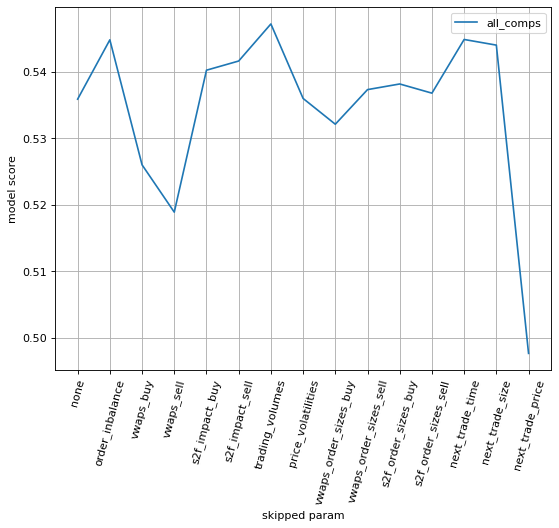

In [250]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
 ### LOG REg

# find threshold for price swing

In [253]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=1
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
thresholds=np.geomspace(1e-3, 1e-10, num=8)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds)))

In [255]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        print(y.shape)
        comp_ths[comp_id,th]=logistic_regr(X, y,split_percent, check_up_down=False, track_params=False)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
threshold  0.001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -1.9758062910257665
vwaps_buy   -0.1371460053469484
vwaps_sell   0.7476936514919181
s2f_impact_buy   -0.539568758405896
s2f_impact_sell   0.270113422882446
trading_volumes   -0.6072655703457996
price_volatilities   0.05045795804732944
vwaps_order_sizes_buy   -0.24323453230322456


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


vwaps_order_sizes_sell   -0.1013282768626466
s2f_order_sizes_buy   0.22701032851692732
s2f_order_sizes_sell   -0.43978807239852696
next_trade_time   -1.1740407151875343
next_trade_size   1.2904012524028405
next_trade_price   2.2157560384407478
threshold  0.0001
(4790, 14)
(4790,)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -2.2562889422977355
vwaps_buy   -0.13182856183587363
vwaps_sell   -0.10439892469323916
s2f_impact_buy   -0.06582691502971656
s2f_impact_sell   0.4822827416634962
trading_volumes   -0.09503224307777906
price_volatilities   -0.44263464804840047
vwaps_order_sizes_buy   0.20426718874032623
vwaps_order_sizes_sell   0.028952207828239526
s2f_order_sizes_buy   0.2101495462935708
s2f_order_sizes_sell   -0.7211303716743371
next_trade_time   -0.0930440422632471
next_trade_size   0.736533849807126
next_trade_price   2.5264606056854526
threshold  1e-05
(4790, 14)
(4790,)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -2.0259050874758584
vwaps_buy   -0.09989813966500656
vwaps_sell   -0.4607703903931444
s2f_impact_buy   -0.38767219837157774
s2f_impact_sell   0.1508662889830284
trading_volumes   -0.14392816919662985
price_volatilities   -0.22008636037297072
vwaps_order_sizes_buy   0.1810020579643689
vwaps_order_sizes_sell   -0.01810764625482845
s2f_order_sizes_buy   0.21439023700922935
s2f_order_sizes_sell   -0.7845386276414973
next_trade_time   0.6352426418801611
next_trade_size   0.5122473219065078
next_trade_price   1.9001875664429926
threshold  1e-06
(4790, 14)
(4790,)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -1.9910832010150337
vwaps_buy   -0.12518661406428827
vwaps_sell   -0.39849192015623885
s2f_impact_buy   -0.45574067808144497
s2f_impact_sell   0.12571116740809993
trading_volumes   -0.13993462578387494
price_volatilities   -0.19512043102836515
vwaps_order_sizes_buy   0.15583493342067173
vwaps_order_sizes_sell   -0.05282885714068659
s2f_order_sizes_buy   0.16359193711401684
s2f_order_sizes_sell   -0.8503995640895441
next_trade_time   0.8012411482320759
next_trade_size   0.47310476052675415
next_trade_price   1.8884232829459422
threshold  1e-07
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -1.9809136342626512
vwaps_buy   -0.12559864834856307
vwaps_sell   -0.353313533227681
s2f_impact_buy   -0.4815433553602053
s2f_impact_sell   0.11324070363758677
trading_volumes   -0.15601125471767213
price_volatilities   -0.19966501020945082
vwaps_order_sizes_buy   0.1539828495914376
vwaps_order_sizes_sell   -0.0661174295294723
s2f_order_sizes_buy   0.16034987387107807
s2f_order_sizes_sell   -0.87417249775326
next_trade_time   0.7558766112120744
next_trade_size   0.4572722075579595
next_trade_price   1.8123194178419606
threshold  1e-08
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -1.9809136342626512
vwaps_buy   -0.12559864834856307
vwaps_sell   -0.353313533227681
s2f_impact_buy   -0.4815433553602053
s2f_impact_sell   0.11324070363758677
trading_volumes   -0.15601125471767213
price_volatilities   -0.19966501020945082
vwaps_order_sizes_buy   0.1539828495914376
vwaps_order_sizes_sell   -0.0661174295294723
s2f_order_sizes_buy   0.16034987387107807
s2f_order_sizes_sell   -0.87417249775326
next_trade_time   0.7558766112120744
next_trade_size   0.4572722075579595
next_trade_price   1.8123194178419606
threshold  1e-09
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -1.9809136342626512
vwaps_buy   -0.12559864834856307
vwaps_sell   -0.353313533227681
s2f_impact_buy   -0.4815433553602053
s2f_impact_sell   0.11324070363758677
trading_volumes   -0.15601125471767213
price_volatilities   -0.19966501020945082
vwaps_order_sizes_buy   0.1539828495914376
vwaps_order_sizes_sell   -0.0661174295294723
s2f_order_sizes_buy   0.16034987387107807
s2f_order_sizes_sell   -0.87417249775326
next_trade_time   0.7558766112120744
next_trade_size   0.4572722075579595
next_trade_price   1.8123194178419606
threshold  1e-10
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -1.9809136342626512
vwaps_buy   -0.12559864834856307
vwaps_sell   -0.353313533227681
s2f_impact_buy   -0.4815433553602053
s2f_impact_sell   0.11324070363758677
trading_volumes   -0.15601125471767213
price_volatilities   -0.19966501020945082
vwaps_order_sizes_buy   0.1539828495914376
vwaps_order_sizes_sell   -0.0661174295294723
s2f_order_sizes_buy   0.16034987387107807
s2f_order_sizes_sell   -0.87417249775326
next_trade_time   0.7558766112120744
next_trade_size   0.4572722075579595
next_trade_price   1.8123194178419606
1
threshold  0.001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.04992178879994137
vwaps_buy   0.7608499501870943
vwaps_sell   1.4841131935156917
s2f_impact_buy   0.7326201065082809
s2f_impact_sell   0.8752588562802919
trading_volumes   -0.38971355759915327
price_volatilities   -0.4798827676378957
vwaps_order_sizes_buy   0.44722972014608336
vwaps_order_sizes_sell   -0.36982801389801273
s2f_order_sizes_buy   -0.402

(4790,)
Coefficient impact:
order_inbalance   -0.12133127330837845
vwaps_buy   -0.12011444842608811
vwaps_sell   0.14250090659020256
s2f_impact_buy   0.10247115464128614
s2f_impact_sell   0.32124403359722387
trading_volumes   -0.698686470861303
price_volatilities   -0.16852235425072484
vwaps_order_sizes_buy   -0.4941965166379829
vwaps_order_sizes_sell   -0.19908432938351106
s2f_order_sizes_buy   -1.082819958771005
s2f_order_sizes_sell   -0.2764507841897805
next_trade_time   0.8770330968299849
next_trade_size   0.14058727132359983
next_trade_price   0.964702782596729
threshold  1e-09
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.12133127330837845
vwaps_buy   -0.12011444842608811
vwaps_sell   0.14250090659020256
s2f_impact_buy   0.10247115464128614
s2f_impact_sell   0.32124403359722387
trading_volumes   -0.698686470861303
price_volatilities   -0.16852235425072484
vwaps_order_sizes_buy   -0.4941965166379829
vwaps_order_sizes_sell   -0.19908432938351106
s2f_order_sizes_buy   

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.6052631068844329
vwaps_buy   0.3400830660678121
vwaps_sell   -0.5446827351126369
s2f_impact_buy   -0.11328686785677285
s2f_impact_sell   0.1138438288101192
trading_volumes   0.2188012374654306
price_volatilities   -0.055426158914331204
vwaps_order_sizes_buy   -0.0790202217472219
vwaps_order_sizes_sell   0.29311217064936534
s2f_order_sizes_buy   -0.603992405538259
s2f_order_sizes_sell   0.10636167226244901
next_trade_time   0.43442158553518995
next_trade_size   0.4541537633488355
next_trade_price   1.1871332551731015
threshold  1e-05
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.5865877266151514
vwaps_buy   0.4548152969641483
vwaps_sell   -0.742509915146045
s2f_impact_buy   -0.6594916539989205
s2f_impact_sell   -0.40652452905932535
trading_volumes   0.1408725935522369
price_volatilities   -0.06925834897746236
vwaps_order_sizes_buy   0.021841021475235506
vwaps_order_sizes_sell   0.1665122632122814
s2f_order_sizes_buy   -0.49430744248155395
s2f_order_sizes_sell   -0.09185624568352978
next_trade_time   0.7083262020573948
next_trade_size   0.2744690767799114
next_trade_price   1.1431888063238147
threshold  1e-06
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.8821175230463263
vwaps_buy   0.3152995809166586
vwaps_sell   -0.767027010612455
s2f_impact_buy   -0.6079178445378963
s2f_impact_sell   -0.3556184923373017
trading_volumes   0.12093227645099916
price_volatilities   -0.0841110038775953
vwaps_order_sizes_buy   0.025703065603501857
vwaps_order_sizes_sell   0.15073044519729298
s2f_order_sizes_buy   -0.45680891363916787
s2f_order_sizes_sell   -0.18661677660429551
next_trade_time   0.888389767651289
next_trade_size   0.25637333777317656
next_trade_price   1.1436171592899098
threshold  1e-07
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.0069340215063365
vwaps_buy   0.31421755733474815
vwaps_sell   -0.7820448201176409
s2f_impact_buy   -0.667368324578858
s2f_impact_sell   -0.37439212133644795
trading_volumes   0.11283551533977816
price_volatilities   -0.017953221069074102
vwaps_order_sizes_buy   0.02594974955013848
vwaps_order_sizes_sell   0.14384632233164027
s2f_order_sizes_buy   -0.4420773748653028
s2f_order_sizes_sell   -0.21218380216347724
next_trade_time   1.5258151919571659
next_trade_size   0.24627524229528214
next_trade_price   1.1317273498089002
threshold  1e-08
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   2.0036806227349984
vwaps_buy   0.3838506601653563
vwaps_sell   -0.7778641178679938
s2f_impact_buy   -0.6608176595476982
s2f_impact_sell   -0.37821280530651663
trading_volumes   0.11712898511206857
price_volatilities   -0.022392961135344957
vwaps_order_sizes_buy   0.03898962794523123
vwaps_order_sizes_sell   0.14264955364569568
s2f_order_sizes_buy   -

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.0036806227349984
vwaps_buy   0.3838506601653563
vwaps_sell   -0.7778641178679938
s2f_impact_buy   -0.6608176595476982
s2f_impact_sell   -0.37821280530651663
trading_volumes   0.11712898511206857
price_volatilities   -0.022392961135344957
vwaps_order_sizes_buy   0.03898962794523123
vwaps_order_sizes_sell   0.14264955364569568
s2f_order_sizes_buy   -0.3331341542773875
s2f_order_sizes_sell   -0.22246541245889706
next_trade_time   1.5181742372582223
next_trade_size   0.24528888187696773
next_trade_price   1.1304478497491408
threshold  1e-10
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.0036806227349984
vwaps_buy   0.3838506601653563
vwaps_sell   -0.7778641178679938
s2f_impact_buy   -0.6608176595476982
s2f_impact_sell   -0.37821280530651663
trading_volumes   0.11712898511206857
price_volatilities   -0.022392961135344957
vwaps_order_sizes_buy   0.03898962794523123
vwaps_order_sizes_sell   0.14264955364569568
s2f_order_sizes_buy   -0.3331341542773875
s2f_order_sizes_sell   -0.22246541245889706
next_trade_time   1.5181742372582223
next_trade_size   0.24528888187696773
next_trade_price   1.1304478497491408
4
threshold  0.001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   1.1452741772809767
vwaps_buy   -1.351152783524874
vwaps_sell   -0.2258828138713133
s2f_impact_buy   1.3379239741288524
s2f_impact_sell   -0.327484845074566
trading_volumes   -0.07884488631941988
price_volatilities   0.1409953846531063
vwaps_order_sizes_buy   0.6116533217364615
vwaps_order_sizes_sell   0.2860905236571904
s2f_order_sizes_buy   0.1317

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.49659340376076294
vwaps_buy   -1.308634210163837
vwaps_sell   -0.024715549487528514
s2f_impact_buy   1.3817102601239528
s2f_impact_sell   0.4091475207160293
trading_volumes   -0.7300394936571483
price_volatilities   0.040813539637794286
vwaps_order_sizes_buy   0.3095797552442409
vwaps_order_sizes_sell   0.3065176724244695
s2f_order_sizes_buy   -0.02855756857245938
s2f_order_sizes_sell   -0.561757762489607
next_trade_time   -1.1647491483711012
next_trade_size   -0.01661621893175482
next_trade_price   -0.19196486073426217
threshold  1e-05
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.05063739071932292
vwaps_buy   -1.227992847133549
vwaps_sell   -0.047648710613431344
s2f_impact_buy   1.4486711247977606
s2f_impact_sell   0.03594206824750737
trading_volumes   -0.6697020299365685
price_volatilities   0.15332154062415096
vwaps_order_sizes_buy   0.10375603996287355
vwaps_order_sizes_sell   0.10014627637408618
s2f_order_sizes_buy   -0.2750725455749199
s2f_order_sizes_sell   -0.8874270772802901
next_trade_time   -0.34591510938878733
next_trade_size   -0.05629332209979764
next_trade_price   -0.3430602761055925
threshold  1e-06
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.01000844116829262
vwaps_buy   -1.2507081430625064
vwaps_sell   -0.06391106263289388
s2f_impact_buy   1.444451507600284
s2f_impact_sell   -0.04216395758726739
trading_volumes   -0.3953402546970487
price_volatilities   0.10221251331439335
vwaps_order_sizes_buy   0.047100963664836855
vwaps_order_sizes_sell   0.09370762846904389
s2f_order_sizes_buy   -0.3238811128591439
s2f_order_sizes_sell   -0.6750150078543846
next_trade_time   -0.49615637310903155
next_trade_size   -0.055320099134914896
next_trade_price   -0.3518249949465871
threshold  1e-07
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.0017307014855989465
vwaps_buy   -1.2587592234113967
vwaps_sell   -0.06100349990665117
s2f_impact_buy   1.4490523318882575
s2f_impact_sell   -0.015377293600721037
trading_volumes   -0.40198646611227457
price_volatilities   0.10526550776944357
vwaps_order_sizes_buy   0.048079060550984286
vwaps_order_sizes_sell   0.08885657701085663
s2f_order_sizes_buy   -0.32198693807531525
s2f_order_sizes_sell   -0.6990965181893612
next_trade_time   -0.4957355418594284
next_trade_size   -0.05668122608050259
next_trade_price   -0.34947376911939276
threshold  1e-08
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.0061130027618234144
vwaps_buy   -1.2707319920726825
vwaps_sell   -0.07450652574224989
s2f_impact_buy   1.4490240099051124
s2f_impact_sell   -0.031525311336115844
trading_volumes   -0.40810020354777865
price_volatilities   0.11817878609327126
vwaps_order_sizes_buy   0.03905626481427656
vwaps_order_sizes_sell   0.09454911128675081
s2f_order_sizes_buy   -0.3380424565772558
s2f_order_sizes_sell   -0.6678995702236252
next_trade_time   -0.5018732782104515
next_trade_size   -0.0531333849254819
next_trade_price   -0.348085387030223
threshold  1e-09
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.0061130027618234144
vwaps_buy   -1.2707319920726825
vwaps_sell   -0.07450652574224989
s2f_impact_buy   1.4490240099051124
s2f_impact_sell   -0.031525311336115844
trading_volumes   -0.40810020354777865
price_volatilities   0.11817878609327126
vwaps_order_sizes_buy   0.03905626481427656
vwaps_order_sizes_sell   0.09454911128675081
s2f_order_sizes_buy   -0.3380424565772558
s2f_order_sizes_sell   -0.6678995702236252
next_trade_time   -0.5018732782104515
next_trade_size   -0.0531333849254819
next_trade_price   -0.348085387030223
threshold  1e-10
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.0061130027618234144
vwaps_buy   -1.2707319920726825
vwaps_sell   -0.07450652574224989
s2f_impact_buy   1.4490240099051124
s2f_impact_sell   -0.031525311336115844
trading_volumes   -0.40810020354777865
price_volatilities   0.11817878609327126
vwaps_order_sizes_buy   0.03905626481427656
vwaps_order_sizes_sell   0.09454911128675081
s2f_order_sizes_buy   -0.3380424565772558
s2f_order_sizes_sell   -0.6678995702236252
next_trade_time   -0.5018732782104515
next_trade_size   -0.0531333849254819
next_trade_price   -0.348085387030223
5
threshold  0.001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.25841410844011853
vwaps_buy   -0.16777222213989898
vwaps_sell   0.30838360043093066
s2f_impact_buy   0.15663550101751747
s2f_impact_sell   0.15340693864172625
trading_volumes   -0.10011152560651407
price_volatilities   -0.17429545048795592
vwaps_order_sizes_buy   0.7217777587877474
vwaps_order_sizes_sell   0.35488762313278005
s2f_order_size

(4790,)
Coefficient impact:
order_inbalance   -0.16288786328750723
vwaps_buy   -1.1092891053741263
vwaps_sell   0.43458941600715656
s2f_impact_buy   -0.6974946744249879
s2f_impact_sell   0.21878415236071577
trading_volumes   -0.24708477846099428
price_volatilities   0.2010206070715291
vwaps_order_sizes_buy   -0.05565607057258002
vwaps_order_sizes_sell   -0.16162708561430159
s2f_order_sizes_buy   -0.849922567062231
s2f_order_sizes_sell   0.10514959377069587
next_trade_time   2.124653647793263
next_trade_size   0.27224051885065953
next_trade_price   3.65628717635283
threshold  1e-09
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.16288786328750723
vwaps_buy   -1.1092891053741263
vwaps_sell   0.43458941600715656
s2f_impact_buy   -0.6974946744249879
s2f_impact_sell   0.21878415236071577
trading_volumes   -0.24708477846099428
price_volatilities   0.2010206070715291
vwaps_order_sizes_buy   -0.05565607057258002
vwaps_order_sizes_sell   -0.16162708561430159
s2f_order_sizes_buy   -0

(4790,)
Coefficient impact:
order_inbalance   0.3317857750969074
vwaps_buy   -0.7875365408997347
vwaps_sell   1.397780699656301
s2f_impact_buy   -0.289746326854283
s2f_impact_sell   0.8234013058486018
trading_volumes   -0.40527518394103873
price_volatilities   -0.21167921884039387
vwaps_order_sizes_buy   -0.5187882151158607
vwaps_order_sizes_sell   0.07690395308640537
s2f_order_sizes_buy   -0.25432205187291845
s2f_order_sizes_sell   -0.38417599854185325
next_trade_time   2.0061257289818935
next_trade_size   -0.3407523150332191
next_trade_price   1.6861923401720984
threshold  1e-07
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.32766799235900285
vwaps_buy   -0.745295887128013
vwaps_sell   1.3963577322123528
s2f_impact_buy   -0.2105973489411012
s2f_impact_sell   0.7760217148309121
trading_volumes   -0.42156107682626126
price_volatilities   -0.18469903984792796
vwaps_order_sizes_buy   -0.5671256103854138
vwaps_order_sizes_sell   0.07443838277667869
s2f_order_sizes_buy   -0.312

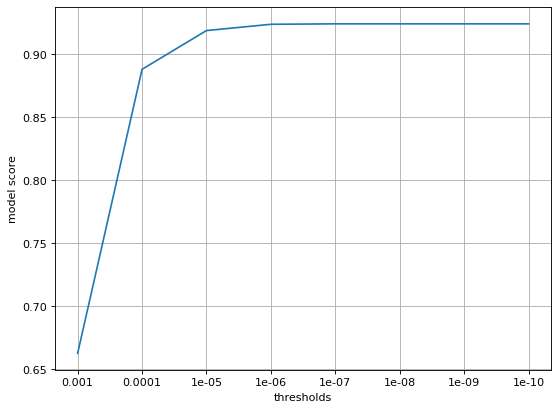

In [256]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
plt.xticks(np.arange(len(thresholds)), thresholds, rotation='0')
plt.grid()

plt.plot(np.sum(comp_ths, axis=0)/9)

In [276]:
thresholds=np.arange(1e-4, 1e-3, step=1e-4)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds)))

In [265]:
np.arange(1e-4, 1e-3, step=1e-4)

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009])

In [277]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        print(y.shape)
        comp_ths[comp_id,th]=logistic_regr(X, y,split_percent, check_up_down=False, track_params=False)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -2.2562889422977355
vwaps_buy   -0.13182856183587363
vwaps_sell   -0.10439892469323916
s2f_impact_buy   -0.06582691502971656
s2f_impact_sell   0.4822827416634962
trading_volumes   -0.09503224307777906
price_volatilities   -0.44263464804840047
vwaps_order_sizes_buy   0.20426718874032623
vwaps_order_sizes_sell   0.028952207828239526
s2f_order_sizes_buy   0.2101495462935708
s2f_order_sizes_sell   -0.7211303716743371
next_trade_time   -0.0930440422632471
next_trade_size   0.736533849807126
next_trade_price   2.5264606056854526
threshold  0.0002
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.3428209173294126
vwaps_buy   -0.3610122486136574
vwaps_sell   0.24070450058050796
s2f_impact_buy   0.058753309308621174
s2f_impact_sell   0.5789258387411012
trading_volumes   -0.4283744765287366
price_volatilities   -0.40474847309929535
vwaps_order_sizes_buy   -0.5544030260204654
vwaps_order_sizes_sell   0.05395640920510796
s2f_order_sizes_buy   0.27241022348169447
s2f_order_sizes_sell   -0.8220220764067807
next_trade_time   -0.41702792770116937
next_trade_size   0.8987866945158018
next_trade_price   2.244804160080245
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.5031514257956142
vwaps_buy   -0.5270306699074759
vwaps_sell   0.1822937798979354
s2f_impact_buy   -0.06318251049957602
s2f_impact_sell   0.7970439816816898
trading_volumes   -0.33124939503464057
price_volatilities   -0.28715709110388815
vwaps_order_sizes_buy   -0.4611845103398011
vwaps_order_sizes_sell   0.12984443541745852
s2f_order_sizes_buy   0.46500550911495386
s2f_order_sizes_sell   -0.6872882723390749
next_trade_time   -0.4650817223958273
next_trade_size   1.0702072374694471
next_trade_price   2.4347391835435546
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.3003766558571646
vwaps_buy   -0.5874930641332474
vwaps_sell   0.19075360646744893
s2f_impact_buy   -0.05801556447908214
s2f_impact_sell   0.7955547466835978
trading_volumes   -0.26005888477906247
price_volatilities   -0.3097255792390768
vwaps_order_sizes_buy   -0.43105292907808535
vwaps_order_sizes_sell   0.16273610780143816
s2f_order_sizes_buy   0.4271794739224416
s2f_order_sizes_sell   -0.6491793817020879
next_trade_time   -0.9571433695638506
next_trade_size   1.1890991375900448
next_trade_price   2.352802863576242
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.140702299793343
vwaps_buy   -0.6065557428601358
vwaps_sell   0.22030177220881214
s2f_impact_buy   -0.15493656263256095
s2f_impact_sell   0.7885656435731749
trading_volumes   -0.16817903804947926
price_volatilities   -0.28875304280160824
vwaps_order_sizes_buy   -0.37151796779356905
vwaps_order_sizes_sell   0.21120995893691122
s2f_order_sizes_buy   0.5485909010342317
s2f_order_sizes_sell   -0.49768964270650223
next_trade_time   -1.060258025960568
next_trade_size   1.2931643040711684
next_trade_price   2.3954219451528687
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.208497858004443
vwaps_buy   -0.5378955220442873
vwaps_sell   0.04730965427406703
s2f_impact_buy   -0.521291394260642
s2f_impact_sell   0.750428703573892
trading_volumes   -0.46165076993907944
price_volatilities   -0.14288480437137277
vwaps_order_sizes_buy   -0.32257503560803535
vwaps_order_sizes_sell   -0.15003843506962766
s2f_order_sizes_buy   0.5220262458502304
s2f_order_sizes_sell   -0.46213839734415685
next_trade_time   -1.4962026240132207
next_trade_size   1.4431062704289066
next_trade_price   2.8289986955659425
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.12348376952563
vwaps_buy   -0.42073568979849935
vwaps_sell   0.1363110474630416
s2f_impact_buy   -0.6102200588203157
s2f_impact_sell   0.6128962498995737
trading_volumes   -0.5046514919721157
price_volatilities   -0.01482781046578143
vwaps_order_sizes_buy   -0.3294178147353774
vwaps_order_sizes_sell   -0.20438982278850404
s2f_order_sizes_buy   0.4263919462548245
s2f_order_sizes_sell   -0.6674687126334434
next_trade_time   -1.4552720254103306
next_trade_size   1.4402054191840903
next_trade_price   2.600653216602506
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.2034283188266564
vwaps_buy   -0.1653232713361963
vwaps_sell   0.3887915934077169
s2f_impact_buy   -0.6140224014237835
s2f_impact_sell   0.4772358037482897
trading_volumes   -0.5739585291741232
price_volatilities   0.06481859053590328
vwaps_order_sizes_buy   -0.30463491204086995
vwaps_order_sizes_sell   -0.21354323346078422
s2f_order_sizes_buy   0.3690769398424043
s2f_order_sizes_sell   -0.7823513327984116
next_trade_time   -1.2407166640630285
next_trade_size   1.3087177758212039
next_trade_price   2.503465606479396
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -2.024404814788788
vwaps_buy   -0.3376023640239156
vwaps_sell   0.37837895004728106
s2f_impact_buy   -0.5928218477571694
s2f_impact_sell   0.4105069201476305
trading_volumes   -0.5706140353945308
price_volatilities   0.048472011173294895
vwaps_order_sizes_buy   -0.2688560608208702
vwaps_order_sizes_sell   -0.1478063982931294
s2f_order_sizes_buy   0.2853765301796343
s2f_order_sizes_sell   -0.7065759982069835
next_trade_time   -1.2370126545842
next_trade_size   1.4064558256954407
next_trade_price   2.43891388331817
1
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.36345501962759874
vwaps_buy   -0.037242487406599765
vwaps_sell   0.6987221639801138
s2f_impact_buy   0.9414886618093863
s2f_impact_sell   0.6301668721596653
trading_volumes   -0.6552414294094477
price_volatilities   -0.24795779402557455
vwaps_order_sizes_buy   0.1519248954343556
vwaps_order_sizes_sell   -0.792487910503093
s2f_order_sizes_buy   -0.9054743

(4790,)
Coefficient impact:
order_inbalance   -0.7694095582781868
vwaps_buy   -0.916377402010314
vwaps_sell   0.5618426426166168
s2f_impact_buy   -0.29835065240964637
s2f_impact_sell   -0.2033529381663619
trading_volumes   -0.23710418281310425
price_volatilities   0.17175954557034304
vwaps_order_sizes_buy   0.1298347222443631
vwaps_order_sizes_sell   0.12571278554880966
s2f_order_sizes_buy   -0.5231486531423801
s2f_order_sizes_sell   0.017541275646570743
next_trade_time   -0.5195252915465298
next_trade_size   0.11564306410398588
next_trade_price   0.563794777766561
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.9246323876280899
vwaps_buy   -0.7073215431431863
vwaps_sell   0.4240055735850477
s2f_impact_buy   -0.3089840318197005
s2f_impact_sell   -0.11091564627308712
trading_volumes   -0.6950379982650463
price_volatilities   0.11231472078369106
vwaps_order_sizes_buy   0.2922104091258034
vwaps_order_sizes_sell   0.206171734551975
s2f_order_siz

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.23454110141154785
vwaps_buy   0.5086932876383568
vwaps_sell   -0.47275065224287416
s2f_impact_buy   -0.10139922787076279
s2f_impact_sell   0.3147506541789851
trading_volumes   0.22679388578267584
price_volatilities   -0.13473902327184883
vwaps_order_sizes_buy   -0.14464793747645835
vwaps_order_sizes_sell   0.3082246933319898
s2f_order_sizes_buy   -0.4006996286172612
s2f_order_sizes_sell   -0.16963640829667218
next_trade_time   0.15257101478795052
next_trade_size   0.6007391064929123
next_trade_price   1.2631276747887015
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.6180097462458147
vwaps_buy   0.5428757866480208
vwaps_sell   -0.44576787096062037
s2f_impact_buy   0.03623694610938945
s2f_impact_sell   0.20591356152083198
trading_volumes   0.3375597757677704
price_volatilities   -0.18389910953824223
vwaps_order_sizes_buy   -0.09808129129016406
vwaps_order_sizes_sell   0.37516813177065766
s2f_order_sizes_buy   -0.30297520200817113
s2f_order_sizes_sell   0.09200627840300557
next_trade_time   0.36109071460060826
next_trade_size   0.6628219920800941
next_trade_price   1.289643364133265
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.9997332955525703
vwaps_buy   0.5553815857765126
vwaps_sell   -0.42846298240071284
s2f_impact_buy   0.02099982729822209
s2f_impact_sell   0.29284037922232503
trading_volumes   0.3790934318418641
price_volatilities   -0.23260337123442495
vwaps_order_sizes_buy   -0.11320084942504058
vwaps_order_sizes_sell   0.42570313688263745
s2f_order_sizes_buy   -0.6326963491219981
s2f_order_sizes_sell   0.10984603736683236
next_trade_time   0.09806736037372357
next_trade_size   0.6911722555509119
next_trade_price   1.2233353810954886
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.3601387935957043
vwaps_buy   0.6501415152024185
vwaps_sell   -0.4417726231444735
s2f_impact_buy   -0.1034892251757713
s2f_impact_sell   0.2755239400132833
trading_volumes   0.4487291009913112
price_volatilities   -0.17576889506986978
vwaps_order_sizes_buy   -0.08811624999941223
vwaps_order_sizes_sell   0.46846950442311214
s2f_order_sizes_buy   -0.5614876477131052
s2f_order_sizes_sell   0.14104717559377086
next_trade_time   0.3282227850585527
next_trade_size   0.6651399261574806
next_trade_price   1.2412683120270802
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.6235781047066955
vwaps_buy   0.7097054519494067
vwaps_sell   -0.4448399808551973
s2f_impact_buy   -0.0968027942628672
s2f_impact_sell   0.24534920707937066
trading_volumes   0.5106193345170604
price_volatilities   -0.19203407662573926
vwaps_order_sizes_buy   -0.08095166082954422
vwaps_order_sizes_sell   0.5265163706108794
s2f_order_sizes_buy   -0.6700685107704242
s2f_order_sizes_sell   0.36592057280717033
next_trade_time   0.35159649423792055
next_trade_size   0.649051105809039
next_trade_price   1.190998601496133
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.6081365761331503
vwaps_buy   0.33282179908050585
vwaps_sell   -0.42729598803290336
s2f_impact_buy   0.10768519830685104
s2f_impact_sell   0.33807852294705903
trading_volumes   0.5654779930706934
price_volatilities   -0.14396841185770196
vwaps_order_sizes_buy   -0.06906132024067882
vwaps_order_sizes_sell   0.5556321444071431
s2f_order_sizes_buy   -1.0467783776616484
s2f_order_sizes_sell   0.13458180526876157
next_trade_time   0.4901806881161686
next_trade_size   0.7404612427717325
next_trade_price   1.1215592045895493
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.5414245803589528
vwaps_buy   0.34996090503497584
vwaps_sell   -0.4017261614958951
s2f_impact_buy   0.14484456200577564
s2f_impact_sell   0.25520068991673467
trading_volumes   0.5943728109473261
price_volatilities   -0.1566687502098921
vwaps_order_sizes_buy   -0.045978632659625665
vwaps_order_sizes_sell   0.5603711281369528
s2f_order_sizes_buy   -1.1176279043614685
s2f_order_sizes_sell   0.4277578206803564
next_trade_time   0.4070347971353969
next_trade_size   0.8215785633978473
next_trade_price   1.0991192821094726
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.015683306061967
vwaps_buy   0.07939210205857652
vwaps_sell   -0.4363100012236724
s2f_impact_buy   0.2495032612944359
s2f_impact_sell   0.18003939178070505
trading_volumes   0.6886543053237701
price_volatilities   -0.12379189483440205
vwaps_order_sizes_buy   0.002524131493052556
vwaps_order_sizes_sell   0.6016632108889117
s2f_order_sizes_buy   -1.04802620904309
s2f_order_sizes_sell   0.7063752433676986
next_trade_time   0.37858598768020574
next_trade_size   0.8882915617600035
next_trade_price   1.0678772897101705
4
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.49659340376076294
vwaps_buy   -1.308634210163837
vwaps_sell   -0.024715549487528514
s2f_impact_buy   1.3817102601239528
s2f_impact_sell   0.4091475207160293
trading_volumes   -0.7300394936571483
price_volatilities   0.040813539637794286
vwaps_order_sizes_buy   0.3095797552442409
vwaps_order_sizes_sell   0.3065176724244695
s2f_order_sizes_buy   -0.028557

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.9809753282683491
vwaps_buy   -1.6234640219037535
vwaps_sell   -0.6178572591339272
s2f_impact_buy   1.482776268754106
s2f_impact_sell   0.3842628075187978
trading_volumes   -0.7088749565435887
price_volatilities   0.08376839100729021
vwaps_order_sizes_buy   0.4225821030006175
vwaps_order_sizes_sell   0.30585028076618936
s2f_order_sizes_buy   0.11716742100482162
s2f_order_sizes_sell   -0.8195935636810354
next_trade_time   -1.256418052985491
next_trade_size   -0.010349981760041902
next_trade_price   0.6000473062333512
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.252332073874453
vwaps_buy   -1.6258682946831584
vwaps_sell   -0.5106369659752807
s2f_impact_buy   1.4778174019774863
s2f_impact_sell   -0.10343113612743601
trading_volumes   -0.6379917895508221
price_volatilities   0.17161973852194257
vwaps_order_sizes_buy   0.3881090155003761
vwaps_order_sizes_sell   0.38960784548106525
s2f_order_sizes_buy   -0.07852092151182954
s2f_order_sizes_sell   -0.6026427906801082
next_trade_time   -1.196322746392134
next_trade_size   -0.09316236564279215
next_trade_price   0.6058631741559464
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.5201551841843048
vwaps_buy   -1.4881322759615059
vwaps_sell   -0.3876800113596259
s2f_impact_buy   1.4265279046489725
s2f_impact_sell   -0.37585820266027753
trading_volumes   -0.44355688802494675
price_volatilities   0.14188741391451296
vwaps_order_sizes_buy   0.4453688026446534
vwaps_order_sizes_sell   0.5033874051276078
s2f_order_sizes_buy   -0.003597244314643674
s2f_order_sizes_sell   -0.21006976502328295
next_trade_time   -1.0619354057189525
next_trade_size   0.1589038741235622
next_trade_price   0.678156994806655
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.4191316522721644
vwaps_buy   -1.4243533502463863
vwaps_sell   -0.3336098882747815
s2f_impact_buy   1.4088503196979119
s2f_impact_sell   -0.5017298791589926
trading_volumes   -0.2581143625908366
price_volatilities   0.13184359447259497
vwaps_order_sizes_buy   0.4514820592336032
vwaps_order_sizes_sell   0.5548170738521437
s2f_order_sizes_buy   -0.021145177409448407
s2f_order_sizes_sell   0.020753540879277835
next_trade_time   -1.0696054726416662
next_trade_size   0.2680846073610296
next_trade_price   0.5618935405100635
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.4578452522815637
vwaps_buy   -1.4415402740972436
vwaps_sell   -0.27409112685395637
s2f_impact_buy   1.3710208786373068
s2f_impact_sell   -0.55650939265912
trading_volumes   -0.1670128450985904
price_volatilities   0.18963081441055737
vwaps_order_sizes_buy   0.5036654479268192
vwaps_order_sizes_sell   0.5641060203213014
s2f_order_sizes_buy   0.09517222381656734
s2f_order_sizes_sell   0.06116128825537349
next_trade_time   -0.9349246007054338
next_trade_size   0.22038190899922047
next_trade_price   0.6386372896299245
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.4038979867783177
vwaps_buy   -1.466198267106871
vwaps_sell   -0.2583430110698228
s2f_impact_buy   1.4422918626369405
s2f_impact_sell   -0.5349318478043287
trading_volumes   -0.026368401048792275
price_volatilities   0.1744550557341045
vwaps_order_sizes_buy   0.529493425720209
vwaps_order_sizes_sell   0.5832516742535006
s2f_order_sizes_buy   0.1379760965294429
s2f_order_sizes_sell   0.12024270494261242
next_trade_time   -0.7229719346069627
next_trade_size   0.16075053226738234
next_trade_price   0.6879538882042024
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.2909700581712107
vwaps_buy   -1.45286351076068
vwaps_sell   -0.22411836429736853
s2f_impact_buy   1.3951510834724303
s2f_impact_sell   -0.49002762295244756
trading_volumes   -0.1726097759396812
price_volatilities   0.1642272751403641
vwaps_order_sizes_buy   0.617187788446341
vwaps_order_sizes_sell   0.24745234584816234
s2f_order_sizes_buy   0.23457046713538518
s2f_order_sizes_sell   -0.026722492188793794
next_trade_time   -0.6315146505804026
next_trade_size   0.2017466559205106
next_trade_price   0.6380493560610366
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.1840215763619053
vwaps_buy   -1.3829426959388775
vwaps_sell   -0.24326968666962842
s2f_impact_buy   1.3473881112291881
s2f_impact_sell   -0.40459171902889246
trading_volumes   -0.08793380645686602
price_volatilities   0.1956740755573616
vwaps_order_sizes_buy   0.6495453112892207
vwaps_order_sizes_sell   0.2391387659609637
s2f_order_sizes_buy   0.3021228198081241
s2f_order_sizes_sell   -0.12602788742458298
next_trade_time   -0.4004123530188068
next_trade_size   0.2680728187044749
next_trade_price   0.6709694301572894
5
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.30507162803567567
vwaps_buy   -1.0098690341061756
vwaps_sell   0.06106821938087313
s2f_impact_buy   0.298152897865591
s2f_impact_sell   0.17807291058394048
trading_volumes   -0.17093518652749962
price_volatilities   -0.04543007761422035
vwaps_order_sizes_buy   0.23337883834913276
vwaps_order_sizes_sell   0.022076041085107558
s2f_order_sizes_buy   -

(4790,)
Coefficient impact:
order_inbalance   -0.04224528290461818
vwaps_buy   -1.1807045943574357
vwaps_sell   1.2825823938288614
s2f_impact_buy   -0.16617583310217046
s2f_impact_sell   0.3453482756843913
trading_volumes   -0.9609328247347071
price_volatilities   -0.014004449645030354
vwaps_order_sizes_buy   -0.7996152365226235
vwaps_order_sizes_sell   -0.02127061860596816
s2f_order_sizes_buy   -1.3582977148132889
s2f_order_sizes_sell   -0.017811606812446288
next_trade_time   0.6107296753132132
next_trade_size   -0.1675234173856514
next_trade_price   3.0793389307404992
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.04090892299087933
vwaps_buy   -1.0386491507798143
vwaps_sell   1.3931221128201146
s2f_impact_buy   0.001028067716006626
s2f_impact_sell   0.3650065658877599
trading_volumes   -0.926163202612447
price_volatilities   -0.023604728201370044
vwaps_order_sizes_buy   -0.7752883792869428
vwaps_order_sizes_sell   -0.024323231862396162
s2f

threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.13186795368331597
vwaps_buy   -0.4790076372185593
vwaps_sell   1.3850894534629223
s2f_impact_buy   -0.7385062020008563
s2f_impact_sell   0.671591742414001
trading_volumes   -0.38139920183510373
price_volatilities   -0.2348586629224423
vwaps_order_sizes_buy   -0.7968700479382294
vwaps_order_sizes_sell   0.16490097469653434
s2f_order_sizes_buy   -0.3049185741411566
s2f_order_sizes_sell   -0.1000004875129008
next_trade_time   1.2904819716932157
next_trade_size   -0.10750944840154822
next_trade_price   1.951193814861154
threshold  0.0002
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.24156263786787005
vwaps_buy   -0.38640369328259755
vwaps_sell   1.71249686041693
s2f_impact_buy   -0.6910254770369174
s2f_impact_sell   0.7957522136870587
trading_volumes   -0.6936700185415252
price_volatilities   -0.1576512696489707
vwaps_order_sizes_buy   -1.1365787828124316
vwaps_order_sizes_sell   -0.0724556010308603

Coefficient impact:
order_inbalance   0.25508038631558233
vwaps_buy   -0.0936408291283886
vwaps_sell   0.27886420492640174
s2f_impact_buy   0.05475981292009231
s2f_impact_sell   0.9254668475605123
trading_volumes   0.47017415644107985
price_volatilities   -0.15088881550505778
vwaps_order_sizes_buy   0.49853010597623193
vwaps_order_sizes_sell   0.7453900295709476
s2f_order_sizes_buy   0.024219845719607093
s2f_order_sizes_sell   -0.4438720575513603
next_trade_time   0.14691499740173103
next_trade_size   0.3008869098887275
next_trade_price   0.6797437275682848
threshold  0.0007000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.5486958173632646
vwaps_buy   0.10631574404307424
vwaps_sell   0.3096378723191813
s2f_impact_buy   0.1879476070700679
s2f_impact_sell   0.7514735988752912
trading_volumes   0.5368934954757356
price_volatilities   -0.12447075033551001
vwaps_order_sizes_buy   0.5107592795038088
vwaps_order_sizes_sell   0.7835847175975881
s2f_order_sizes_buy   -0

(4790,)
Coefficient impact:
order_inbalance   0.5574611880604285
vwaps_buy   -0.45665860848051776
vwaps_sell   0.10851262022030515
s2f_impact_buy   0.02760776666237432
s2f_impact_sell   -0.13797656074258413
trading_volumes   -0.08648641828365347
price_volatilities   -0.0258068727046585
vwaps_order_sizes_buy   -0.10617943986721819
vwaps_order_sizes_sell   0.13904121392943
s2f_order_sizes_buy   -0.8242858527630709
s2f_order_sizes_sell   -0.39923092285445677
next_trade_time   -0.30418240173987865
next_trade_size   -0.06748570944587474
next_trade_price   1.2815181741543897
threshold  0.00030000000000000003
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.49164388417725596
vwaps_buy   -0.9809877410412597
vwaps_sell   0.296939036413874
s2f_impact_buy   -0.15247793771043788
s2f_impact_sell   -0.24830979768751252
trading_volumes   -0.03514316742173945
price_volatilities   0.10203495110147388
vwaps_order_sizes_buy   -0.0589372192548961
vwaps_order_sizes_sell   0.15775687583019782
s2f_

(4790,)
Coefficient impact:
order_inbalance   0.07121753519357839
vwaps_buy   1.1407465943873245
vwaps_sell   0.22844936349470799
s2f_impact_buy   -0.12765854666529172
s2f_impact_sell   0.7375481292967025
trading_volumes   -0.5044497871983016
price_volatilities   -0.16857969231133188
vwaps_order_sizes_buy   0.14468645459446494
vwaps_order_sizes_sell   0.07417688520372871
s2f_order_sizes_buy   -0.8045142829535887
s2f_order_sizes_sell   -0.7712266143295093
next_trade_time   0.1155420209457533
next_trade_size   0.172547272367582
next_trade_price   1.5298586902488398
threshold  0.0008
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.15754310570773505
vwaps_buy   1.1114830021852915
vwaps_sell   0.22968351524075328
s2f_impact_buy   -0.22198330220946852
s2f_impact_sell   0.6781984598037594
trading_volumes   -0.433927400712043
price_volatilities   -0.13804709668433435
vwaps_order_sizes_buy   0.2129683731319896
vwaps_order_sizes_sell   0.07662317925570757
s2f_order_sizes_buy   -0.638

(4790,)
Coefficient impact:
order_inbalance   -0.31672487598597704
vwaps_buy   -0.7854739542416979
vwaps_sell   0.7429490589072956
s2f_impact_buy   -0.45698311228888505
s2f_impact_sell   -0.4433952758071583
trading_volumes   0.020931676895629053
price_volatilities   0.1553652407048078
vwaps_order_sizes_buy   -0.07834390349548234
vwaps_order_sizes_sell   0.884888474339273
s2f_order_sizes_buy   0.7822255138667193
s2f_order_sizes_sell   1.3492224209813612
next_trade_time   0.8447463638503547
next_trade_size   -0.8494233709134423
next_trade_price   1.5692423027681388
threshold  0.0004
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.35292316137163277
vwaps_buy   -0.5643306152447568
vwaps_sell   0.8863527252934549
s2f_impact_buy   -0.3431918595140244
s2f_impact_sell   -0.4460649043148482
trading_volumes   0.0008544668756416873
price_volatilities   0.10392873672934996
vwaps_order_sizes_buy   -0.09008584506480732
vwaps_order_sizes_sell   0.9423745829647041
s2f_order_sizes_buy   0.4

(4790,)
Coefficient impact:
order_inbalance   0.08085130268183034
vwaps_buy   0.3836468221497795
vwaps_sell   1.6433716108916483
s2f_impact_buy   -0.6680208347261798
s2f_impact_sell   -0.24398856431628205
trading_volumes   -0.3540770991876041
price_volatilities   -0.02364310676374245
vwaps_order_sizes_buy   -0.41186540481665734
vwaps_order_sizes_sell   0.13696585424859503
s2f_order_sizes_buy   -0.45806348167658445
s2f_order_sizes_sell   0.1432621657832705
next_trade_time   -0.41663730396895843
next_trade_size   -0.23315660732619342
next_trade_price   2.490374415875101
threshold  0.0009000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.14317688043946353
vwaps_buy   0.3196283153551307
vwaps_sell   1.8067643423893367
s2f_impact_buy   -0.5836470991895303
s2f_impact_sell   -0.239331651437704
trading_volumes   -0.3984515178074161
price_volatilities   -0.0431381709270843
vwaps_order_sizes_buy   -0.3303381455693419
vwaps_order_sizes_sell   0.11396357716587532
s2f_order_

(4790,)
Coefficient impact:
order_inbalance   -0.9668515863588455
vwaps_buy   -0.12566733154360704
vwaps_sell   -0.06434996271136814
s2f_impact_buy   -0.1206860473479221
s2f_impact_sell   0.9473865364309743
trading_volumes   -0.7650302884659819
price_volatilities   -0.23206742230254565
vwaps_order_sizes_buy   -0.21055000658718057
vwaps_order_sizes_sell   -0.04241231121615207
s2f_order_sizes_buy   -0.4544640440716294
s2f_order_sizes_sell   -1.0162641049992949
next_trade_time   -0.12941902635069852
next_trade_size   -0.33626655849079545
next_trade_price   1.0860672698664375
threshold  0.0005
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -1.0432402624308028
vwaps_buy   -0.17336016063173038
vwaps_sell   -0.1043609222544233
s2f_impact_buy   -0.16056839864840028
s2f_impact_sell   1.0001924520134948
trading_volumes   -0.8074436671596648
price_volatilities   -0.18794654230741317
vwaps_order_sizes_buy   -0.15710116282638278
vwaps_order_sizes_sell   0.015416608363793452
s2f_order_size

(4790,)
Coefficient impact:
order_inbalance   0.7255940624919658
vwaps_buy   -0.49144780274650973
vwaps_sell   0.2124933692136413
s2f_impact_buy   -0.14641833139950008
s2f_impact_sell   0.31735269658423143
trading_volumes   -0.8837299137584478
price_volatilities   -0.10619028847563249
vwaps_order_sizes_buy   -0.6341787220556313
vwaps_order_sizes_sell   -0.041042148324657406
s2f_order_sizes_buy   -0.4781836272819052
s2f_order_sizes_sell   -0.0511265171884688
next_trade_time   -0.4715817908373001
next_trade_size   0.6636315042965436
next_trade_price   0.8133924768732698
19
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.033564670210036646
vwaps_buy   -0.032090742488266134
vwaps_sell   0.9648160059850563
s2f_impact_buy   -0.5200586608432746
s2f_impact_sell   0.3396353191978438
trading_volumes   -0.5171312208609765
price_volatilities   -0.1963796794536924
vwaps_order_sizes_buy   0.21433597706260604
vwaps_order_sizes_sell   -0.17090031486982882
s2f_order_sizes_b

(4790,)
Coefficient impact:
order_inbalance   0.6473076014374362
vwaps_buy   -0.412980728500006
vwaps_sell   0.6055539732865586
s2f_impact_buy   -0.14457834716841175
s2f_impact_sell   0.7156759632223818
trading_volumes   0.019512931393956087
price_volatilities   -0.34803911543963256
vwaps_order_sizes_buy   -0.0030968493179056185
vwaps_order_sizes_sell   0.24528105434722747
s2f_order_sizes_buy   -0.0030968493179056185
s2f_order_sizes_sell   -0.8202294329962908
next_trade_time   -0.5647103035920747
next_trade_size   1.3065874836137539
next_trade_price   3.5643514392630395
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.5865052993015121
vwaps_buy   -0.4830690983973132
vwaps_sell   -0.04029767366291134
s2f_impact_buy   -0.09678070155837269
s2f_impact_sell   0.8888416727173071
trading_volumes   -0.27607595016814945
price_volatilities   -0.3310822652716595
vwaps_order_sizes_buy   0.1109787938031906
vwaps_order_sizes_sell   -0.05282731864428925
s2f_

threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.03971257770228434
vwaps_buy   0.13932677742524283
vwaps_sell   0.7521812012591522
s2f_impact_buy   -0.26259806025994414
s2f_impact_sell   0.017867253737050337
trading_volumes   0.12116077729627019
price_volatilities   -0.1011920788216336
vwaps_order_sizes_buy   0.19398012584992175
vwaps_order_sizes_sell   -0.06299586564165725
s2f_order_sizes_buy   -0.7059599656403569
s2f_order_sizes_sell   0.24621319614030218
next_trade_time   -0.3266176137775166
next_trade_size   -0.02858411272777909
next_trade_price   1.8876484599942251
threshold  0.0002
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.13821071369279112
vwaps_buy   0.04567109350592669
vwaps_sell   0.9290665937964044
s2f_impact_buy   -0.3283528558643956
s2f_impact_sell   0.2505462791173081
trading_volumes   0.022426766020633426
price_volatilities   -0.23425217961616335
vwaps_order_sizes_buy   0.2806958091623163
vwaps_order_sizes_sell   -0.325634519

(4790,)
Coefficient impact:
order_inbalance   0.49164390311288697
vwaps_buy   0.936403616314014
vwaps_sell   1.1876738247619394
s2f_impact_buy   -0.11477266230828768
s2f_impact_sell   0.885886662661876
trading_volumes   -1.8440277626118349
price_volatilities   -0.49356050291364856
vwaps_order_sizes_buy   -0.7748744232876371
vwaps_order_sizes_sell   -0.3806453512951195
s2f_order_sizes_buy   -0.04058111604468345
s2f_order_sizes_sell   -0.01844532471733976
next_trade_time   -0.8216898661512017
next_trade_size   0.7910794748789751
next_trade_price   2.104695004426686
threshold  0.0007000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.45270431405462497
vwaps_buy   0.8329736970341657
vwaps_sell   1.165276748576645
s2f_impact_buy   -0.14706119344739738
s2f_impact_sell   0.7676567275846388
trading_volumes   -1.7949776099354102
price_volatilities   -0.44464694705599656
vwaps_order_sizes_buy   -0.828467947592852
vwaps_order_sizes_sell   -0.3675745720009097
s2f_order_sizes

(4790,)
Coefficient impact:
order_inbalance   -0.4583635926222894
vwaps_buy   0.42643247192351935
vwaps_sell   0.47110227918942327
s2f_impact_buy   0.9326701696430573
s2f_impact_sell   0.7706752617042365
trading_volumes   -0.6015435697412316
price_volatilities   -0.39963142585817946
vwaps_order_sizes_buy   -0.4930885896836369
vwaps_order_sizes_sell   -0.6519399464010261
s2f_order_sizes_buy   -1.3694961233841407
s2f_order_sizes_sell   -0.722649461920958
next_trade_time   0.2990484488076707
next_trade_size   -0.06175729177305429
next_trade_price   0.08382035778941424
threshold  0.00030000000000000003
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.5168825877089516
vwaps_buy   0.2537105508440778
vwaps_sell   0.5660691153515942
s2f_impact_buy   1.1084621876982221
s2f_impact_sell   0.754169936494432
trading_volumes   -0.5112769209543979
price_volatilities   -0.3853752764274003
vwaps_order_sizes_buy   -0.5304577700021201
vwaps_order_sizes_sell   -0.44708740860959756
s2f_order_siz

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3426223658547594
vwaps_buy   -0.28491476331015914
vwaps_sell   -0.4697228167796304
s2f_impact_buy   -0.6090717200260509
s2f_impact_sell   -0.7043385757112419
trading_volumes   -0.08975697009085962
price_volatilities   0.14368994594932719
vwaps_order_sizes_buy   0.21998398716931827
vwaps_order_sizes_sell   -0.4174749074106652
s2f_order_sizes_buy   0.7033652847662921
s2f_order_sizes_sell   0.6323197225586078
next_trade_time   -0.9325148305246252
next_trade_size   0.0158166947756494
next_trade_price   1.397404261587534
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.03025991959111164
vwaps_buy   -0.23620007897701883
vwaps_sell   -0.3144366738221745
s2f_impact_buy   -0.4538814294937348
s2f_impact_sell   -0.6848511931255821
trading_volumes   -0.00907371567295885
price_volatilities   0.06528231256699885
vwaps_order_sizes_buy   0.27229981428048655
vwaps_order_sizes_sell   -0.37747065406765695
s2f_order_sizes_buy   0.8842250882970277
s2f_order_sizes_sell   0.48382034550502356
next_trade_time   -1.1525382862351667
next_trade_size   0.04154651661947123
next_trade_price   1.4846298136755374
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.0037208230888008697
vwaps_buy   -0.3777768692963114
vwaps_sell   -0.25203096547696563
s2f_impact_buy   -0.5171348884706121
s2f_impact_sell   -0.7625537439245211
trading_volumes   -0.005343583524698431
price_volatilities   0.10160214455983667
vwaps_order_sizes_buy   0.29137730838468523
vwaps_order_sizes_sell   -0.31642398994197624
s2f_order_sizes_buy   0.8363718483219906
s2f_order_sizes_sell   0.652233618979696
next_trade_time   -0.9968986264379743
next_trade_size   0.14299228492336963
next_trade_price   1.447077394633166
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.12671656857393332
vwaps_buy   -0.37834593497884744
vwaps_sell   -0.1929202607268506
s2f_impact_buy   -0.5554789726498985
s2f_impact_sell   -0.7210696984735918
trading_volumes   -0.056331317825264876
price_volatilities   0.14370740142404362
vwaps_order_sizes_buy   0.2903260363488867
vwaps_order_sizes_sell   -0.41795959958284173
s2f_order_sizes_buy   0.6330943502704673
s2f_order_sizes_sell   0.37481661639449737
next_trade_time   -0.874163677627468
next_trade_size   0.23416061300530583
next_trade_price   1.3703910321053447
threshold  0.0006000000000000001
(4790, 14)
(4790,)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -0.09692989356908442
vwaps_buy   -0.3469694712658298
vwaps_sell   -0.15764133214285228
s2f_impact_buy   -0.4727203606087797
s2f_impact_sell   -0.8120020168887894
trading_volumes   -0.05769425606448906
price_volatilities   0.14390300540395057
vwaps_order_sizes_buy   0.31911760771095454
vwaps_order_sizes_sell   -0.4197324032030473
s2f_order_sizes_buy   0.7712255494391804
s2f_order_sizes_sell   0.2802355137250177
next_trade_time   -0.916281213911044
next_trade_size   0.30401717638299997
next_trade_price   1.3514728625168493
threshold  0.0007000000000000001
(4790, 14)
(4790,)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -0.02868562821728119
vwaps_buy   -0.3011137065870035
vwaps_sell   -0.20236696630641351
s2f_impact_buy   -0.5838768752587946
s2f_impact_sell   -0.6344903544243462
trading_volumes   0.011651397734342199
price_volatilities   0.15613191516609176
vwaps_order_sizes_buy   0.34378665656594243
vwaps_order_sizes_sell   -0.3635592169405354
s2f_order_sizes_buy   0.8281802800492793
s2f_order_sizes_sell   0.4185982217882095
next_trade_time   -0.846401759089717
next_trade_size   0.4167051179002735
next_trade_price   1.1910030390477546
threshold  0.0008
(4790, 14)
(4790,)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -0.06624777432067165
vwaps_buy   -0.37557411503052707
vwaps_sell   -0.18238638508778704
s2f_impact_buy   -0.581176731344618
s2f_impact_sell   -0.5552630972811889
trading_volumes   -0.010918154020011433
price_volatilities   0.13797503273250633
vwaps_order_sizes_buy   0.3585358287113281
vwaps_order_sizes_sell   -0.2951360351480601
s2f_order_sizes_buy   0.48776443372042594
s2f_order_sizes_sell   0.29087559264363844
next_trade_time   -0.6064046165046095
next_trade_size   0.20714077854585047
next_trade_price   1.0328142836555094
threshold  0.0009000000000000001
(4790, 14)
(4790,)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -0.1015137870726569
vwaps_buy   -0.3159099503022246
vwaps_sell   -0.16835071271346733
s2f_impact_buy   -0.5373196173517337
s2f_impact_sell   -0.6248145303215927
trading_volumes   0.056942095455744426
price_volatilities   0.15050836497470205
vwaps_order_sizes_buy   0.3803621986278514
vwaps_order_sizes_sell   -0.20405412437998907
s2f_order_sizes_buy   0.43694437327025515
s2f_order_sizes_sell   0.48222613227151645
next_trade_time   -0.4416879609559602
next_trade_size   0.01330258819190628
next_trade_price   1.0420485366250842
27
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.7664271036694905
vwaps_buy   -0.666145344297425
vwaps_sell   -0.575791665369463
s2f_impact_buy   -0.14550876321981893
s2f_impact_sell   -0.3247736568599465
trading_volumes   -0.4304933740719892
price_volatilities   0.010741093167899644
vwaps_order_sizes_buy   -0.6030715665602624
vwaps_order_sizes_sell   0.24919161967555473
s2f_order_sizes_buy   -1.30

(4790,)
Coefficient impact:
order_inbalance   -0.2923203707890484
vwaps_buy   0.28592110573914264
vwaps_sell   1.706046958764146
s2f_impact_buy   0.27734328635087885
s2f_impact_sell   0.3445927347592051
trading_volumes   -1.3278663293110058
price_volatilities   -0.1560237056027478
vwaps_order_sizes_buy   0.37097769123245433
vwaps_order_sizes_sell   0.21815765156236067
s2f_order_sizes_buy   -0.6264645271191858
s2f_order_sizes_sell   -0.7089058579911558
next_trade_time   0.8154369064942091
next_trade_size   -0.6601552690676442
next_trade_price   1.524091513930675
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.22306187166986172
vwaps_buy   0.4715618781299762
vwaps_sell   1.9105883288884002
s2f_impact_buy   0.3470520021741218
s2f_impact_sell   0.5076738252032744
trading_volumes   -1.2636104124905974
price_volatilities   -0.15292040667405304
vwaps_order_sizes_buy   0.5457830517778557
vwaps_order_sizes_sell   0.02744074990130418
s2f_order_sizes_b

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.7246392346206136
vwaps_buy   -0.5019316274877966
vwaps_sell   0.3503309846984468
s2f_impact_buy   -0.2024989669373429
s2f_impact_sell   0.5393990894272163
trading_volumes   -0.3833835431736044
price_volatilities   0.14623334919973024
vwaps_order_sizes_buy   -0.6380389888340775
vwaps_order_sizes_sell   0.2001993663632822
s2f_order_sizes_buy   0.127086298339991
s2f_order_sizes_sell   -0.19338295711265435
next_trade_time   0.9964008250609907
next_trade_size   0.16926390122606155
next_trade_price   1.4288482745681648
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.604845579780145
vwaps_buy   -0.13524824424988943
vwaps_sell   0.43755275004472405
s2f_impact_buy   -0.33306073567772854
s2f_impact_sell   0.8988972256201927
trading_volumes   -0.3725651229998908
price_volatilities   -0.00017293297093031135
vwaps_order_sizes_buy   -0.7482610180260159
vwaps_order_sizes_sell   0.2683438531235607
s2f_order_sizes_buy   -0.30401195509742296
s2f_order_sizes_sell   0.05369109509467184
next_trade_time   0.5846624685117688
next_trade_size   0.24662998308051218
next_trade_price   1.424963208053113
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.556098532791712
vwaps_buy   -0.10212196700842219
vwaps_sell   0.4476879366836389
s2f_impact_buy   -0.2818425742605672
s2f_impact_sell   1.1418812768427016
trading_volumes   -0.3329288965929769
price_volatilities   -0.06756950444970088
vwaps_order_sizes_buy   -0.6406614563750128
vwaps_order_sizes_sell   0.3233461638544705
s2f_order_sizes_buy   -0.2590499761978061
s2f_order_sizes_sell   -0.03980893808145693
next_trade_time   0.025521548776249674
next_trade_size   0.3327836461107906
next_trade_price   1.4989563809060895
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.11553157888529755
vwaps_buy   -0.0019289440325185733
vwaps_sell   0.5261652046530463
s2f_impact_buy   -0.0649134336450069
s2f_impact_sell   1.1782600972912314
trading_volumes   -0.2417344394395576
price_volatilities   -0.06401620294564202
vwaps_order_sizes_buy   -0.5648899487999025
vwaps_order_sizes_sell   0.38307416223234514
s2f_order_sizes_buy   -0.2556871866715999
s2f_order_sizes_sell   -0.004267931177710924
next_trade_time   -0.11670926153212685
next_trade_size   0.39502811820099404
next_trade_price   1.4712327755116488
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.04832418552668553
vwaps_buy   0.15176319350467016
vwaps_sell   0.47681466480355184
s2f_impact_buy   -0.041994298524398586
s2f_impact_sell   1.1944548274412616
trading_volumes   -0.25259905242605823
price_volatilities   -0.0856665805490433
vwaps_order_sizes_buy   -0.47224344048003875
vwaps_order_sizes_sell   0.3817652922944969
s2f_order_sizes_buy   -0.15633393602290502
s2f_order_sizes_sell   -0.045155570187173
next_trade_time   -0.6107413832310427
next_trade_size   0.4638535617041774
next_trade_price   1.3562463258848625
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.011865975927252227
vwaps_buy   0.442635225478507
vwaps_sell   0.5329902156717692
s2f_impact_buy   0.007127926374485025
s2f_impact_sell   1.3842434918823647
trading_volumes   -0.13293230777664783
price_volatilities   -0.21472767102146
vwaps_order_sizes_buy   -0.4316181546090632
vwaps_order_sizes_sell   0.3863291468549177
s2f_order_sizes_buy   -0.12430544619578858
s2f_order_sizes_sell   0.11877492963842742
next_trade_time   -0.6403509955062339
next_trade_size   0.4615785244625076
next_trade_price   1.274063250288974
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.054862885387324124
vwaps_buy   0.5592876089973686
vwaps_sell   0.4927217759368344
s2f_impact_buy   -0.008139803024895344
s2f_impact_sell   1.2149838444253112
trading_volumes   -0.06506498218282432
price_volatilities   -0.27620139730941257
vwaps_order_sizes_buy   -0.34273923794573163
vwaps_order_sizes_sell   0.4060452692232079
s2f_order_sizes_buy   -0.10884261339592802
s2f_order_sizes_sell   -0.039398742758301145
next_trade_time   -0.9919738491263722
next_trade_size   0.5291682486061102
next_trade_price   1.1807800085506572
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.008637496116453189
vwaps_buy   0.5040796771837752
vwaps_sell   0.15226147502155832
s2f_impact_buy   -0.11065708142381743
s2f_impact_sell   1.2329353048541734
trading_volumes   -0.11489065207602835
price_volatilities   -0.21980802972456007
vwaps_order_sizes_buy   -0.2166838528308769
vwaps_order_sizes_sell   0.3780088156921389
s2f_order_sizes_buy   0.022175582242259597
s2f_order_sizes_sell   0.09374412358690282
next_trade_time   -0.9395901956759195
next_trade_size   0.5069637006806778
next_trade_price   1.3404874644044218
30
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.2137970296416999
vwaps_buy   -0.36524372431035157
vwaps_sell   0.2050672123920821
s2f_impact_buy   0.9689983065328852
s2f_impact_sell   0.5951116200105719
trading_volumes   -0.32968929167770666
price_volatilities   -0.2751517066675919
vwaps_order_sizes_buy   -0.5449920626852969
vwaps_order_sizes_sell   0.23887833983349102
s2f_order_sizes_buy 

(4790,)
Coefficient impact:
order_inbalance   -0.04123219973443825
vwaps_buy   -0.31657922956815515
vwaps_sell   0.32762256753036656
s2f_impact_buy   -0.5996150276333038
s2f_impact_sell   -0.36244374806739943
trading_volumes   -0.6007907266675161
price_volatilities   0.43118463423172254
vwaps_order_sizes_buy   -0.5565436515470046
vwaps_order_sizes_sell   0.4593724269843838
s2f_order_sizes_buy   0.16999000664136044
s2f_order_sizes_sell   0.3868888244236788
next_trade_time   1.4939281810917977
next_trade_size   -0.2706438053835243
next_trade_price   0.8820154069801565
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.0356225507515561
vwaps_buy   -0.6573674272517385
vwaps_sell   0.5906848687247979
s2f_impact_buy   -0.3695336278664251
s2f_impact_sell   -0.22418475953705336
trading_volumes   -0.6499133620435544
price_volatilities   0.33432058605290427
vwaps_order_sizes_buy   -0.5107681851905382
vwaps_order_sizes_sell   0.4220696812068727
s2f_order_s

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.2591421048132367
vwaps_buy   -0.6024544929979978
vwaps_sell   0.42231928671746316
s2f_impact_buy   -0.4409823496521762
s2f_impact_sell   -1.3516446895470837
trading_volumes   0.622172539784628
price_volatilities   0.40542597988836554
vwaps_order_sizes_buy   0.6387917955305341
vwaps_order_sizes_sell   0.23233836897894156
s2f_order_sizes_buy   0.5464266576208935
s2f_order_sizes_sell   0.09160207549116979
next_trade_time   1.2240195793447395
next_trade_size   0.20604531489493652
next_trade_price   1.9807527907720688
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.21729137666755577
vwaps_buy   -0.4264098449074091
vwaps_sell   0.6446225819916246
s2f_impact_buy   -0.3148933367259212
s2f_impact_sell   -1.4317527875265599
trading_volumes   0.6517731858772364
price_volatilities   0.3918131396180791
vwaps_order_sizes_buy   0.22941780242331053
vwaps_order_sizes_sell   0.5090273062841821
s2f_order_sizes_buy   0.7498002083046336
s2f_order_sizes_sell   0.37166601975987323
next_trade_time   0.9001970958454498
next_trade_size   -0.34641355316541955
next_trade_price   1.8611506377142524
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.5174845719169416
vwaps_buy   -0.3203260256084447
vwaps_sell   0.5999882924712711
s2f_impact_buy   -0.4964926616859934
s2f_impact_sell   -1.4743450967939107
trading_volumes   0.8413184200272464
price_volatilities   0.3754770601909865
vwaps_order_sizes_buy   0.4238460866520013
vwaps_order_sizes_sell   0.39558178773122277
s2f_order_sizes_buy   0.9971024685508677
s2f_order_sizes_sell   0.24383679828450971
next_trade_time   0.6002582038725542
next_trade_size   -0.043729231321908334
next_trade_price   1.6621980412639772
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.6887396989056134
vwaps_buy   -0.03629034880280318
vwaps_sell   0.7281084843045789
s2f_impact_buy   -0.5555634426255892
s2f_impact_sell   -1.4301400835533273
trading_volumes   0.7306265890727008
price_volatilities   0.4040457668106851
vwaps_order_sizes_buy   0.32644599471953406
vwaps_order_sizes_sell   0.5433693447453161
s2f_order_sizes_buy   0.8449642144628128
s2f_order_sizes_sell   0.3773263830308146
next_trade_time   0.7906854536615456
next_trade_size   -0.33053911501168715
next_trade_price   1.436529491495543
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   1.0011675531627977
vwaps_buy   -0.30500736338598716
vwaps_sell   0.738244166067846
s2f_impact_buy   -0.4387554818287867
s2f_impact_sell   -1.2380131209106897
trading_volumes   0.6895059248909914
price_volatilities   0.4040236502395514
vwaps_order_sizes_buy   0.49658594068297435
vwaps_order_sizes_sell   0.211187475708403
s2f_order_sizes_buy   

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.2625178423164736
vwaps_buy   -0.563781138527804
vwaps_sell   0.8157497444550174
s2f_impact_buy   -0.4394680506316395
s2f_impact_sell   -1.1579037034194186
trading_volumes   0.855502652350473
price_volatilities   0.43999813373581265
vwaps_order_sizes_buy   0.6722843881594459
vwaps_order_sizes_sell   0.20925694210302564
s2f_order_sizes_buy   1.2080370590092744
s2f_order_sizes_sell   0.6313462460350947
next_trade_time   0.8616153009579395
next_trade_size   0.030766266851706837
next_trade_price   1.4615579692642078
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.3798282735259877
vwaps_buy   -0.4528683178517545
vwaps_sell   0.8558217690509476
s2f_impact_buy   -0.580355596832774
s2f_impact_sell   -1.1088397415439166
trading_volumes   0.6645295274638783
price_volatilities   0.43074540664698235
vwaps_order_sizes_buy   -0.008442715796646719
vwaps_order_sizes_sell   0.4611012592413037
s2f_order_sizes_buy   1.3016047149387835
s2f_order_sizes_sell   0.8461857157405783
next_trade_time   0.6856750388368531
next_trade_size   0.06539510440067886
next_trade_price   1.4940234747983696
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.391782447009661
vwaps_buy   -0.7704535609397684
vwaps_sell   0.38397369913835233
s2f_impact_buy   -0.5601424299303462
s2f_impact_sell   -1.2009845033605149
trading_volumes   0.7715364568447027
price_volatilities   0.4592503326018491
vwaps_order_sizes_buy   -0.0634715206866167
vwaps_order_sizes_sell   0.5059758158597122
s2f_order_sizes_buy   1.1845347930182095
s2f_order_sizes_sell   0.867492708470867
next_trade_time   0.7616906180829954
next_trade_size   -0.17617244488751901
next_trade_price   1.8072363934710318
33
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.2797482235525681
vwaps_buy   -0.15734292749808299
vwaps_sell   0.005283747172258819
s2f_impact_buy   0.21392231980197463
s2f_impact_sell   0.07498836625693982
trading_volumes   0.019682497208216552
price_volatilities   -0.21847083579946577
vwaps_order_sizes_buy   0.11334234593908657
vwaps_order_sizes_sell   -0.7004676493001476
s2f_order_sizes_buy   -1.6

(4790,)
Coefficient impact:
order_inbalance   0.08759213973316571
vwaps_buy   0.4952139465432495
vwaps_sell   1.1340563324850848
s2f_impact_buy   0.09547563253369934
s2f_impact_sell   0.7154278519805768
trading_volumes   -0.4698545275337226
price_volatilities   -0.20215713415104958
vwaps_order_sizes_buy   -0.08655391708837676
vwaps_order_sizes_sell   0.6597378920936272
s2f_order_sizes_buy   -0.6428791879512883
s2f_order_sizes_sell   0.3147635390906994
next_trade_time   0.10280537497721064
next_trade_size   1.1396931712616907
next_trade_price   3.6912624949144144
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.09213031036973525
vwaps_buy   0.6481821516149878
vwaps_sell   1.088473069552101
s2f_impact_buy   0.004880725719944665
s2f_impact_sell   0.7833874341506843
trading_volumes   -0.3715080923591591
price_volatilities   -0.17948781446060472
vwaps_order_sizes_buy   -0.0813832997243517
vwaps_order_sizes_sell   0.6561580371753974
s2f_order_sizes_

threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.4571255391135652
vwaps_buy   -0.19069355667727272
vwaps_sell   0.23430549473922135
s2f_impact_buy   -0.04231566361784192
s2f_impact_sell   0.08606590685398595
trading_volumes   -0.16346600698318872
price_volatilities   -0.37974490386692356
vwaps_order_sizes_buy   0.19119381929840382
vwaps_order_sizes_sell   0.6444141539460249
s2f_order_sizes_buy   -0.535729740388308
s2f_order_sizes_sell   0.3661122010597569
next_trade_time   -0.14101248215139092
next_trade_size   0.7200405990908914
next_trade_price   1.1215199168048509
threshold  0.0002
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.3077696780670689
vwaps_buy   -0.14623240509544816
vwaps_sell   0.480373616353305
s2f_impact_buy   -0.34212022101985656
s2f_impact_sell   0.11684373385472704
trading_volumes   -0.1368606439294573
price_volatilities   -0.24590626199901797
vwaps_order_sizes_buy   0.3441242766106513
vwaps_order_sizes_sell   0.732516688930

(4790,)
Coefficient impact:
order_inbalance   0.7192701412966288
vwaps_buy   -0.29662361392274583
vwaps_sell   1.5193897437344048
s2f_impact_buy   -0.08486430952306394
s2f_impact_sell   -0.39169056961830756
trading_volumes   0.011826923471154634
price_volatilities   -0.03274840490837105
vwaps_order_sizes_buy   0.6579864118196456
vwaps_order_sizes_sell   0.3099526834543867
s2f_order_sizes_buy   -0.5838329701934611
s2f_order_sizes_sell   0.6560795405259334
next_trade_time   0.7986339621963746
next_trade_size   0.938725603171325
next_trade_price   3.081779432284709
threshold  0.0007000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.4855446885836816
vwaps_buy   -0.21355974670590638
vwaps_sell   1.4342547584368073
s2f_impact_buy   -0.19777475657555268
s2f_impact_sell   -0.33957892613508667
trading_volumes   0.015435937888096636
price_volatilities   -0.022552311795667294
vwaps_order_sizes_buy   0.6955918718818117
vwaps_order_sizes_sell   0.2906911513632643
s2f_order_s

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.041985847892623
vwaps_buy   -0.007654636739525529
vwaps_sell   -1.2819032008972213
s2f_impact_buy   0.3678006438280777
s2f_impact_sell   0.31698780214856837
trading_volumes   0.13307619791010022
price_volatilities   0.014521830578790045
vwaps_order_sizes_buy   0.38119732244058624
vwaps_order_sizes_sell   -0.13985048256966834
s2f_order_sizes_buy   0.8093702832146117
s2f_order_sizes_sell   -0.4246047513715817
next_trade_time   0.5815564014657952
next_trade_size   0.28250037381949555
next_trade_price   0.38273466959851643
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   2.086590885394967
vwaps_buy   -0.06176109173824377
vwaps_sell   -1.5802925426938068
s2f_impact_buy   0.36089158034722424
s2f_impact_sell   0.2867210979146841
trading_volumes   0.12567934935305727
price_volatilities   0.000634771193036278
vwaps_order_sizes_buy   0.4817639316394612
vwaps_order_sizes_sell   -0.23648862831528566
s2f_order_sizes_buy   0.9520220094502083
s2f_order_sizes_sell   -0.07353272683592219
next_trade_time   0.8020147803722456
next_trade_size   0.4884145529896025
next_trade_price   0.7568997909883958
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.8501604027650496
vwaps_buy   -0.01067702159320033
vwaps_sell   -1.4665192342686848
s2f_impact_buy   0.3776745252359435
s2f_impact_sell   0.32032643168331204
trading_volumes   0.23384014092440708
price_volatilities   0.09177958054988503
vwaps_order_sizes_buy   0.4165656675374976
vwaps_order_sizes_sell   -0.16597187187995677
s2f_order_sizes_buy   0.7034331936301845
s2f_order_sizes_sell   0.07994649500693587
next_trade_time   1.2158278212117202
next_trade_size   0.5648340436719557
next_trade_price   0.7445985676524529
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.754777799061199
vwaps_buy   -0.015828797008724044
vwaps_sell   -1.3401947781780574
s2f_impact_buy   0.23111514094393582
s2f_impact_sell   0.29571499643764737
trading_volumes   0.3525160436165743
price_volatilities   0.09133394344405445
vwaps_order_sizes_buy   0.47764087119434956
vwaps_order_sizes_sell   -0.10097321311946937
s2f_order_sizes_buy   0.7733478639107076
s2f_order_sizes_sell   0.13580373823348593
next_trade_time   1.239584360913309
next_trade_size   0.7178911963917912
next_trade_price   0.882322856610657
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.68029552031842
vwaps_buy   0.097539363675168
vwaps_sell   -1.2639542748646369
s2f_impact_buy   0.24990362813810366
s2f_impact_sell   0.2643077556603931
trading_volumes   0.45099304130313805
price_volatilities   0.06701382276499337
vwaps_order_sizes_buy   0.4441880247738557
vwaps_order_sizes_sell   -0.06569097187025509
s2f_order_sizes_buy   0.610184963775345
s2f_order_sizes_sell   0.12752686071894961
next_trade_time   0.980399784732307
next_trade_size   0.8447770373794944
next_trade_price   0.882453368587911
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.583295111136981
vwaps_buy   0.10016122669440787
vwaps_sell   -1.168031049219215
s2f_impact_buy   0.26835717003252213
s2f_impact_sell   0.31138991167565666
trading_volumes   0.6412366077920834
price_volatilities   0.017640111126654062
vwaps_order_sizes_buy   0.5427583585958325
vwaps_order_sizes_sell   0.023163776517784757
s2f_order_sizes_buy   0.814110954368646
s2f_order_sizes_sell   0.3977271731746641
next_trade_time   0.8529503384254274
next_trade_size   0.957298894500381
next_trade_price   0.966644017786821
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.4566047780086238
vwaps_buy   0.010204320320191789
vwaps_sell   -1.1634320782360994
s2f_impact_buy   0.1446796954689744
s2f_impact_sell   0.2916412347002419
trading_volumes   0.6306815415946521
price_volatilities   -0.015997420381624595
vwaps_order_sizes_buy   0.5141717433050715
vwaps_order_sizes_sell   -0.01919482550025199
s2f_order_sizes_buy   0.6348952515041657
s2f_order_sizes_sell   0.007675241025477545
next_trade_time   0.9428031249410662
next_trade_size   0.979357943893618
next_trade_price   1.0379864647315118
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.3429985355563478
vwaps_buy   0.06221802019819899
vwaps_sell   -1.2283216322013304
s2f_impact_buy   0.1439767021052219
s2f_impact_sell   0.24482427643148816
trading_volumes   0.7154798856649097
price_volatilities   -0.012431715563955423
vwaps_order_sizes_buy   0.5363400193569319
vwaps_order_sizes_sell   0.00744737367414004
s2f_order_sizes_buy   0.6379582817243238
s2f_order_sizes_sell   0.0006391815647660137
next_trade_time   0.9061319177969843
next_trade_size   0.9090846366442434
next_trade_price   0.9663463264287329
39
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.032493317707728224
vwaps_buy   0.967167035480098
vwaps_sell   -0.947362889207085
s2f_impact_buy   -0.07866963061293994
s2f_impact_sell   0.5951817617539216
trading_volumes   -0.7585290604641586
price_volatilities   0.015408874044933673
vwaps_order_sizes_buy   -0.7392530916817216
vwaps_order_sizes_sell   -0.49151228475366254
s2f_order_sizes_buy   -1

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.034417675910907816
vwaps_buy   1.0996165926258785
vwaps_sell   -0.8587866037178565
s2f_impact_buy   -0.3008076720284493
s2f_impact_sell   0.5543527495325627
trading_volumes   -0.5865704975049127
price_volatilities   -0.103450228243935
vwaps_order_sizes_buy   -0.6492385805202165
vwaps_order_sizes_sell   -0.374854168949736
s2f_order_sizes_buy   -0.9450585877313111
s2f_order_sizes_sell   -0.0729316084957826
next_trade_time   0.2476331034545922
next_trade_size   0.12733180180268705
next_trade_price   1.1490954508968068
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.11733088822990063
vwaps_buy   1.2806800864407226
vwaps_sell   -0.7639433399482007
s2f_impact_buy   -0.29654796543268774
s2f_impact_sell   0.5295820065223431
trading_volumes   -0.3728892676222971
price_volatilities   -0.10691850042891368
vwaps_order_sizes_buy   -0.6077084315737042
vwaps_order_sizes_sell   -0.2459239396927568
s2f_order_sizes_buy   -1.0446499841384687
s2f_order_sizes_sell   -0.06528969578347328
next_trade_time   0.11744008819347283
next_trade_size   0.15767855597235778
next_trade_price   1.12502682567174
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.002851724059277121
vwaps_buy   1.4061878934481458
vwaps_sell   -0.7137765676309451
s2f_impact_buy   -0.39180979820561684
s2f_impact_sell   0.6268739910814256
trading_volumes   -0.19982794567559084
price_volatilities   -0.10186515941868782
vwaps_order_sizes_buy   -0.5564967727105911
vwaps_order_sizes_sell   -0.13459090871905424
s2f_order_sizes_buy   -0.8637249583586508
s2f_order_sizes_sell   -0.18400169616091436
next_trade_time   0.1624140335183256
next_trade_size   0.17870858145707297
next_trade_price   1.045922187113482
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.06631695905764316
vwaps_buy   1.5776887961403554
vwaps_sell   -0.641330324779164
s2f_impact_buy   -0.3172045252089731
s2f_impact_sell   0.6460118652062886
trading_volumes   -0.0454401569254653
price_volatilities   -0.11257402541874968
vwaps_order_sizes_buy   -0.5750891464886424
vwaps_order_sizes_sell   -0.01808431187430522
s2f_order_sizes_buy   -1.039778154022467
s2f_order_sizes_sell   0.026062725508812213
next_trade_time   0.33229992424805244
next_trade_size   0.21163514881235143
next_trade_price   0.9784231127685572
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.04225943717826194
vwaps_buy   1.5708158397587912
vwaps_sell   -0.5862008371818209
s2f_impact_buy   -0.1293313478733575
s2f_impact_sell   0.6646982156456305
trading_volumes   0.008887014432706807
price_volatilities   -0.07236854925748377
vwaps_order_sizes_buy   -0.5713082298908637
vwaps_order_sizes_sell   0.058349441070869375
s2f_order_sizes_buy   -1.0215772584063207
s2f_order_sizes_sell   0.006939816331848438
next_trade_time   0.4521080581709992
next_trade_size   -0.5983386932132302
next_trade_price   0.9669827765650887
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.08899742668538739
vwaps_buy   1.784517133898467
vwaps_sell   -0.5306018936086769
s2f_impact_buy   -0.284092235747655
s2f_impact_sell   0.5439231754254916
trading_volumes   0.144356590783735
price_volatilities   -0.06481678095649465
vwaps_order_sizes_buy   -0.5345133998924843
vwaps_order_sizes_sell   0.1363321375422107
s2f_order_sizes_buy   -0.6882498867010188
s2f_order_sizes_sell   0.12863595223125884
next_trade_time   0.08363782762656068
next_trade_size   -0.5967912869183468
next_trade_price   0.9303355785746277
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.17497599456490928
vwaps_buy   1.6684034478249108
vwaps_sell   -0.5111906408496343
s2f_impact_buy   -0.2907156815000612
s2f_impact_sell   0.568460567635794
trading_volumes   0.13980570676487483
price_volatilities   -0.11722756495014612
vwaps_order_sizes_buy   -0.5747677355247223
vwaps_order_sizes_sell   0.1056970352250392
s2f_order_sizes_buy   -0.8347898495699582
s2f_order_sizes_sell   -0.013068648478901716
next_trade_time   -1.0318289937480511
next_trade_size   -0.5420982397956913
next_trade_price   0.8553925838954521
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.2505113230171311
vwaps_buy   1.7651165577759143
vwaps_sell   -0.5044340876044905
s2f_impact_buy   -0.3283323930849631
s2f_impact_sell   0.49897389884109733
trading_volumes   0.1813415149726564
price_volatilities   -0.11079413607339204
vwaps_order_sizes_buy   -0.608083032776741
vwaps_order_sizes_sell   0.05786515597261968
s2f_order_sizes_buy   -0.6187428335438349
s2f_order_sizes_sell   0.08336079105593264
next_trade_time   -1.0243169349367556
next_trade_size   -0.4969585357029925
next_trade_price   0.7928459759376381
40
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.3512176106505413
vwaps_buy   -0.9265843712290674
vwaps_sell   1.3966623105921288
s2f_impact_buy   0.2353539328389213
s2f_impact_sell   0.21068976694898311
trading_volumes   -0.45542650811208196
price_volatilities   -0.06807111220990741
vwaps_order_sizes_buy   -0.69191386391518
vwaps_order_sizes_sell   0.3173931374231822
s2f_order_sizes_buy   -1.09

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3418561457679914
vwaps_buy   -0.6873976880463276
vwaps_sell   1.2204949905449076
s2f_impact_buy   0.037257408298480066
s2f_impact_sell   0.22283136444664514
trading_volumes   -0.5304926694148745
price_volatilities   0.006933386476982715
vwaps_order_sizes_buy   -0.847490611027447
vwaps_order_sizes_sell   0.3256604998633191
s2f_order_sizes_buy   -1.3822948163254192
s2f_order_sizes_sell   -0.25598338845925833
next_trade_time   0.820237482500572
next_trade_size   0.5703075206936877
next_trade_price   1.951762175498166
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.2976937553020782
vwaps_buy   -0.509365625741215
vwaps_sell   1.201337077319647
s2f_impact_buy   0.21844985207428264
s2f_impact_sell   0.26404283214738045
trading_volumes   -0.46880574486912757
price_volatilities   -0.029255195505647563
vwaps_order_sizes_buy   -0.8316843030988385
vwaps_order_sizes_sell   0.39719796976512967
s2f_order_sizes_buy   -1.4021440574432296
s2f_order_sizes_sell   -0.20631657097318357
next_trade_time   0.7758908202732336
next_trade_size   1.0285455174546678
next_trade_price   1.7109253231022976
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.25238519862502024
vwaps_buy   -0.0653746623244102
vwaps_sell   1.5701949527819126
s2f_impact_buy   0.23830992825202368
s2f_impact_sell   0.02343833664359748
trading_volumes   -0.57459438121832
price_volatilities   -0.13663620295596132
vwaps_order_sizes_buy   -0.7305103196020868
vwaps_order_sizes_sell   0.2905858711357475
s2f_order_sizes_buy   -1.2927766027938645
s2f_order_sizes_sell   -0.6925905012724062
next_trade_time   0.5486941614122037
next_trade_size   1.3712058541012768
next_trade_price   1.596891253016001
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3496638582367053
vwaps_buy   0.06999691647960041
vwaps_sell   1.749065332159714
s2f_impact_buy   0.35734207588979955
s2f_impact_sell   -0.13075882457039104
trading_volumes   -0.6200868113447282
price_volatilities   -0.15599130543269207
vwaps_order_sizes_buy   -0.7250414033662332
vwaps_order_sizes_sell   0.3842982143111322
s2f_order_sizes_buy   -1.3153894629039093
s2f_order_sizes_sell   -0.5822038428381157
next_trade_time   0.5402034904842397
next_trade_size   1.528146413943525
next_trade_price   1.467794600051814
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.2267993989579051
vwaps_buy   -0.11441407455301764
vwaps_sell   1.9262412369873834
s2f_impact_buy   0.639635648215007
s2f_impact_sell   -0.23752751343655784
trading_volumes   -1.0070735663462895
price_volatilities   -0.23976931523871697
vwaps_order_sizes_buy   -0.5907653748639677
vwaps_order_sizes_sell   -0.0241031659167538
s2f_order_sizes_buy   -1.1952774861975137
s2f_order_sizes_sell   -0.49506180070872674
next_trade_time   0.4506121482720685
next_trade_size   1.7277235921362353
next_trade_price   1.2406155134571941
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.2722573231047493
vwaps_buy   0.3175773480342591
vwaps_sell   1.9432204944689155
s2f_impact_buy   0.34361900351705527
s2f_impact_sell   -0.17968798125062613
trading_volumes   -1.028105051506056
price_volatilities   -0.2988638862147611
vwaps_order_sizes_buy   -0.430441524042064
vwaps_order_sizes_sell   0.05723289812423945
s2f_order_sizes_buy   -0.9922140248430755
s2f_order_sizes_sell   -0.39615471277473724
next_trade_time   0.03842430974297678
next_trade_size   1.8805431898790888
next_trade_price   1.3529966828175768
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.10272256719753933
vwaps_buy   0.26091025268697776
vwaps_sell   1.8638733963203074
s2f_impact_buy   0.33845755998225324
s2f_impact_sell   -0.2029534087656056
trading_volumes   -0.9878690476484681
price_volatilities   -0.24714239534514382
vwaps_order_sizes_buy   -0.49039840537781476
vwaps_order_sizes_sell   0.1442587744159277
s2f_order_sizes_buy   -1.098958816820077
s2f_order_sizes_sell   -0.29532561082424796
next_trade_time   -0.19327349604913818
next_trade_size   1.7604256549023583
next_trade_price   1.3680195119515017
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.058411067015757955
vwaps_buy   0.2458374253389014
vwaps_sell   1.9202657861267456
s2f_impact_buy   0.48787880384262655
s2f_impact_sell   -0.2921155877200606
trading_volumes   -1.0152809253084698
price_volatilities   -0.26669981904499307
vwaps_order_sizes_buy   -0.3639444766036565
vwaps_order_sizes_sell   0.2659611126283911
s2f_order_sizes_buy   -0.9528770078144186
s2f_order_sizes_sell   -0.10336641502784723
next_trade_time   -0.08885355569942899
next_trade_size   1.143957562111616
next_trade_price   1.310089453335889
41
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.4789959990573581
vwaps_buy   -1.404609624156612
vwaps_sell   0.7116410332557795
s2f_impact_buy   -0.7888082090947748
s2f_impact_sell   0.8123466075377874
trading_volumes   -0.23908505360480545
price_volatilities   0.18643604018563364
vwaps_order_sizes_buy   -0.1376093679144422
vwaps_order_sizes_sell   1.0213044584166897
s2f_order_sizes_buy   -0.

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.08473432270406085
vwaps_buy   -0.2074708302752692
vwaps_sell   -0.5731853284265817
s2f_impact_buy   -0.06959423247470099
s2f_impact_sell   -0.7688030813567732
trading_volumes   0.35017540170480327
price_volatilities   0.14991819158679473
vwaps_order_sizes_buy   -0.05784177892021609
vwaps_order_sizes_sell   0.2452814002328523
s2f_order_sizes_buy   -0.7319285507206741
s2f_order_sizes_sell   0.8034353419610969
next_trade_time   0.02988524071046026
next_trade_size   0.15401182173081768
next_trade_price   1.3780072675221864
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3008872624736971
vwaps_buy   0.027255773306125324
vwaps_sell   -0.5386509291653573
s2f_impact_buy   -0.3529270705400155
s2f_impact_sell   -0.7726991343666084
trading_volumes   0.3582364427982983
price_volatilities   0.21182542343214447
vwaps_order_sizes_buy   -0.048013735338371236
vwaps_order_sizes_sell   0.21841551464156278
s2f_order_sizes_buy   -0.7420641941760127
s2f_order_sizes_sell   0.6174686870396524
next_trade_time   -0.09098850847771241
next_trade_size   0.1873575085274724
next_trade_price   1.4413049318377622
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.5251407966594067
vwaps_buy   -0.15879045770515834
vwaps_sell   -0.5000434421008092
s2f_impact_buy   -0.34360748413896164
s2f_impact_sell   -0.7973295027988657
trading_volumes   0.29898911787661564
price_volatilities   0.23424649471916117
vwaps_order_sizes_buy   0.0857168700036909
vwaps_order_sizes_sell   0.07067241803853234
s2f_order_sizes_buy   -0.48917506304815217
s2f_order_sizes_sell   0.5802760738543823
next_trade_time   0.006087572836243405
next_trade_size   0.20062485325004892
next_trade_price   1.5181072776613835
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.6562625694252453
vwaps_buy   -0.16002427455277082
vwaps_sell   -0.4471916628542176
s2f_impact_buy   -0.5238880492790612
s2f_impact_sell   -0.833384273284615
trading_volumes   0.4716846916840055
price_volatilities   0.253320291263863
vwaps_order_sizes_buy   0.15912438257654352
vwaps_order_sizes_sell   0.1742880009097198
s2f_order_sizes_buy   -0.34298931436448893
s2f_order_sizes_sell   0.9384621408939527
next_trade_time   -0.18439022813948389
next_trade_size   0.19157155599570458
next_trade_price   1.601665262741635
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.6076287118236677
vwaps_buy   -0.2186893194281326
vwaps_sell   -0.4502674537301977
s2f_impact_buy   -0.7084153400126925
s2f_impact_sell   -0.8597905899049462
trading_volumes   0.5738562991386073
price_volatilities   0.25582190663005705
vwaps_order_sizes_buy   0.2661813135454714
vwaps_order_sizes_sell   0.21548422348817575
s2f_order_sizes_buy   -0.08464815096994623
s2f_order_sizes_sell   1.0378836238790836
next_trade_time   -0.4206341600870702
next_trade_size   0.17383098704912736
next_trade_price   1.5122023477893338
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.5785935412670364
vwaps_buy   -0.25209639805624245
vwaps_sell   -0.40831219510779715
s2f_impact_buy   -0.6754004509207995
s2f_impact_sell   -0.7336861598686097
trading_volumes   0.5345670275719012
price_volatilities   0.24392924881197772
vwaps_order_sizes_buy   0.27419086045004604
vwaps_order_sizes_sell   0.19004000071739005
s2f_order_sizes_buy   -0.1368901929546642
s2f_order_sizes_sell   0.8154696535011976
next_trade_time   -0.38769088066516233
next_trade_size   0.2161040752520677
next_trade_price   1.5070359446587793
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3118672224642507
vwaps_buy   -0.31017838319553
vwaps_sell   -0.3372446485729281
s2f_impact_buy   -0.5780372172580454
s2f_impact_sell   -0.6078791158005679
trading_volumes   0.35391844617958035
price_volatilities   0.26555463714346345
vwaps_order_sizes_buy   -0.4825411482057222
vwaps_order_sizes_sell   0.2890135378384684
s2f_order_sizes_buy   -0.044698276019549454
s2f_order_sizes_sell   0.974860863839167
next_trade_time   -0.3856962151817289
next_trade_size   0.12247002322711521
next_trade_price   1.3989391241668867
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3418496839677378
vwaps_buy   -0.2156512037671742
vwaps_sell   -0.3032174587257371
s2f_impact_buy   -0.5943092648897197
s2f_impact_sell   -0.8335359249520736
trading_volumes   0.44251196285849764
price_volatilities   0.3244685972756375
vwaps_order_sizes_buy   -0.4488244303363746
vwaps_order_sizes_sell   0.3446645205044191
s2f_order_sizes_buy   0.014679726756669854
s2f_order_sizes_sell   1.2594082774610957
next_trade_time   -0.36866832240822617
next_trade_size   0.1474950582167764
next_trade_price   1.2648715966660893
43
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.2405660702259465
vwaps_buy   0.06871955948171105
vwaps_sell   -0.2929361068288202
s2f_impact_buy   -0.5152234797347633
s2f_impact_sell   0.024486682114197297
trading_volumes   -0.4474262377924405
price_volatilities   -0.18083499743009257
vwaps_order_sizes_buy   0.20514717795023957
vwaps_order_sizes_sell   0.14165456793602885
s2f_order_sizes_buy  

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.6829590279845779
vwaps_buy   -1.222626472630179
vwaps_sell   0.22666203488151468
s2f_impact_buy   -0.5086292211869436
s2f_impact_sell   -0.806619842817529
trading_volumes   -0.1164622866827343
price_volatilities   -0.25381877567448774
vwaps_order_sizes_buy   0.08355858403936632
vwaps_order_sizes_sell   -0.38816979789020073
s2f_order_sizes_buy   0.760012239280783
s2f_order_sizes_sell   0.6723546426951951
next_trade_time   -0.7666765719122206
next_trade_size   0.2911018910238972
next_trade_price   2.5345023051941196
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.6359103029239013
vwaps_buy   -1.1519785453288922
vwaps_sell   0.593538581396955
s2f_impact_buy   -0.49333872015410596
s2f_impact_sell   -0.720538628260316
trading_volumes   -0.03999692038981038
price_volatilities   -0.27809343009244647
vwaps_order_sizes_buy   0.08115105850285612
vwaps_order_sizes_sell   -0.18152684193127527
s2f_order_sizes_buy   0.6447146941847537
s2f_order_sizes_sell   0.905780029058556
next_trade_time   -0.758284621322157
next_trade_size   0.31107104102941835
next_trade_price   2.8879301745192634
threshold  0.0004
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.2487980108333407
vwaps_buy   -0.7541806394402427
vwaps_sell   0.8004111304645594
s2f_impact_buy   -0.5855618084115916
s2f_impact_sell   -0.7143111841134763
trading_volumes   0.03722391897467152
price_volatilities   -0.3099797640272569
vwaps_order_sizes_buy   0.1590120185152559
vwaps_order_sizes_sell   -0.13248618319080166
s2f_order_sizes_buy   0.453595

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.2168092499697339
vwaps_buy   -0.6522697955887979
vwaps_sell   0.6778057707369152
s2f_impact_buy   -0.5869526652298411
s2f_impact_sell   -0.6283239671598225
trading_volumes   0.05877763496618784
price_volatilities   -0.31289683548089714
vwaps_order_sizes_buy   0.2161608822162482
vwaps_order_sizes_sell   -0.09877290427005342
s2f_order_sizes_buy   0.4663639011782129
s2f_order_sizes_sell   0.8076973990187869
next_trade_time   -0.5443177205423161
next_trade_size   0.44471692565731447
next_trade_price   2.650633942867636
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.23929026175057655
vwaps_buy   -0.7619198834721314
vwaps_sell   0.7695921777051545
s2f_impact_buy   -0.5677899027168267
s2f_impact_sell   -0.634854996402046
trading_volumes   0.0876292658806457
price_volatilities   -0.31079989974350886
vwaps_order_sizes_buy   0.2207570591319143
vwaps_order_sizes_sell   0.0063610570886862144
s2f_order_sizes_buy   0.6868987701741014
s2f_order_sizes_sell   0.7125809990756657
next_trade_time   -0.5972966464266961
next_trade_size   0.4822191030793019
next_trade_price   2.78652036990708
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.1625266435312662
vwaps_buy   -0.845079152372519
vwaps_sell   0.838932410741504
s2f_impact_buy   -0.5779757085714751
s2f_impact_sell   -0.6245518583664919
trading_volumes   0.17525846411896126
price_volatilities   -0.26637777486030545
vwaps_order_sizes_buy   0.27602975300381744
vwaps_order_sizes_sell   0.06449646075117409
s2f_order_sizes_buy   0.6789036014641502
s2f_order_sizes_sell   0.8020903834425407
next_trade_time   -0.5786992325935741
next_trade_size   0.4512118373151419
next_trade_price   2.7244839972970927
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.12492975214226762
vwaps_buy   -0.833239408014613
vwaps_sell   1.0161228048837656
s2f_impact_buy   -0.5704381462315966
s2f_impact_sell   -0.6639379661203256
trading_volumes   0.12907613076317156
price_volatilities   -0.25272464690569757
vwaps_order_sizes_buy   0.2719176885688992
vwaps_order_sizes_sell   0.009865151690987811
s2f_order_sizes_buy   0.5665385403264922
s2f_order_sizes_sell   0.8219537268639291
next_trade_time   -0.5210297472267466
next_trade_size   0.5013113614572146
next_trade_price   2.642945492672147
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.1822971552010311
vwaps_buy   -0.8122272828050836
vwaps_sell   1.2553716668432355
s2f_impact_buy   -0.5928036561597393
s2f_impact_sell   -0.6863594831413115
trading_volumes   0.05782170681759299
price_volatilities   -0.23713680814789823
vwaps_order_sizes_buy   0.32762474844137257
vwaps_order_sizes_sell   -0.4218779069522105
s2f_order_sizes_buy   0.5380401328867114
s2f_order_sizes_sell   0.9037102136598077
next_trade_time   -0.46799207466270504
next_trade_size   0.5168873416534848
next_trade_price   2.6485460913932513
45
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.6840247941645422
vwaps_buy   -0.5905319966353805
vwaps_sell   0.4580731226158651
s2f_impact_buy   -0.6636606195408096
s2f_impact_sell   0.2865301775565498
trading_volumes   -0.2856884969904727
price_volatilities   -0.1613430460188029
vwaps_order_sizes_buy   0.15504622525280082
vwaps_order_sizes_sell   0.26654446950380145
s2f_order_sizes_buy   -0.1

(4790,)
Coefficient impact:
order_inbalance   -0.6997919625656736
vwaps_buy   -0.1341263142087075
vwaps_sell   1.2063349450104395
s2f_impact_buy   0.6021649668115937
s2f_impact_sell   0.283113830489431
trading_volumes   -0.6110179657951381
price_volatilities   -0.182748183047868
vwaps_order_sizes_buy   -0.5161918574340646
vwaps_order_sizes_sell   0.8239666524697145
s2f_order_sizes_buy   -1.5146775280004292
s2f_order_sizes_sell   0.3117710653886697
next_trade_time   0.32738293881915526
next_trade_size   -0.828875851053453
next_trade_price   2.440876381776315
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.5518996107431351
vwaps_buy   -0.07800629011735441
vwaps_sell   1.3105829345805107
s2f_impact_buy   0.5655940124565771
s2f_impact_sell   0.3219017918320239
trading_volumes   -0.5390452227427258
price_volatilities   -0.16170415311468478
vwaps_order_sizes_buy   -0.4590763909756662
vwaps_order_sizes_sell   0.8146970964631751
s2f_order_sizes_buy 

threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -1.1883266903513112
vwaps_buy   -0.7872301819385661
vwaps_sell   0.6668657664334064
s2f_impact_buy   0.10753788095977897
s2f_impact_sell   0.8297475119035218
trading_volumes   -0.23967931573935544
price_volatilities   -0.06929940383222788
vwaps_order_sizes_buy   -0.9770735905057188
vwaps_order_sizes_sell   0.2360397855864349
s2f_order_sizes_buy   -1.208110354991916
s2f_order_sizes_sell   -0.1505188608448702
next_trade_time   0.3001639281042126
next_trade_size   0.07271248166946245
next_trade_price   0.9393609125971458
threshold  0.0002
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -1.401854077974829
vwaps_buy   -0.7604277128956619
vwaps_sell   0.7323639586022397
s2f_impact_buy   0.056874339061664975
s2f_impact_sell   0.6868592830928384
trading_volumes   -0.2767732693846471
price_volatilities   -0.10939792494291188
vwaps_order_sizes_buy   -1.2253484476654057
vwaps_order_sizes_sell   0.3050037796040498


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -1.0405431690006126
vwaps_buy   -1.5538447789835086
vwaps_sell   -0.93889628437358
s2f_impact_buy   0.19241551563248693
s2f_impact_sell   -0.028686758288391238
trading_volumes   0.06571713697208198
price_volatilities   -0.12525166854671402
vwaps_order_sizes_buy   -0.7975542950580714
vwaps_order_sizes_sell   0.49649199165852215
s2f_order_sizes_buy   -0.6544363954492953
s2f_order_sizes_sell   1.0250503940288198
next_trade_time   -0.676938903572287
next_trade_size   0.401057365134666
next_trade_price   0.16555241098196555
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -1.0042740421508685
vwaps_buy   -1.4181164498129522
vwaps_sell   -0.8788410795983719
s2f_impact_buy   0.11990882666301297
s2f_impact_sell   0.09632802811836977
trading_volumes   0.18226433996489536
price_volatilities   0.027301470992962904
vwaps_order_sizes_buy   -0.7578145434056967
vwaps_order_sizes_sell   0.5062179724676582
s2f_order_sizes_buy   -0.7142167004000414
s2f_order_sizes_sell   0.8228507713508246
next_trade_time   -0.48407184756147825
next_trade_size   0.6750232420951476
next_trade_price   0.22654594919512616
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.8295645863600882
vwaps_buy   -1.283188889515344
vwaps_sell   -0.7756149872858158
s2f_impact_buy   -0.16459516177353567
s2f_impact_sell   0.0835699683623682
trading_volumes   0.2726298080168826
price_volatilities   0.0946259446108708
vwaps_order_sizes_buy   -0.7511063448360725
vwaps_order_sizes_sell   0.5402411320813109
s2f_order_sizes_buy   -0.6990053564323941
s2f_order_sizes_sell   0.8517304879812845
next_trade_time   -0.3844167501474266
next_trade_size   0.7255072289662995
next_trade_price   0.2638076295738694
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.8168958617615129
vwaps_buy   -1.1878450092890391
vwaps_sell   -0.6929394833969663
s2f_impact_buy   -0.09473658908691433
s2f_impact_sell   0.25148945677625234
trading_volumes   0.4053282712291539
price_volatilities   -0.002012593955858523
vwaps_order_sizes_buy   -0.6758470045992426
vwaps_order_sizes_sell   0.536052280880899
s2f_order_sizes_buy   -0.6405719114480506
s2f_order_sizes_sell   0.6675426959377756
next_trade_time   -0.6927741982160118
next_trade_size   0.7568255951925126
next_trade_price   0.33534072204864795
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.6093741657809363
vwaps_buy   -1.1250344622449733
vwaps_sell   -0.6447917714851552
s2f_impact_buy   -0.22584207950640967
s2f_impact_sell   0.20400372576045736
trading_volumes   0.498161210335737
price_volatilities   0.04939965749610315
vwaps_order_sizes_buy   -0.632435968918998
vwaps_order_sizes_sell   0.5555705088319239
s2f_order_sizes_buy   -0.5146310384112486
s2f_order_sizes_sell   0.6424215934691203
next_trade_time   -0.6573020494473616
next_trade_size   0.7661087634202846
next_trade_price   0.3035868247896435
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.36254037727218963
vwaps_buy   -1.0410827178327027
vwaps_sell   -0.6027804414391453
s2f_impact_buy   -0.6175988085450449
s2f_impact_sell   -0.03318383224457664
trading_volumes   0.5043822056349867
price_volatilities   0.1350386766320372
vwaps_order_sizes_buy   -0.5566644585869608
vwaps_order_sizes_sell   0.48621767138528926
s2f_order_sizes_buy   -0.23951957070128577
s2f_order_sizes_sell   1.0198513442722281
next_trade_time   -0.7000083353137714
next_trade_size   0.72471919275804
next_trade_price   0.25761819349747
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.2312122711433146
vwaps_buy   -0.9628929651032037
vwaps_sell   -0.5204918177653515
s2f_impact_buy   -0.6229748065689571
s2f_impact_sell   -0.12755182985644803
trading_volumes   0.5402964914858807
price_volatilities   0.17529558739972664
vwaps_order_sizes_buy   -0.49958771665344065
vwaps_order_sizes_sell   0.47532562844674703
s2f_order_sizes_buy   -0.24711063313952625
s2f_order_sizes_sell   0.7528760687348833
next_trade_time   -0.6834798329145122
next_trade_size   0.716049556475273
next_trade_price   0.1361771194874565
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.09153973863583699
vwaps_buy   -0.898265773337116
vwaps_sell   -0.5128534080956882
s2f_impact_buy   -0.4560847197027917
s2f_impact_sell   -0.12950153038645076
trading_volumes   0.4686044537404044
price_volatilities   0.22676888811929571
vwaps_order_sizes_buy   -0.8905048648881042
vwaps_order_sizes_sell   0.5473160878789519
s2f_order_sizes_buy   -0.09369238223304813
s2f_order_sizes_sell   0.8359326626128295
next_trade_time   -0.41942918728686257
next_trade_size   0.8584651319222701
next_trade_price   0.2720894130802401
50
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.32981179635006364
vwaps_buy   -0.13508024043090103
vwaps_sell   -0.04918651880850263
s2f_impact_buy   0.25755649921853463
s2f_impact_sell   0.6564881556322758
trading_volumes   0.4641933158689859
price_volatilities   -0.06900604013235064
vwaps_order_sizes_buy   -0.36937755296771496
vwaps_order_sizes_sell   -0.02003499703013721
s2f_order_sizes_buy

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.5121225556671654
vwaps_buy   -0.25132105766174184
vwaps_sell   -0.13460625066006812
s2f_impact_buy   0.2826039191485538
s2f_impact_sell   0.500195902354948
trading_volumes   0.689707333850628
price_volatilities   -0.019223655978495614
vwaps_order_sizes_buy   -0.2561512810390356
vwaps_order_sizes_sell   0.14620334154942374
s2f_order_sizes_buy   -0.20716231592630388
s2f_order_sizes_sell   -0.9328634734362602
next_trade_time   0.339888117129219
next_trade_size   2.2968706381005712
next_trade_price   0.04230256460567516
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.5262463646812807
vwaps_buy   -0.10689068043339861
vwaps_sell   0.10663325610162717
s2f_impact_buy   0.3335162098160762
s2f_impact_sell   0.47402935174065114
trading_volumes   0.6924184924240809
price_volatilities   -0.0671372856736119
vwaps_order_sizes_buy   -0.28697323864066615
vwaps_order_sizes_sell   0.3637469402186137
s2f_order_sizes_buy   -0.10148374892877829
s2f_order_sizes_sell   -0.8430042282139397
next_trade_time   0.3801167814677113
next_trade_size   2.482348618746131
next_trade_price   0.05881603013469048
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.5551187099626017
vwaps_buy   0.06576417938096919
vwaps_sell   0.16942272050354
s2f_impact_buy   0.17022879774033983
s2f_impact_sell   0.43838475209481603
trading_volumes   0.789640578144992
price_volatilities   -0.016643207516159927
vwaps_order_sizes_buy   -0.15375873551103436
vwaps_order_sizes_sell   0.18046098525545176
s2f_order_sizes_buy   -0.010754268841540805
s2f_order_sizes_sell   -0.7707442414005541
next_trade_time   0.45280208774950453
next_trade_size   2.519819621699892
next_trade_price   0.04187479913707701
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.5259510612363378
vwaps_buy   -0.07712422194657653
vwaps_sell   0.2265005638329455
s2f_impact_buy   0.2231506783947184
s2f_impact_sell   0.6064422333933845
trading_volumes   0.5671022243151065
price_volatilities   -0.06438107033440373
vwaps_order_sizes_buy   -0.5271815773135484
vwaps_order_sizes_sell   0.2749455372337786
s2f_order_sizes_buy   0.29662497059477483
s2f_order_sizes_sell   -0.7430833726910107
next_trade_time   0.633094751710564
next_trade_size   2.571563142800076
next_trade_price   0.07789662719815184
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4952985256331804
vwaps_buy   -0.25515045115253115
vwaps_sell   0.26855777009301546
s2f_impact_buy   0.2611680862513242
s2f_impact_sell   0.5817308555670039
trading_volumes   0.7464116081032899
price_volatilities   -0.020809327744973884
vwaps_order_sizes_buy   -0.4713071893809061
vwaps_order_sizes_sell   0.29360335141357496
s2f_order_sizes_buy   0.3065190514928849
s2f_order_sizes_sell   -0.7652741557809536
next_trade_time   0.927770591253152
next_trade_size   2.5386714179471332
next_trade_price   -0.012839716240954372
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.5012308979546471
vwaps_buy   -0.29712332636350103
vwaps_sell   0.28010855516151945
s2f_impact_buy   0.24417839042582445
s2f_impact_sell   0.6685447360970883
trading_volumes   0.7456252396371122
price_volatilities   0.03218558788817797
vwaps_order_sizes_buy   -0.4937782259010051
vwaps_order_sizes_sell   0.2721528077389496
s2f_order_sizes_buy   0.4958577834559648
s2f_order_sizes_sell   -0.8855830550024667
next_trade_time   1.0453133256547615
next_trade_size   2.4432557499429564
next_trade_price   0.00803131304259188
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.48647965243558966
vwaps_buy   -0.5796089950143508
vwaps_sell   0.05271236769023662
s2f_impact_buy   0.3731894242748675
s2f_impact_sell   0.4480773825836814
trading_volumes   0.8827167109016976
price_volatilities   0.02506795018179756
vwaps_order_sizes_buy   -0.5347015014863734
vwaps_order_sizes_sell   0.4122728035823618
s2f_order_sizes_buy   0.6755385192643427
s2f_order_sizes_sell   -0.7000453531312081
next_trade_time   0.9191084636715618
next_trade_size   1.9783396305781051
next_trade_price   -0.058906875941284145
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4850640385868713
vwaps_buy   -0.471216658954874
vwaps_sell   0.2640107503165834
s2f_impact_buy   0.3300948853612521
s2f_impact_sell   0.4287940780416046
trading_volumes   0.9616381061322519
price_volatilities   0.0017018329801212547
vwaps_order_sizes_buy   -0.43851421535913365
vwaps_order_sizes_sell   0.5405694950784635
s2f_order_sizes_buy   0.6882353335946562
s2f_order_sizes_sell   -0.5748535062360176
next_trade_time   0.7100978460248937
next_trade_size   1.9942942234291805
next_trade_price   0.05653166519005519
51
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.6882398391150334
vwaps_buy   -0.4882364567227923
vwaps_sell   1.8648384247112653
s2f_impact_buy   -0.5338695549997974
s2f_impact_sell   -0.03465813340868966
trading_volumes   -0.09731702496767582
price_volatilities   0.010359259989319821
vwaps_order_sizes_buy   0.06152701131619085
vwaps_order_sizes_sell   0.2999698442093398
s2f_order_sizes_buy   -1.6

(4790,)
Coefficient impact:
order_inbalance   0.5525023259354377
vwaps_buy   -0.03681823746630679
vwaps_sell   0.25709870160221887
s2f_impact_buy   0.34909099535575516
s2f_impact_sell   0.36985899647195425
trading_volumes   0.23048052936474359
price_volatilities   -0.3653301446036371
vwaps_order_sizes_buy   0.0760985552593593
vwaps_order_sizes_sell   0.5217943890899577
s2f_order_sizes_buy   -0.5357542056075242
s2f_order_sizes_sell   0.05532276837849571
next_trade_time   -0.2269919908142351
next_trade_size   0.4113813176352549
next_trade_price   1.220074347089387
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.5969174571074463
vwaps_buy   -0.011983522677237533
vwaps_sell   0.3079656628898107
s2f_impact_buy   0.349305962463869
s2f_impact_sell   0.3071873223031787
trading_volumes   0.2381224745821523
price_volatilities   -0.3536930478019173
vwaps_order_sizes_buy   0.09028781157914001
vwaps_order_sizes_sell   0.5493515324690902
s2f_order_sizes_bu

threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   1.2988040421069043
vwaps_buy   -0.4460176323680807
vwaps_sell   0.7053499432758689
s2f_impact_buy   -0.24749083105592143
s2f_impact_sell   -0.45089665744739243
trading_volumes   -1.0049803596363052
price_volatilities   0.6645069965031506
vwaps_order_sizes_buy   -0.37159151117081307
vwaps_order_sizes_sell   -0.04600143210337193
s2f_order_sizes_buy   -0.29816897803720094
s2f_order_sizes_sell   0.10726210334577381
next_trade_time   0.19304979654966845
next_trade_size   0.26005180980338916
next_trade_price   -0.08544385679813968
threshold  0.0002
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   1.539094715440899
vwaps_buy   -0.1496848456396414
vwaps_sell   0.8589330187482641
s2f_impact_buy   -0.3403246634047918
s2f_impact_sell   -0.5407584218896411
trading_volumes   -1.1302311739707456
price_volatilities   0.3688116514310803
vwaps_order_sizes_buy   -0.3072773596910877
vwaps_order_sizes_sell   0.1469575168157

(4790,)
Coefficient impact:
order_inbalance   -0.19355440998781223
vwaps_buy   0.1206009904205948
vwaps_sell   -0.06433798392829523
s2f_impact_buy   -0.028058499006677173
s2f_impact_sell   0.232301862698527
trading_volumes   0.06400345400986848
price_volatilities   -0.2520717994763938
vwaps_order_sizes_buy   0.513989670237227
vwaps_order_sizes_sell   0.8883779106220252
s2f_order_sizes_buy   -0.19929643157614654
s2f_order_sizes_sell   -0.2600263688972895
next_trade_time   0.3110455329823124
next_trade_size   0.3536133628551475
next_trade_price   0.1774056141739142
threshold  0.0007000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.18082235520726192
vwaps_buy   0.36473574504047657
vwaps_sell   -0.2211014769003369
s2f_impact_buy   -0.06891061482490869
s2f_impact_sell   0.24395718893616597
trading_volumes   0.14190075413373038
price_volatilities   -0.14052110385049915
vwaps_order_sizes_buy   0.586800663726721
vwaps_order_sizes_sell   1.0586432206315448
s2f_order_si

(4790,)
Coefficient impact:
order_inbalance   0.6951174056587065
vwaps_buy   0.017704951702604763
vwaps_sell   0.0515610381698823
s2f_impact_buy   0.5586524810793996
s2f_impact_sell   0.14102773710200286
trading_volumes   -0.5705902376441564
price_volatilities   -0.07608657062346634
vwaps_order_sizes_buy   0.09275949297584381
vwaps_order_sizes_sell   -0.3427258890019043
s2f_order_sizes_buy   -1.400216754114382
s2f_order_sizes_sell   -0.2230633477048945
next_trade_time   0.5990822638298031
next_trade_size   0.1285200199023267
next_trade_price   0.033688523973454565
threshold  0.00030000000000000003
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.8641003410739911
vwaps_buy   0.1617112421682477
vwaps_sell   0.26190032838486216
s2f_impact_buy   0.6813322605592996
s2f_impact_sell   0.2122643845502
trading_volumes   -0.5896306807386436
price_volatilities   -0.2957189340209993
vwaps_order_sizes_buy   0.14429185069125355
vwaps_order_sizes_sell   -0.3303101133267642
s2f_order_sizes_b

(4790,)
Coefficient impact:
order_inbalance   0.2885544794075825
vwaps_buy   0.32654259711028744
vwaps_sell   0.1881695118155449
s2f_impact_buy   0.55268220478029
s2f_impact_sell   0.3797937557928888
trading_volumes   -1.854493833064064
price_volatilities   -0.3836283308058531
vwaps_order_sizes_buy   1.040885345590738
vwaps_order_sizes_sell   1.198418308246258
s2f_order_sizes_buy   -0.9834775023020703
s2f_order_sizes_sell   -0.3720747686753347
next_trade_time   -0.17049512579163908
next_trade_size   0.26329212791103107
next_trade_price   0.21909338469743084
threshold  0.0008
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.22004945452977265
vwaps_buy   -0.12247229340605054
vwaps_sell   0.39362350151471753
s2f_impact_buy   0.676227206610137
s2f_impact_sell   0.3546341161296436
trading_volumes   -1.84941117700422
price_volatilities   -0.279559728278465
vwaps_order_sizes_buy   0.8532059163111615
vwaps_order_sizes_sell   1.077114611181353
s2f_order_sizes_buy   -1.0298305784111705

(4790,)
Coefficient impact:
order_inbalance   0.6711181423173215
vwaps_buy   0.6814825630325003
vwaps_sell   0.0859694804034605
s2f_impact_buy   0.5761296267092287
s2f_impact_sell   0.2576344587526232
trading_volumes   -1.1999274458954583
price_volatilities   -0.08677508646213747
vwaps_order_sizes_buy   -0.9174772252317612
vwaps_order_sizes_sell   -0.6016649889723431
s2f_order_sizes_buy   -1.0973211082685443
s2f_order_sizes_sell   -0.7197071433481544
next_trade_time   0.1857434666380617
next_trade_size   0.17233750286478464
next_trade_price   0.23896820120943288
threshold  0.0004
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.5831751933851632
vwaps_buy   0.8466890252789611
vwaps_sell   0.325349349014665
s2f_impact_buy   0.575844552832148
s2f_impact_sell   0.21560716360395604
trading_volumes   -1.1518434809546958
price_volatilities   -0.11332743488406827
vwaps_order_sizes_buy   -0.7364183058235764
vwaps_order_sizes_sell   -0.5485596400373411
s2f_order_sizes_buy   -1.01914749

(4790,)
Coefficient impact:
order_inbalance   -0.5550478280403711
vwaps_buy   0.22399308921428873
vwaps_sell   1.6353504187689007
s2f_impact_buy   0.07458940000325348
s2f_impact_sell   0.2594804271336648
trading_volumes   -0.5647621318253103
price_volatilities   -0.21144246793486945
vwaps_order_sizes_buy   0.009962193214118498
vwaps_order_sizes_sell   0.43636826162320946
s2f_order_sizes_buy   -1.0060998207677518
s2f_order_sizes_sell   -0.3351675723228583
next_trade_time   -0.5359396733598469
next_trade_size   -0.616920080836775
next_trade_price   1.59449714830711
threshold  0.0009000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.42608615970020003
vwaps_buy   0.43469325484552224
vwaps_sell   1.3520131413708025
s2f_impact_buy   0.12695568642631463
s2f_impact_sell   0.24625571933138943
trading_volumes   -0.5404115190650253
price_volatilities   -0.23125259987974556
vwaps_order_sizes_buy   0.06553802676324837
vwaps_order_sizes_sell   0.5192432750727057
s2f_order_si

(4790,)
Coefficient impact:
order_inbalance   -0.4222679756996808
vwaps_buy   -0.2896388137498821
vwaps_sell   -0.42351577333142376
s2f_impact_buy   0.4225989869238479
s2f_impact_sell   0.6667157751737186
trading_volumes   -0.7117586191177415
price_volatilities   0.033839774447902086
vwaps_order_sizes_buy   0.5395967492275339
vwaps_order_sizes_sell   -0.7473934483594469
s2f_order_sizes_buy   -0.9505193363912604
s2f_order_sizes_sell   -0.7072756420262729
next_trade_time   0.27752121281503084
next_trade_size   -0.24258468591711982
next_trade_price   1.2186837985259813
threshold  0.0005
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.456499500633514
vwaps_buy   -0.2786718350064214
vwaps_sell   -0.2327793680338549
s2f_impact_buy   0.3399524825613769
s2f_impact_sell   0.6947331127665436
trading_volumes   -0.8688825938435362
price_volatilities   0.015093016604804263
vwaps_order_sizes_buy   0.5742126832383877
vwaps_order_sizes_sell   -0.7892057854526806
s2f_order_sizes_buy   -0.81

(4790,)
Coefficient impact:
order_inbalance   -0.21837874697095838
vwaps_buy   0.6684093197386564
vwaps_sell   0.01706662562610899
s2f_impact_buy   0.21285837045861186
s2f_impact_sell   0.2428780105760142
trading_volumes   -0.670371668316889
price_volatilities   -0.041926004473133195
vwaps_order_sizes_buy   0.01240101178914135
vwaps_order_sizes_sell   -0.3678132228360114
s2f_order_sizes_buy   -0.9946054205564594
s2f_order_sizes_sell   -0.5952208378649503
next_trade_time   0.02297319267946385
next_trade_size   -0.8385499380417791
next_trade_price   -0.5456417199479293
65
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.5252472653217501
vwaps_buy   -0.7257748705308342
vwaps_sell   -0.7145907059650286
s2f_impact_buy   -0.37613721459093075
s2f_impact_sell   0.5045356846243192
trading_volumes   -0.30976405675531954
price_volatilities   -0.2232502224258968
vwaps_order_sizes_buy   0.07895566328532178
vwaps_order_sizes_sell   0.10768771932945477
s2f_order_sizes_buy 

(4790,)
Coefficient impact:
order_inbalance   1.3244390093118394
vwaps_buy   0.15197139418700945
vwaps_sell   0.5289442106631866
s2f_impact_buy   0.13966791960645827
s2f_impact_sell   0.214814394290223
trading_volumes   0.08329311853625178
price_volatilities   0.05497507351809772
vwaps_order_sizes_buy   -0.03223260447113004
vwaps_order_sizes_sell   0.09662561746206776
s2f_order_sizes_buy   -0.9662398367099718
s2f_order_sizes_sell   -1.3747838413963325
next_trade_time   1.8885992168663028
next_trade_size   0.08451510036387842
next_trade_price   -0.20334468379945944
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   1.2237431565176586
vwaps_buy   0.16544723893367957
vwaps_sell   0.6184266993777828
s2f_impact_buy   0.042678623046566784
s2f_impact_sell   0.43091810748758635
trading_volumes   0.07653128737899761
price_volatilities   0.03476965864309843
vwaps_order_sizes_buy   -0.0061814352070105735
vwaps_order_sizes_sell   0.13259347610992261
s2f_order

threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   1.6942133610773449
vwaps_buy   0.4062472682755825
vwaps_sell   0.9371206891540298
s2f_impact_buy   -0.3046756753835167
s2f_impact_sell   -0.0640969790999301
trading_volumes   -0.24071501293390873
price_volatilities   0.27160540072826445
vwaps_order_sizes_buy   -0.04673397121407802
vwaps_order_sizes_sell   0.14981946585974332
s2f_order_sizes_buy   -0.6595976871443794
s2f_order_sizes_sell   0.13665072207822374
next_trade_time   -0.05870879773529484
next_trade_size   0.14250129365403771
next_trade_price   0.3507288067313622
threshold  0.0002
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   1.279708022964611
vwaps_buy   0.6027278417322453
vwaps_sell   1.185747045881256
s2f_impact_buy   -0.2477630630617989
s2f_impact_sell   0.05129811730749546
trading_volumes   -0.2658025030912414
price_volatilities   0.24979127749028096
vwaps_order_sizes_buy   0.1064698136797628
vwaps_order_sizes_sell   0.052142835155683034


(4790,)
Coefficient impact:
order_inbalance   -0.04254312867984598
vwaps_buy   -0.8742310412142521
vwaps_sell   -0.3459726234588407
s2f_impact_buy   0.3004187157461513
s2f_impact_sell   -0.07515888603405681
trading_volumes   0.04522632982206673
price_volatilities   -0.13506954347895547
vwaps_order_sizes_buy   0.021820861126360145
vwaps_order_sizes_sell   -0.12008328734847944
s2f_order_sizes_buy   -0.28788982662928825
s2f_order_sizes_sell   0.5112309246574129
next_trade_time   0.5419261201794465
next_trade_size   0.2596874215425535
next_trade_price   -0.6926328506599033
threshold  0.0007000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.15395166832382717
vwaps_buy   -0.8684479154115609
vwaps_sell   -0.1775758201412455
s2f_impact_buy   0.2081015099206236
s2f_impact_sell   0.0037803944737677462
trading_volumes   0.08936520875688438
price_volatilities   -0.14395701313474024
vwaps_order_sizes_buy   0.07121247439049422
vwaps_order_sizes_sell   -0.09190318349815756
s2

(4790,)
Coefficient impact:
order_inbalance   -0.17493691635939684
vwaps_buy   -0.28596155764634984
vwaps_sell   0.06478408770844885
s2f_impact_buy   0.37058112454701336
s2f_impact_sell   0.39370746299050063
trading_volumes   -0.43133096965269946
price_volatilities   -0.27094121157341583
vwaps_order_sizes_buy   -0.5036775987958705
vwaps_order_sizes_sell   -0.02371069479164978
s2f_order_sizes_buy   -0.8374830866292745
s2f_order_sizes_sell   0.4890025104630201
next_trade_time   0.43616443454048875
next_trade_size   0.5385181757737847
next_trade_price   0.8949757762708096
threshold  0.00030000000000000003
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.004956203524907759
vwaps_buy   -0.09934725114043666
vwaps_sell   0.22159473604730542
s2f_impact_buy   -0.0077669683458212605
s2f_impact_sell   0.6856711898439615
trading_volumes   -0.3511139228927249
price_volatilities   -0.22150480063310662
vwaps_order_sizes_buy   -0.3924669168971043
vwaps_order_sizes_sell   0.01868123461893273


(4790,)
Coefficient impact:
order_inbalance   -0.020652343498259944
vwaps_buy   0.17145152051287318
vwaps_sell   1.066742241370196
s2f_impact_buy   0.35295488198428004
s2f_impact_sell   0.46831643928805683
trading_volumes   -0.18247653306907022
price_volatilities   -0.286290574244566
vwaps_order_sizes_buy   0.5328843502248739
vwaps_order_sizes_sell   -0.1428376346772237
s2f_order_sizes_buy   -0.7050119501983898
s2f_order_sizes_sell   -0.3719062922671718
next_trade_time   -0.7544401581067894
next_trade_size   -0.06361843852733266
next_trade_price   2.369313033465114
threshold  0.0008
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.000503658254823725
vwaps_buy   0.24527923007984717
vwaps_sell   1.2702117681521008
s2f_impact_buy   0.4092521363561617
s2f_impact_sell   0.46988949886363107
trading_volumes   -0.08972377549998185
price_volatilities   -0.3237548115643861
vwaps_order_sizes_buy   0.5755524307282635
vwaps_order_sizes_sell   -0.11862608294159879
s2f_order_sizes_buy   -0.

(4790,)
Coefficient impact:
order_inbalance   -0.3732493739016526
vwaps_buy   -1.3466394184976225
vwaps_sell   1.0359222092153988
s2f_impact_buy   -1.4899997154744185
s2f_impact_sell   0.08416608814531501
trading_volumes   -0.11676306142882104
price_volatilities   0.2185444271303079
vwaps_order_sizes_buy   -0.15228869643034496
vwaps_order_sizes_sell   0.41411984893927256
s2f_order_sizes_buy   -0.28610982099155485
s2f_order_sizes_sell   0.024203847468548523
next_trade_time   0.8196731767599907
next_trade_size   -0.2439707932512273
next_trade_price   2.027680167875405
threshold  0.0004
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.3228397300492331
vwaps_buy   -1.1325772682589348
vwaps_sell   0.9542908232112388
s2f_impact_buy   -1.378531604152926
s2f_impact_sell   0.01974944832347924
trading_volumes   -0.2652056656592348
price_volatilities   0.16809700035527253
vwaps_order_sizes_buy   -0.07153670747673947
vwaps_order_sizes_sell   0.3805681325777841
s2f_order_sizes_buy   -0.3

(4790,)
Coefficient impact:
order_inbalance   0.3482908417527846
vwaps_buy   -0.42678184012118225
vwaps_sell   -0.2639394640155208
s2f_impact_buy   0.2525841195108249
s2f_impact_sell   0.013511604674323283
trading_volumes   -0.4235637889894052
price_volatilities   0.12188244325375898
vwaps_order_sizes_buy   0.1991245843265239
vwaps_order_sizes_sell   0.346556415673465
s2f_order_sizes_buy   -1.0971059717560148
s2f_order_sizes_sell   -0.31483619040995153
next_trade_time   -0.35651625459031006
next_trade_size   0.39433633641260235
next_trade_price   0.11937281365459365
threshold  0.0009000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.3073174959680332
vwaps_buy   -0.38183897386764226
vwaps_sell   -0.14008469222404557
s2f_impact_buy   0.40081246770542056
s2f_impact_sell   0.10395124092060007
trading_volumes   -0.4199181256283619
price_volatilities   0.1401715038386413
vwaps_order_sizes_buy   0.037661883017876145
vwaps_order_sizes_sell   0.4724837408084953
s2f_order

(4790,)
Coefficient impact:
order_inbalance   -1.0675393793608978
vwaps_buy   -0.0369044528859003
vwaps_sell   1.780114393472699
s2f_impact_buy   -0.24873682152185644
s2f_impact_sell   0.5259647107082241
trading_volumes   -0.40623732824231273
price_volatilities   0.05523435792418351
vwaps_order_sizes_buy   -0.5576573611742475
vwaps_order_sizes_sell   0.1732177097698566
s2f_order_sizes_buy   -0.18232061513509965
s2f_order_sizes_sell   0.4328529328823392
next_trade_time   1.155597582067606
next_trade_size   0.6512805639191952
next_trade_price   0.6637508847056095
threshold  0.0005
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.8319246921325053
vwaps_buy   0.20849631397836185
vwaps_sell   1.68650887174791
s2f_impact_buy   -0.30323787589012624
s2f_impact_sell   0.5861612950086458
trading_volumes   -0.3590433680674887
price_volatilities   -0.021759460593376877
vwaps_order_sizes_buy   -0.5348376213164948
vwaps_order_sizes_sell   0.20985733453291963
s2f_order_sizes_buy   -0.14688

(4790,)
Coefficient impact:
order_inbalance   0.9016685779533455
vwaps_buy   1.1606554565115659
vwaps_sell   0.21826884897224366
s2f_impact_buy   0.6852987406912617
s2f_impact_sell   0.2754585274719884
trading_volumes   -0.9263057874889984
price_volatilities   0.24994199418432395
vwaps_order_sizes_buy   1.2016205457254745
vwaps_order_sizes_sell   0.5481195983133157
s2f_order_sizes_buy   -1.5494974353811346
s2f_order_sizes_sell   -1.2416380360703456
next_trade_time   0.22224848692149451
next_trade_size   0.47896391985596043
next_trade_price   0.08296663062758663
79
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.2343335424633544
vwaps_buy   -1.00623083703983
vwaps_sell   0.9828031976561399
s2f_impact_buy   0.2688242963963403
s2f_impact_sell   0.4989279727891187
trading_volumes   -0.027973298055428832
price_volatilities   -0.06801386311166759
vwaps_order_sizes_buy   -0.21665540995062116
vwaps_order_sizes_sell   0.22653139876598918
s2f_order_sizes_buy   -0.46

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.05399298632192012
vwaps_buy   -1.6035855499252125
vwaps_sell   0.7580111435803137
s2f_impact_buy   0.2131891370102405
s2f_impact_sell   0.5414373663560539
trading_volumes   0.02020812464709722
price_volatilities   -0.04614337589514881
vwaps_order_sizes_buy   -0.084702539060315
vwaps_order_sizes_sell   0.1484049517693495
s2f_order_sizes_buy   -0.3990294937034775
s2f_order_sizes_sell   0.4410135911295577
next_trade_time   1.7348723382180473
next_trade_size   0.9461162881936699
next_trade_price   2.4777686042829647
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4247309459957121
vwaps_buy   -1.4691942721423834
vwaps_sell   0.897449517499774
s2f_impact_buy   0.39064827581095857
s2f_impact_sell   0.5979667334732911
trading_volumes   0.11274070685630308
price_volatilities   0.014112090688641152
vwaps_order_sizes_buy   0.050810252169675746
vwaps_order_sizes_sell   0.17504213251610531
s2f_order_sizes_buy   -0.25999006202849134
s2f_order_sizes_sell   0.4262340957071746
next_trade_time   1.8424188709735805
next_trade_size   1.0881139664832333
next_trade_price   2.2906292092545875
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.6382365021485036
vwaps_buy   -1.4736053326342637
vwaps_sell   1.0636909054638213
s2f_impact_buy   0.2731364375931391
s2f_impact_sell   0.39723492965969986
trading_volumes   0.25637706936635507
price_volatilities   0.037358092222191566
vwaps_order_sizes_buy   0.2896673876362998
vwaps_order_sizes_sell   0.1707357632588709
s2f_order_sizes_buy   0.12051834548377485
s2f_order_sizes_sell   0.3493421333475688
next_trade_time   1.7381026510653903
next_trade_size   1.216960308761049
next_trade_price   2.2579876340301794
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.9567622435749673
vwaps_buy   -1.2308688833307821
vwaps_sell   0.779588158587113
s2f_impact_buy   0.3318347300682145
s2f_impact_sell   0.5319369180432725
trading_volumes   0.42959033525956186
price_volatilities   0.028707808971495025
vwaps_order_sizes_buy   0.445464061543124
vwaps_order_sizes_sell   0.2380297568242386
s2f_order_sizes_buy   0.3609639440182121
s2f_order_sizes_sell   0.4717696003052899
next_trade_time   1.4666410513270989
next_trade_size   1.362277688223492
next_trade_price   2.2194390955335797
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.0555244116877198
vwaps_buy   -1.3692024983267435
vwaps_sell   0.7089752808571078
s2f_impact_buy   0.22900170540671963
s2f_impact_sell   0.5986646217003447
trading_volumes   0.45977180395769224
price_volatilities   0.04178295431698795
vwaps_order_sizes_buy   0.324289623737393
vwaps_order_sizes_sell   0.28331133879335135
s2f_order_sizes_buy   -0.020690789303748007
s2f_order_sizes_sell   0.39904403930854393
next_trade_time   1.6437791185298585
next_trade_size   1.4436782532368475
next_trade_price   2.1983920795129412
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.2553555806252052
vwaps_buy   -1.181377969980601
vwaps_sell   0.9922875802438611
s2f_impact_buy   0.44103768917497066
s2f_impact_sell   0.5995054711356919
trading_volumes   0.44421385590139545
price_volatilities   0.04474787226059806
vwaps_order_sizes_buy   0.2624399257601152
vwaps_order_sizes_sell   0.30200001385479935
s2f_order_sizes_buy   -0.21202403806462583
s2f_order_sizes_sell   0.24596599600258923
next_trade_time   1.730850088978354
next_trade_size   1.5769917102630941
next_trade_price   2.4565000676069775
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.2390983198784957
vwaps_buy   -1.705189590922278
vwaps_sell   0.9889215172890407
s2f_impact_buy   0.4910792382154201
s2f_impact_sell   0.5979719264659914
trading_volumes   -0.17930535890924518
price_volatilities   0.06420616820656029
vwaps_order_sizes_buy   -0.20130120901103143
vwaps_order_sizes_sell   -0.2996486607073492
s2f_order_sizes_buy   -0.10950956843948598
s2f_order_sizes_sell   0.3475624313158833
next_trade_time   1.7167834413745369
next_trade_size   1.2032103474604634
next_trade_price   2.0005497991299817
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   1.1716407327839031
vwaps_buy   -1.6919392800694608
vwaps_sell   1.074218534206328
s2f_impact_buy   0.49203026172876907
s2f_impact_sell   0.6741467257541742
trading_volumes   -0.14604719991662202
price_volatilities   0.044494921522117876
vwaps_order_sizes_buy   -0.20150976911483615
vwaps_order_sizes_sell   -0.2759020521802423
s2f_order_sizes_buy   -0.26520639766434795
s2f_order_sizes_sell   0.2580075736210033
next_trade_time   1.7016736820493503
next_trade_size   1.2727395719408958
next_trade_price   1.8931694827674561
80
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.4429906415682845
vwaps_buy   -0.5710013014274625
vwaps_sell   0.2500463992395659
s2f_impact_buy   -0.684866139769787
s2f_impact_sell   -0.0061877877943267495
trading_volumes   0.1482731771938913
price_volatilities   0.15205975518928438
vwaps_order_sizes_buy   -0.2566608681410181
vwaps_order_sizes_sell   0.3976622799158118
s2f_order_sizes_buy   -0.9

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.3783111801941316
vwaps_buy   -1.3965954649287835
vwaps_sell   0.21713072459548677
s2f_impact_buy   -0.4905140484294098
s2f_impact_sell   0.12319078008850469
trading_volumes   0.26520062622801854
price_volatilities   0.08186672262861512
vwaps_order_sizes_buy   -0.1689053243685899
vwaps_order_sizes_sell   0.4376285215377575
s2f_order_sizes_buy   -0.9549779504878005
s2f_order_sizes_sell   0.2990569016008068
next_trade_time   -0.31184738665023864
next_trade_size   0.4101311339886152
next_trade_price   3.1180186789118993
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.48541623395955347
vwaps_buy   -1.8707923954324825
vwaps_sell   0.2057023392480752
s2f_impact_buy   -0.46353442393469263
s2f_impact_sell   0.11553558520106436
trading_volumes   0.29898430580643315
price_volatilities   0.17210337076985566
vwaps_order_sizes_buy   -0.14140740101120558
vwaps_order_sizes_sell   0.46739190082256526
s2f_order_sizes_buy   -0.9227566734669679
s2f_order_sizes_sell   0.2755263986890482
next_trade_time   -0.22065144668830713
next_trade_size   0.4355027727980853
next_trade_price   3.0516616601528
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4471312432617186
vwaps_buy   -1.7878195075206846
vwaps_sell   0.5411022025129549
s2f_impact_buy   -0.3883328514052544
s2f_impact_sell   -0.02844389690914271
trading_volumes   0.35788281010289563
price_volatilities   0.22969191382129678
vwaps_order_sizes_buy   -0.07570004718116624
vwaps_order_sizes_sell   0.4558021687331024
s2f_order_sizes_buy   -0.9325224575600125
s2f_order_sizes_sell   0.2966838671678101
next_trade_time   -0.3628269915142783
next_trade_size   0.4226378102179649
next_trade_price   2.833836552089741
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.2919946450299519
vwaps_buy   -1.6798884523680992
vwaps_sell   0.4993289951441479
s2f_impact_buy   -0.3625620224241326
s2f_impact_sell   -0.14223782011125047
trading_volumes   0.41560174355109886
price_volatilities   0.28633190264033687
vwaps_order_sizes_buy   -0.04183933183088358
vwaps_order_sizes_sell   0.4740975898421162
s2f_order_sizes_buy   -1.112920489167271
s2f_order_sizes_sell   0.35509523662842074
next_trade_time   -0.18165805836195834
next_trade_size   0.43116642050684134
next_trade_price   2.5902176108355897
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.0997248552357055
vwaps_buy   -1.9977602065366622
vwaps_sell   0.5510268033216562
s2f_impact_buy   -0.39976202927004795
s2f_impact_sell   -0.1151528554973607
trading_volumes   0.23320000158562776
price_volatilities   0.27669385336120006
vwaps_order_sizes_buy   -0.20019555838368586
vwaps_order_sizes_sell   0.4145468441574959
s2f_order_sizes_buy   -1.019636775020671
s2f_order_sizes_sell   0.08707199284024944
next_trade_time   -0.2743304547988946
next_trade_size   0.06299112763432367
next_trade_price   2.241620648299352
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.009183591305581922
vwaps_buy   -1.9201966637485168
vwaps_sell   0.5805878973121033
s2f_impact_buy   -0.2662874694619369
s2f_impact_sell   -0.004399943334081051
trading_volumes   0.3546454056523694
price_volatilities   0.2004241108003508
vwaps_order_sizes_buy   -0.05075985009655621
vwaps_order_sizes_sell   0.45473895631822214
s2f_order_sizes_buy   -0.8649468189618621
s2f_order_sizes_sell   0.1865459341650744
next_trade_time   -0.3562993775659839
next_trade_size   -0.1486049896347488
next_trade_price   1.864057908293621
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.1299066857849627
vwaps_buy   -1.7782124849920924
vwaps_sell   0.4792981193397129
s2f_impact_buy   -0.19315309611148815
s2f_impact_sell   0.0016734253302760726
trading_volumes   0.3180448469982654
price_volatilities   0.17668274128371006
vwaps_order_sizes_buy   -0.17120882192987916
vwaps_order_sizes_sell   0.5341763542281586
s2f_order_sizes_buy   -0.6006717850469561
s2f_order_sizes_sell   0.24538117695922396
next_trade_time   -0.3010044455494584
next_trade_size   -0.23926117993884422
next_trade_price   1.8053016018647567
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.05306252264059164
vwaps_buy   -1.7923878784838367
vwaps_sell   0.4696774807580189
s2f_impact_buy   -0.1848452273767979
s2f_impact_sell   0.01174382525951389
trading_volumes   0.3922280278663526
price_volatilities   0.1875676178432977
vwaps_order_sizes_buy   -0.12420105943881818
vwaps_order_sizes_sell   0.5699874720388135
s2f_order_sizes_buy   -0.528846484065368
s2f_order_sizes_sell   0.39537331052918734
next_trade_time   -0.3229685242866369
next_trade_size   -0.17978681535990304
next_trade_price   1.8129446425058855
81
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.9625636207594707
vwaps_buy   -0.12517947395819312
vwaps_sell   0.5022019258463499
s2f_impact_buy   -0.27599491013018856
s2f_impact_sell   -0.21115581846738377
trading_volumes   -1.1579074484998293
price_volatilities   0.2239605564609009
vwaps_order_sizes_buy   -0.03119741858482685
vwaps_order_sizes_sell   -0.3902701746715951
s2f_order_sizes_buy   -

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.6212873446065211
vwaps_buy   -0.14346372670200214
vwaps_sell   -0.8782779407494352
s2f_impact_buy   -1.1330014181639705
s2f_impact_sell   -1.3767593014899706
trading_volumes   0.22683050523958884
price_volatilities   0.18311225840522155
vwaps_order_sizes_buy   0.24855131348198742
vwaps_order_sizes_sell   -0.13432330473698567
s2f_order_sizes_buy   0.28257643747664146
s2f_order_sizes_sell   -0.2875798129042149
next_trade_time   -0.5880567219231395
next_trade_size   -0.033713067813056476
next_trade_price   1.9140966514062927
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.5306697929779547
vwaps_buy   0.09866706163644305
vwaps_sell   -1.2448126103555197
s2f_impact_buy   -1.1973844389145651
s2f_impact_sell   -1.1681836224609419
trading_volumes   0.2607133621331969
price_volatilities   0.1577640212724479
vwaps_order_sizes_buy   0.3753359512988151
vwaps_order_sizes_sell   -0.16337834820491592
s2f_order_sizes_buy   0.5966627095528932
s2f_order_sizes_sell   -0.2770553350210038
next_trade_time   -0.4800908173704481
next_trade_size   0.05305989877098517
next_trade_price   2.394676217588648
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.40889885932684716
vwaps_buy   0.2339868727036672
vwaps_sell   -1.1466808942245539
s2f_impact_buy   -0.8586370316375427
s2f_impact_sell   -1.2738148612062157
trading_volumes   0.1791381508145588
price_volatilities   0.21959297565878005
vwaps_order_sizes_buy   0.46340794421660125
vwaps_order_sizes_sell   -0.2979044515576105
s2f_order_sizes_buy   0.7683768027302538
s2f_order_sizes_sell   -0.5870494058403064
next_trade_time   -0.35714476939499423
next_trade_size   -0.19073945960395486
next_trade_price   2.344795697493177
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3635523591980221
vwaps_buy   0.19004581040817412
vwaps_sell   -1.0789666539996183
s2f_impact_buy   -0.9475937873380385
s2f_impact_sell   -1.224391257771489
trading_volumes   0.266518459926711
price_volatilities   0.23876688203029547
vwaps_order_sizes_buy   0.47971456181480976
vwaps_order_sizes_sell   -0.2925095615770896
s2f_order_sizes_buy   0.7742445193037567
s2f_order_sizes_sell   -0.599461772256111
next_trade_time   -0.3278607015052751
next_trade_size   -0.04637261320488022
next_trade_price   2.311663940245794
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.2767432617299666
vwaps_buy   0.2941740809986446
vwaps_sell   -0.9676538071810312
s2f_impact_buy   -0.8264869603083049
s2f_impact_sell   -1.2214994209551868
trading_volumes   0.2961069973318411
price_volatilities   0.23448601229276247
vwaps_order_sizes_buy   0.4980719180602239
vwaps_order_sizes_sell   -0.16837692131058532
s2f_order_sizes_buy   0.7826238290794937
s2f_order_sizes_sell   -0.4309036254723741
next_trade_time   -0.33628494877524684
next_trade_size   -0.1399737281872751
next_trade_price   2.3382881946552607
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3344919694181883
vwaps_buy   0.4168802990910458
vwaps_sell   -0.9691599227754968
s2f_impact_buy   -0.9965191144052473
s2f_impact_sell   -1.2614062403995097
trading_volumes   0.37127190457484033
price_volatilities   0.25245872572427613
vwaps_order_sizes_buy   0.5125029311528357
vwaps_order_sizes_sell   -0.1366809336544234
s2f_order_sizes_buy   0.8269036931090876
s2f_order_sizes_sell   -0.3707868335621518
next_trade_time   -0.44006604076548245
next_trade_size   -0.09951921518532085
next_trade_price   2.3656720088870484
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.26877278354961426
vwaps_buy   0.2867248667734864
vwaps_sell   -0.8978839063484243
s2f_impact_buy   -1.0229144551917249
s2f_impact_sell   -1.0393959691085137
trading_volumes   0.4595220050452571
price_volatilities   0.1649091696321558
vwaps_order_sizes_buy   0.5833907520549688
vwaps_order_sizes_sell   -0.13909158925625678
s2f_order_sizes_buy   0.9610296326855039
s2f_order_sizes_sell   -0.44002063895955723
next_trade_time   -0.3035102725900801
next_trade_size   -0.19209688943063535
next_trade_price   2.2478218138310235
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.46173152759001534
vwaps_buy   0.27228309015612295
vwaps_sell   -0.8464971759871097
s2f_impact_buy   -1.109123020094844
s2f_impact_sell   -0.8964466395503706
trading_volumes   0.5355156303670275
price_volatilities   0.13386810446557482
vwaps_order_sizes_buy   0.529325367874269
vwaps_order_sizes_sell   -0.08330092881189965
s2f_order_sizes_buy   0.7737431884996893
s2f_order_sizes_sell   -0.3434871784375069
next_trade_time   -0.4468909858811039
next_trade_size   -0.05356955173527771
next_trade_price   2.2026511494113308
83
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   1.0606485748723948
vwaps_buy   0.1277594796227368
vwaps_sell   0.8432307141077521
s2f_impact_buy   -0.8775794733472811
s2f_impact_sell   0.052423908727506886
trading_volumes   -0.09572007775062183
price_volatilities   0.18868576568346238
vwaps_order_sizes_buy   -0.036495639539790715
vwaps_order_sizes_sell   0.24648368168653226
s2f_order_sizes_buy   

(4790,)
Coefficient impact:
order_inbalance   0.667644777136385
vwaps_buy   -0.7610974907544165
vwaps_sell   -0.052679853076478524
s2f_impact_buy   0.15846838462144616
s2f_impact_sell   0.708878279750918
trading_volumes   0.07687855587035952
price_volatilities   -0.3629729124221048
vwaps_order_sizes_buy   0.1893031048434387
vwaps_order_sizes_sell   0.4589012915414662
s2f_order_sizes_buy   -0.48349934807600464
s2f_order_sizes_sell   -0.9492960005898615
next_trade_time   0.07399945731153931
next_trade_size   0.07429450811448159
next_trade_price   0.4320058311927646
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.5934288688915582
vwaps_buy   -0.5902054107898514
vwaps_sell   0.0931194219251186
s2f_impact_buy   0.2164014299517377
s2f_impact_sell   0.7554493797880277
trading_volumes   0.04222291422751603
price_volatilities   -0.38421519466550613
vwaps_order_sizes_buy   0.20978830749770394
vwaps_order_sizes_sell   0.48119000874983797
s2f_order_sizes

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.20976084528009803
vwaps_buy   -0.7465114728126266
vwaps_sell   -0.5046735918989265
s2f_impact_buy   -0.2538108976587127
s2f_impact_sell   0.16236169300535802
trading_volumes   -0.03623351471274085
price_volatilities   -0.023691043632603093
vwaps_order_sizes_buy   -0.6052012384534287
vwaps_order_sizes_sell   0.025180987745777532
s2f_order_sizes_buy   -0.1597368697675189
s2f_order_sizes_sell   -0.5708732710380989
next_trade_time   0.1478874513174283
next_trade_size   0.3399930810884057
next_trade_price   1.5024038522910677
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3759880205732401
vwaps_buy   -0.5449654806432702
vwaps_sell   -0.4479064472709435
s2f_impact_buy   -0.23326494132840478
s2f_impact_sell   -0.19347579670412562
trading_volumes   -0.007053640677506058
price_volatilities   0.02607544792715445
vwaps_order_sizes_buy   -0.6688720172980883
vwaps_order_sizes_sell   0.04720621986914517
s2f_order_sizes_buy   -0.4827529764850074
s2f_order_sizes_sell   -0.7783809514190396
next_trade_time   -0.08665030965768121
next_trade_size   0.31912679374001984
next_trade_price   1.6168990046483145
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.32554629330564355
vwaps_buy   -0.4142725245365991
vwaps_sell   -0.41029904096206615
s2f_impact_buy   -0.30319860870720144
s2f_impact_sell   -0.08094450323839097
trading_volumes   0.05508498940980168
price_volatilities   0.054752626144897745
vwaps_order_sizes_buy   -0.6064260053305903
vwaps_order_sizes_sell   0.0708613429528941
s2f_order_sizes_buy   -0.467374955652607
s2f_order_sizes_sell   -0.9656284744375848
next_trade_time   -0.05501665030478583
next_trade_size   0.3010401676640747
next_trade_price   1.5979451940637914
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.3340053455143232
vwaps_buy   -0.4861880653844343
vwaps_sell   -0.37191034584508276
s2f_impact_buy   -0.07556022273673565
s2f_impact_sell   -0.2351018823492696
trading_volumes   0.13762762630787634
price_volatilities   -0.007381378865121552
vwaps_order_sizes_buy   -0.5506346291668539
vwaps_order_sizes_sell   0.11261933030019926
s2f_order_sizes_buy   -0.3784003624912042
s2f_order_sizes_sell   -0.8760580158863281
next_trade_time   -0.15115958184502004
next_trade_size   0.3745359786763476
next_trade_price   1.6008222242109833
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.33951219361924434
vwaps_buy   -0.5967527775754119
vwaps_sell   -0.35533643770806383
s2f_impact_buy   0.01665184514724742
s2f_impact_sell   -0.09472393697621838
trading_volumes   0.22159876782333884
price_volatilities   -0.022323331889965402
vwaps_order_sizes_buy   -0.35836640259128355
vwaps_order_sizes_sell   0.1339041416988657
s2f_order_sizes_buy   -0.2465564092084395
s2f_order_sizes_sell   -0.6140026131472158
next_trade_time   -0.010319930866946419
next_trade_size   0.4161045290135054
next_trade_price   1.6384068594381682
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.4378307931732063
vwaps_buy   -0.5482294336014952
vwaps_sell   -0.35410808772975133
s2f_impact_buy   0.0518081831467819
s2f_impact_sell   -0.1276944546199689
trading_volumes   0.22478631992130724
price_volatilities   -0.011696544301748003
vwaps_order_sizes_buy   -0.2181749112940363
vwaps_order_sizes_sell   0.18885989550230053
s2f_order_sizes_buy   -0.040880170175777934
s2f_order_sizes_sell   -0.45565606500029393
next_trade_time   -0.028175501183278905
next_trade_size   0.46957190995672254
next_trade_price   1.7415844827478706
threshold  0.0008
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.5587401771519369
vwaps_buy   -0.2974254228860022
vwaps_sell   -0.2937709634351007
s2f_impact_buy   0.06631460031453311
s2f_impact_sell   -0.15499236395485738
trading_volumes   0.27989313954006845
price_volatilities   -0.01444148177084425
vwaps_order_sizes_buy   -0.21529847028830776
vwaps_order_sizes_sell   0.22308558567077372
s2f_order_size

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.6228541717575146
vwaps_buy   -0.22193571921798289
vwaps_sell   -0.30158525313569184
s2f_impact_buy   0.04456725715306884
s2f_impact_sell   -0.19700094234929455
trading_volumes   0.33287120754723837
price_volatilities   1.543790544221227e-05
vwaps_order_sizes_buy   -0.08907458381651666
vwaps_order_sizes_sell   0.24478699754484554
s2f_order_sizes_buy   0.11252249657013547
s2f_order_sizes_sell   -0.5578141733402233
next_trade_time   0.14683393293991784
next_trade_size   0.5304102497469921
next_trade_price   1.643167770790363
86
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.7742949486470878
vwaps_buy   -0.6417485277372019
vwaps_sell   0.2140636713286473
s2f_impact_buy   -0.07191111817529622
s2f_impact_sell   0.4173128515434959
trading_volumes   -0.6464082943715749
price_volatilities   -0.28477601977648864
vwaps_order_sizes_buy   0.15075642314433788
vwaps_order_sizes_sell   -0.37654591750947813
s2f_order_sizes_b

(4790,)
Coefficient impact:
order_inbalance   -0.03255158500089371
vwaps_buy   -0.044724588182513514
vwaps_sell   0.6699686428827201
s2f_impact_buy   0.1463375457694504
s2f_impact_sell   0.3376608470175472
trading_volumes   -0.3656646171179743
price_volatilities   0.22417219070451627
vwaps_order_sizes_buy   0.10902620916015417
vwaps_order_sizes_sell   -0.20531459075869857
s2f_order_sizes_buy   -1.7340884756031723
s2f_order_sizes_sell   -0.4144307735021612
next_trade_time   -0.2344688715854252
next_trade_size   0.20144105394046408
next_trade_price   0.023580811461241677
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.008282012170990408
vwaps_buy   0.11385724486739222
vwaps_sell   0.720593297333835
s2f_impact_buy   0.12703209788278297
s2f_impact_sell   0.3649078147721856
trading_volumes   -0.4071552108291099
price_volatilities   0.20612608932823903
vwaps_order_sizes_buy   0.1052705460029647
vwaps_order_sizes_sell   -0.124592917859167
s2f_order

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.8596730891006985
vwaps_buy   -0.31662432779451555
vwaps_sell   0.24201154495228594
s2f_impact_buy   0.7825726175083653
s2f_impact_sell   1.0446240993144016
trading_volumes   0.14253056873028544
price_volatilities   -0.3162720384774581
vwaps_order_sizes_buy   -0.9481643042764032
vwaps_order_sizes_sell   0.4311386655515496
s2f_order_sizes_buy   -0.7201031617109178
s2f_order_sizes_sell   0.4287659307954368
next_trade_time   0.7122779209397804
next_trade_size   0.8018938922619243
next_trade_price   3.2195755078337784
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.8463650071571308
vwaps_buy   -0.5073425560468918
vwaps_sell   0.38864087156766763
s2f_impact_buy   0.6594159163305097
s2f_impact_sell   1.0935144251509976
trading_volumes   0.23833187728221233
price_volatilities   -0.27953573262482356
vwaps_order_sizes_buy   -0.8432927552590685
vwaps_order_sizes_sell   0.4892819990399035
s2f_order_sizes_buy   -0.6772280151039214
s2f_order_sizes_sell   0.5674429566614632
next_trade_time   0.6863691652281269
next_trade_size   0.9261801668124715
next_trade_price   3.5709469236857454
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.9280298384061451
vwaps_buy   -0.5949112689364464
vwaps_sell   0.5158098631611281
s2f_impact_buy   0.84211888051047
s2f_impact_sell   1.2954406667989062
trading_volumes   0.29877417138326773
price_volatilities   -0.3642192051172083
vwaps_order_sizes_buy   -0.7699213427674272
vwaps_order_sizes_sell   0.5635584702233871
s2f_order_sizes_buy   -0.6892803597661801
s2f_order_sizes_sell   0.7018827476496918
next_trade_time   0.6662730125855995
next_trade_size   0.9313139854842184
next_trade_price   3.3417157537184043
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.9253150007753504
vwaps_buy   -0.6780607520778743
vwaps_sell   0.47449603830742226
s2f_impact_buy   0.9517769195404157
s2f_impact_sell   1.4990232412557791
trading_volumes   0.11537779773456358
price_volatilities   -0.3280955934162842
vwaps_order_sizes_buy   -0.7352813980516395
vwaps_order_sizes_sell   0.35154874403674397
s2f_order_sizes_buy   -0.7468881478363865
s2f_order_sizes_sell   0.4698606053842676
next_trade_time   0.8916271139814578
next_trade_size   1.011321890099914
next_trade_price   3.112809293163117
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.8019125795080689
vwaps_buy   -0.6300784106126803
vwaps_sell   0.39928946498805984
s2f_impact_buy   0.7913465425075883
s2f_impact_sell   1.2911951250711051
trading_volumes   0.07248624885273944
price_volatilities   -0.38865160757939493
vwaps_order_sizes_buy   -0.7400147153094949
vwaps_order_sizes_sell   0.4147421603519517
s2f_order_sizes_buy   -0.8062801421721669
s2f_order_sizes_sell   0.3697889429683092
next_trade_time   0.4601277938800348
next_trade_size   1.0368361328587314
next_trade_price   2.8295068974252358
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.9080590868838821
vwaps_buy   -0.36731944336723094
vwaps_sell   0.3173580659644737
s2f_impact_buy   0.726239940443685
s2f_impact_sell   1.090630789182584
trading_volumes   0.14078429316635765
price_volatilities   -0.3756387556502165
vwaps_order_sizes_buy   -0.8387038230345055
vwaps_order_sizes_sell   0.4585474453684316
s2f_order_sizes_buy   -0.956287966521103
s2f_order_sizes_sell   0.36497950507199906
next_trade_time   0.469996047315825
next_trade_size   1.0829833206836472
next_trade_price   2.6830463313736783
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.8497679097555723
vwaps_buy   -0.2772200424788897
vwaps_sell   0.43628492352799275
s2f_impact_buy   0.6187130557138807
s2f_impact_sell   1.2089783682033421
trading_volumes   0.2198834728168644
price_volatilities   -0.3801457636119031
vwaps_order_sizes_buy   -0.7346766083794153
vwaps_order_sizes_sell   0.48281255820872276
s2f_order_sizes_buy   -0.857691070134446
s2f_order_sizes_sell   0.30164195999939425
next_trade_time   0.5508264238264806
next_trade_size   1.1071575747222249
next_trade_price   2.5911952820199002
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   -0.7515607580412633
vwaps_buy   -0.29770845032776333
vwaps_sell   0.3560955762702509
s2f_impact_buy   0.6346224521664432
s2f_impact_sell   1.2024690252669787
trading_volumes   0.2696410207193105
price_volatilities   -0.3618477292377643
vwaps_order_sizes_buy   -0.9700800660835401
vwaps_order_sizes_sell   0.5640163680595888
s2f_order_sizes_buy   -1.2302952276357715
s2f_order_sizes_sell   0.1514226436453912
next_trade_time   0.426593125998509
next_trade_size   0.5157355818945822
next_trade_price   2.6811307714735286
89
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.8027040108701134
vwaps_buy   -0.7076603464611173
vwaps_sell   -0.5657083384723731
s2f_impact_buy   -0.3445912530098136
s2f_impact_sell   0.36096150006076677
trading_volumes   -0.08662665014955921
price_volatilities   -0.09400978707627179
vwaps_order_sizes_buy   0.10654223538030046
vwaps_order_sizes_sell   -0.06761025033998722
s2f_order_sizes_buy   -0.10

(4790,)
Coefficient impact:
order_inbalance   2.2260170894711835
vwaps_buy   -1.3991565719859946
vwaps_sell   0.9379099223146274
s2f_impact_buy   -0.3160821916404013
s2f_impact_sell   -0.41073502806325607
trading_volumes   -0.43851102950650894
price_volatilities   0.0856275403883446
vwaps_order_sizes_buy   -0.018120784888254957
vwaps_order_sizes_sell   0.20571203088020354
s2f_order_sizes_buy   -0.8860796920996108
s2f_order_sizes_sell   -0.010805837658461968
next_trade_time   -0.47648311570295127
next_trade_size   -0.04200392632691095
next_trade_price   3.657140016452784
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   2.2565669116583535
vwaps_buy   -1.4472929428526644
vwaps_sell   0.7916183752325235
s2f_impact_buy   -0.2309226960906866
s2f_impact_sell   -0.2311745278373063
trading_volumes   -0.5081234301433066
price_volatilities   0.05011730839704327
vwaps_order_sizes_buy   0.11983755784138532
vwaps_order_sizes_sell   0.23593972297230387
s2f_ord

threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.3062870062485959
vwaps_buy   -0.8844055408318329
vwaps_sell   0.24408487501049145
s2f_impact_buy   -0.34181189654363536
s2f_impact_sell   0.8773330018392588
trading_volumes   0.4762924018321761
price_volatilities   -0.1457991989448466
vwaps_order_sizes_buy   0.29068714231786014
vwaps_order_sizes_sell   0.421957163507541
s2f_order_sizes_buy   -1.7195038238356282
s2f_order_sizes_sell   0.30091757876804853
next_trade_time   1.5091235801075646
next_trade_size   0.052140967108441245
next_trade_price   1.0869170104753105
threshold  0.0002
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.9241904947197604
vwaps_buy   -0.7509255658704055
vwaps_sell   0.5966920390510755
s2f_impact_buy   -0.30012468299824
s2f_impact_sell   1.0393937680757992
trading_volumes   0.4743839065027963
price_volatilities   0.007361721080932618
vwaps_order_sizes_buy   0.39375962668006637
vwaps_order_sizes_sell   0.4705862277713765
s2f_o

(4790,)
Coefficient impact:
order_inbalance   -0.2458653038042835
vwaps_buy   -0.7611530135775199
vwaps_sell   0.7738702329685634
s2f_impact_buy   -0.003836726419153412
s2f_impact_sell   0.6008352748059451
trading_volumes   -1.2179436613661527
price_volatilities   -0.4743702761623645
vwaps_order_sizes_buy   0.6414293226504327
vwaps_order_sizes_sell   0.9617000467222198
s2f_order_sizes_buy   -0.7372367740422607
s2f_order_sizes_sell   -0.589794821881183
next_trade_time   -1.2361659631871762
next_trade_size   0.3626433742503869
next_trade_price   1.663305462526216
threshold  0.0007000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.35451432899041585
vwaps_buy   -0.7773560050823657
vwaps_sell   0.9042053750937917
s2f_impact_buy   0.11253394503253118
s2f_impact_sell   0.6184290569218175
trading_volumes   -1.0844199594842863
price_volatilities   -0.4388354239862331
vwaps_order_sizes_buy   0.6767180686410569
vwaps_order_sizes_sell   1.014238112540268
s2f_order_sizes_bu

<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.11124119362033276
vwaps_buy   -0.8061317201867654
vwaps_sell   0.7398600161804932
s2f_impact_buy   -0.8254869915582893
s2f_impact_sell   0.6702873571832979
trading_volumes   -0.24873871037642206
price_volatilities   0.241819270516676
vwaps_order_sizes_buy   0.2852745405974385
vwaps_order_sizes_sell   0.1603839414124522
s2f_order_sizes_buy   -0.19549663948690515
s2f_order_sizes_sell   -0.3252558831335285
next_trade_time   -0.16366539274588232
next_trade_size   0.4380433680684181
next_trade_price   2.682671294489946
threshold  0.00030000000000000003
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.3561091182143003
vwaps_buy   -1.034961218505387
vwaps_sell   0.8546936758915644
s2f_impact_buy   -0.6075949082027031
s2f_impact_sell   0.7069699212346229
trading_volumes   -0.224627668090783
price_volatilities   0.14986034447116284
vwaps_order_sizes_buy   0.3795296539538071
vwaps_order_sizes_sell   -0.07100154965442494
s2f_order_sizes_buy   -0.1993272945798282
s2f_order_sizes_sell   -0.6050441402370568
next_trade_time   -0.4079981269662498
next_trade_size   0.47524977542709623
next_trade_price   2.4385103887975395
threshold  0.0004
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4378245663311918
vwaps_buy   -1.0724266952580737
vwaps_sell   0.913250911321724
s2f_impact_buy   -0.4896299872342073
s2f_impact_sell   0.6792732728144603
trading_volumes   -0.20241690837224469
price_volatilities   0.11430041647299444
vwaps_order_sizes_buy   0.3750166945820388
vwaps_order_sizes_sell   0.03911648263825031
s2f_order_sizes_buy   -0.3018822201258533
s2f_order_sizes_sell   -0.48948813063908536
next_trade_time   -1.1102763914216334
next_trade_size   0.4959836808349393
next_trade_price   2.237391727368087
threshold  0.0005
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4611048531027991
vwaps_buy   -1.019315802498723
vwaps_sell   0.014950122884118507
s2f_impact_buy   -0.5055209889082024
s2f_impact_sell   0.5132650030939533
trading_volumes   -0.8498010386062711
price_volatilities   0.08333215737374995
vwaps_order_sizes_buy   -0.2589402226144187
vwaps_order_sizes_sell   -0.16308023621969372
s2f_order_sizes_buy   -0.20876346725190636
s2f_order_sizes_sell   -0.4171070997980172
next_trade_time   -1.9237600137746933
next_trade_size   0.7427968028186759
next_trade_price   2.025083951639801
threshold  0.0006000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.40738478540012035
vwaps_buy   -1.0741828313732407
vwaps_sell   0.10914285549023581
s2f_impact_buy   -0.5588459386167172
s2f_impact_sell   0.5777257218098663
trading_volumes   -0.7648149892330421
price_volatilities   0.02481330682595357
vwaps_order_sizes_buy   -0.20654809927155673
vwaps_order_sizes_sell   -0.08398705553649759
s2f_order_sizes_buy   -0.08189373966568601
s2f_order_sizes_sell   -0.32467351269072264
next_trade_time   -1.931336544268662
next_trade_size   0.7636139599102826
next_trade_price   2.1466385242365718
threshold  0.0007000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.41084116767241124
vwaps_buy   -1.0431533750374669
vwaps_sell   0.2844058783674427
s2f_impact_buy   -0.5293086679407968
s2f_impact_sell   0.4742777197996095
trading_volumes   -0.7287805843084865
price_volatilities   0.004473049895891259
vwaps_order_sizes_buy   -0.1962726305779467
vwaps_order_sizes_sell   -0.0437285194703346
s2f_order_sizes_buy   -0.28123200008293864
s2f_order_sizes_sell   -0.35117462639640484
next_trade_time   -2.039325469241284
next_trade_size   0.7989791723954628
next_trade_price   2.108933385495814
threshold  0.0008
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.4188942352107906
vwaps_buy   -1.0569130296258484
vwaps_sell   0.28420092633245675
s2f_impact_buy   -0.4608251598791016
s2f_impact_sell   0.5903216980051531
trading_volumes   -0.7273696225441302
price_volatilities   -0.05239235790855312
vwaps_order_sizes_buy   -0.19082013165255662
vwaps_order_sizes_sell   0.028838252574852265
s2f_order_sizes_buy   -0.3572889084925108
s2f_order_sizes_sell   -0.3382464439042305
next_trade_time   -2.232043501410847
next_trade_size   0.8172879107597274
next_trade_price   2.0320088914827688
threshold  0.0009000000000000001
(4790, 14)


<ipython-input-34-feb43cf61c11>:9: RuntimeWarning: invalid value encountered in double_scalars
  if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price


(4790,)
Coefficient impact:
order_inbalance   0.39260032716733106
vwaps_buy   -1.1725060890864143
vwaps_sell   0.3247970933717719
s2f_impact_buy   -0.35310548148516835
s2f_impact_sell   0.5577516699362008
trading_volumes   -0.646621311301992
price_volatilities   -0.08923383658887642
vwaps_order_sizes_buy   -0.16636063848448585
vwaps_order_sizes_sell   0.1346935030786768
s2f_order_sizes_buy   -0.3413356371877798
s2f_order_sizes_sell   -0.1340864436815139
next_trade_time   -2.449324630312838
next_trade_size   0.8938718248321688
next_trade_price   1.9348868274134918
95
threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.6552480604018641
vwaps_buy   -0.6169178070483541
vwaps_sell   -0.3916630629682718
s2f_impact_buy   0.022539909041331435
s2f_impact_sell   -0.6973097001351646
trading_volumes   -0.8661591462458876
price_volatilities   -0.0038135486656225787
vwaps_order_sizes_buy   0.7843958874396189
vwaps_order_sizes_sell   0.15880952352720593
s2f_order_sizes_buy  

(4790,)
Coefficient impact:
order_inbalance   -1.9382082244857881
vwaps_buy   0.18204462971485064
vwaps_sell   1.519300439543812
s2f_impact_buy   0.8047536676525515
s2f_impact_sell   0.7439238450561428
trading_volumes   -1.5685768778889482
price_volatilities   -0.05834363340293883
vwaps_order_sizes_buy   -0.4052707220578413
vwaps_order_sizes_sell   0.38282165294096643
s2f_order_sizes_buy   -0.8026961625586102
s2f_order_sizes_sell   0.3246014041125565
next_trade_time   0.01493594968334367
next_trade_size   0.20200064237784546
next_trade_price   2.2161968608788154
threshold  0.0006000000000000001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -1.98541152816998
vwaps_buy   0.11716773124951405
vwaps_sell   1.7448817823326515
s2f_impact_buy   0.9129749467335158
s2f_impact_sell   0.7584932563355028
trading_volumes   -1.5392596006726729
price_volatilities   -0.21600552140966955
vwaps_order_sizes_buy   -0.6064832890438228
vwaps_order_sizes_sell   0.4670803202352971
s2f_order_sizes_bu

threshold  0.0001
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   -0.07941492887449444
vwaps_buy   -0.539717999047172
vwaps_sell   1.3049026551845895
s2f_impact_buy   0.25843984478730203
s2f_impact_sell   0.5003635151415059
trading_volumes   -0.04030805849290949
price_volatilities   -0.4235734927763799
vwaps_order_sizes_buy   0.20318159977879563
vwaps_order_sizes_sell   0.16850642851782202
s2f_order_sizes_buy   -0.10254762421703635
s2f_order_sizes_sell   -0.05651923357963961
next_trade_time   -0.3172469417283118
next_trade_size   0.13341152475988155
next_trade_price   1.1126654808115994
threshold  0.0002
(4790, 14)
(4790,)
Coefficient impact:
order_inbalance   0.23558605997476795
vwaps_buy   -0.13548869998282279
vwaps_sell   1.3576731890170408
s2f_impact_buy   0.008235751992621729
s2f_impact_sell   0.6233246374545938
trading_volumes   -0.04175347180574537
price_volatilities   -0.4838124480067533
vwaps_order_sizes_buy   0.2183293618594932
vwaps_order_sizes_sell   0.162481859904

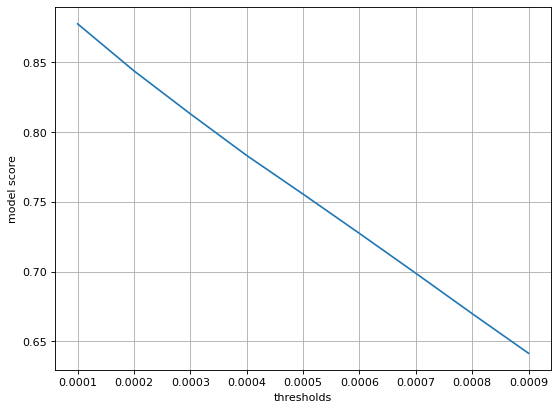

In [278]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
#plt.xticks(np.arange(len(thresholds)), thresholds, rotation='90')
plt.grid()

plt.plot(thresholds,np.sum(comp_ths, axis=0)/99)